<a href="https://colab.research.google.com/github/AdrianFrias/Proyecto3-Modelo-No-Supervisado/blob/main/ProyectoM3_Trabajo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Default

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neighbors import NearestNeighbors
import gc
import re
import warnings
import os
import glob
from sklearn.impute import SimpleImputer
warnings.filterwarnings("ignore")


#Parametros

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size']=12

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
pd.set_option('display.max_colwidth', 200)

#Funciones

In [ ]:
def Ver_documentos(carpeta,subcarpeta):
  archivos = [f for f in os.listdir(path+carpeta+subcarpeta) if f.endswith('.csv')]
  return archivos

In [ ]:
def Ver_todo(Carpetas,Informacion):
  for carp in Carpetas:
    print(carp)
    for inf in Informacion:
      print(f"{inf}: {Ver_documentos(carp,inf)}")
    print("-"*100)

In [ ]:
def obtener_catalogo(subdirectorio_data,nombre):
  nombre_catalogo = f"{nombre}.csv"
  ruta_catalogo = path+subdirectorio_data+'/catalogos/'+nombre_catalogo
  catalogo = pd.read_csv(ruta_catalogo)
  catalogo.columns = catalogo.columns.str.lower()
  #display(catalogo)
  return catalogo

In [ ]:
def mapear_clave_catalogo(
  df_principal: pd.DataFrame,
  path_base: str,
  subdirectorio_data: str,
  columna_a_sustituir: str,
  columna_catalogo:str=None,
  columna_descripcion: str = 'descrip',
  longitud_clave: int = 5) -> pd.DataFrame:

  if columna_catalogo is None:
      columna_catalogo = columna_a_sustituir
  nombre_catalogo = f"{columna_a_sustituir}.csv"
  ruta_catalogo = path_base+subdirectorio_data+'/catalogos/'+nombre_catalogo
  print(ruta_catalogo)
  try:
    catalogo = pd.read_csv(ruta_catalogo)
    catalogo.columns = catalogo.columns.str.lower()

    col_clave_cat = columna_catalogo.lower()
    col_desc_cat = columna_descripcion.lower()

    df_principal[columna_a_sustituir] = df_principal[columna_a_sustituir].astype(str).str.zfill(longitud_clave)
    catalogo[col_clave_cat] = catalogo[col_clave_cat].astype(str).str.zfill(longitud_clave)

    dic_mapeo = catalogo.set_index(col_clave_cat)[col_desc_cat].to_dict()

    df_principal[f'Map_{columna_a_sustituir}'] = df_principal[columna_a_sustituir].map(dic_mapeo)
    print(f"✅ Columna '{columna_a_sustituir}' mapeada exitosamente a descripciones.")
    return df_principal

  except FileNotFoundError:
      print(f" Error: No se encontró el catálogo en la ruta: {ruta_catalogo}")
      return df_principal
  except KeyError as e:
      print(f"Eror: La columna {e} no se encontró en el catálogo o en el DataFrame principal.")
      return df_principal

In [ ]:
def Graficar_corr(df,columnas,ancho=5, alto=2):
  plt.figure(figsize=(ancho,alto))
  sns.heatmap(df[columnas].corr(), annot=True, cmap='viridis',fmt=".2f",)
  plt.show()

In [ ]:
def missings_can_porcentaje(df):
  total = df.isnull().sum()
  porcentaje = (total/ len(df)) * 100
  missing_data = pd.concat([total, porcentaje], axis=1, keys=['Cantidad', 'Porcentaje'])
  resultado = missing_data[missing_data['Cantidad'] > 0].sort_values('Porcentaje', ascending=False)
  resultado

def values_can_porcentaje(df,columna):
  conteo = df[columna].value_counts()
  porcentaje = (conteo / len(df)) * 100
  resultado = pd.concat([conteo, porcentaje], axis=1, keys=['Cantidad', 'Porcentaje'])
  return resultado

In [ ]:
def agrupar_parentesco(codigo):
  if codigo == '101':
      return 'Jefe_Hogar'
  elif codigo.startswith('2'):
      return 'Conyuge_Pareja'
  elif codigo.startswith('3') or codigo in ['408', '409', '411']:
      return 'Hijos_Nietos'
  elif codigo.startswith('4'):
      return 'Familia_Extensa'
  elif codigo.startswith('6'):
      return 'Trabajador_Domestico'
  elif codigo.startswith('5') or codigo.startswith('7') or codigo == '999':
      return 'Sin_Parentesco'
  else:
      return 'Error'

In [ ]:
def clasificar_origen(renglon):
  codigos_latinoamerica = [200, 211, 214, 216, 217, 219, 220, 225, 228, 229, 234, 235, 237, 250]
  codigos_norteamerica = [213, 221]
  codigos_europa = [400, 415, 419, 423, 425, 435, 436, 437, 438, 439]
  codigos_asia_africa_resto = [100, 102, 142, 300, 315, 316, 325, 330, 343, 352, 500, 800, 999,33]

  lugar_nac = renglon['l_nac_c']
  lugar_res = renglon['cve_ent']
  if lugar_nac == lugar_res:
      return 'Local'
  elif lugar_nac >= 1 and lugar_nac <= 32:
      return 'Otro_Estado'
  elif lugar_nac in codigos_norteamerica:
      return 'EUA_Canada'
  elif lugar_nac in codigos_latinoamerica:
      return 'Latam'
  elif lugar_nac in codigos_europa:
      return 'Europa'
  elif lugar_nac in codigos_asia_africa_resto:
      return 'Asia_Africa_Resto'
  else:
      return 'Error'

In [ ]:
def aplicar_frecunecy_label(df, column_name):
  if column_name not in df.columns:
    print(f"No existe")
    return df
  dic_frecuencias = df[column_name].value_counts(normalize=True).to_dict()
  df[column_name] = df[column_name].map(dic_frecuencias)
  return df

In [ ]:
cols_cat=[]
cols_cont = []
cols_ordinal = []
cols_dummie = []
cols_no_usar=[]

#Rutas

In [ ]:
path = '/content/drive/My Drive/Datasets/ProyectoM3'
coe1='/conjunto_de_datos_coe1_enoe_2025_3t'
coe2='/conjunto_de_datos_coe2_enoe_2025_3t'
hog='/conjunto_de_datos_hog_enoe_2025_3t'
sdem='/conjunto_de_datos_sdem_enoe_2025_3t'
vivt='/conjunto_de_datos_viv_enoe_2025_3t'
cat='/catalogos/'
data='/conjunto_de_datos/'
dic='/diccionario_de_datos/'
meta='/metadatos/'
model='/modelo_entidad_relacion/'

In [ ]:
Carpetas=[vivt,hog,sdem,coe1,coe2]
Informacion=[cat,data,dic]

In [ ]:
print(Ver_documentos(vivt,data))

['conjunto_de_datos_viv_enoe_2025_3t.csv']


#Archivos

In [ ]:
indice_carpeta=pd.read_csv(path+'/0_indice_tablas_enoe_2025_3t.csv')
indice_carpeta

Encuesta Nacional de Ocupación y Empleo (ENOE), población de 15 años y más de edad
NaN                                                                                                                NaN
Nombre de archivo                                                                                     Título de Tablas
conjunto_de_datos_coe1_enoe_2025_3t                                        Cuestionario de ocupación y empleo parte I 
conjunto_de_datos_coe2_enoe_2025_3t                                        Cuestionario de ocupación y empleo parte II
conjunto_de_datos_hog_enoe_2025_3t                                                                             Hogares
conjunto_de_datos_sdem_enoe_2025_3t                                                 Caracaterísticas sociodemográficas
conjunto_de_datos_viv_enoe_2025_3t                                                                            Vivienda

In [ ]:
Ver_todo(Carpetas,Informacion)

/conjunto_de_datos_viv_enoe_2025_3t
/catalogos/: ['cd_a.csv', 'mes_cal.csv', 'p1.csv', 'n_ent.csv', 'p2.csv', 'p3.csv', 't_loc_men.csv', 't_loc_tri.csv', 'ur.csv', 'v_sel.csv', 'tipo.csv', 'cve_ent.csv', 'cve_mun.csv']
/conjunto_de_datos/: ['conjunto_de_datos_viv_enoe_2025_3t.csv']
/diccionario_de_datos/: ['diccionario_datos_viv_enoe_2025_3t.csv']
----------------------------------------------------------------------------------------------------
/conjunto_de_datos_hog_enoe_2025_3t
/catalogos/: ['cd_a.csv', 'h_mud.csv', 'e_obs.csv', 'mes_cal.csv', 'n_hog.csv', 'n_ent.csv', 'p4_1.csv', 'p_dia.csv', 'r_def.csv', 'r_pre.csv', 't_loc_men.csv', 'tipolev.csv', 't_loc_tri.csv', 'ur.csv', 'v_sel.csv', 'd_dia.csv', 'd_mes.csv', 'inf.csv', 'p_mes.csv', 'tipo.csv', 'cve_ent.csv', 'cve_mun.csv']
/conjunto_de_datos/: ['conjunto_de_datos_hog_enoe_2025_3t.csv']
/diccionario_de_datos/: ['diccionario_datos_hog_enoe_2025_3t.csv']
--------------------------------------------------------------------------

#Datasets

In [ ]:
df_VIVT=pd.read_csv(path+vivt+data+'/conjunto_de_datos_viv_enoe_2025_3t.csv')
df_HOGT=pd.read_csv(path+hog+data+'/conjunto_de_datos_hog_enoe_2025_3t.csv')
df_SDMET=pd.read_csv(path+sdem+data+'/conjunto_de_datos_sdem_enoe_2025_3t.csv', encoding='latin1')
df_COE1T=pd.read_csv(path+coe1+data+'/conjunto_de_datos_coe1_enoe_2025_3t.csv')
df_COE2T=pd.read_csv(path+coe2+data+'/conjunto_de_datos_coe2_enoe_2025_3t.csv')

Nuestra unidad muestral sera las personas que son pertencientes al dataframe de SDMET y es la que mas cantidad de regsitros tienen, hogar y vivienda son menos porque muchas personas pueden vivir en una sola, los cuestionarios tambien son menos peropuede que haya sido por que no quisieron responder o no podian hacerlo.

In [ ]:
print(df_VIVT.shape)
print(df_HOGT.shape)
print(df_SDMET.shape)
print(df_COE1T.shape)
print(df_COE2T.shape)

(150405, 26)
(151354, 38)
(422306, 115)
(346524, 174)
(346524, 84)


In [ ]:
print(df_VIVT.columns)
print(df_HOGT.columns)
print(df_SDMET.columns)
print(df_COE1T.columns)
print(df_COE2T.columns)

Index(['cve_loc', 'cve_mun', 'est', 'est_d_tri', 'est_d_men', 'cve_ageb',
       't_loc_tri', 't_loc_men', 'cd_a', 'cve_ent', 'con', 'upm', 'd_sem',
       'n_pro_viv', 'v_sel', 'n_ent', 'per', 'p1', 'p2', 'p3', 'ur', 'tipo',
       'mes_cal', 'fac_tri', 'fac_men', 'cvegeo'],
      dtype='object')
Index(['cve_loc', 'cve_mun', 'est', 'est_d_tri', 'est_d_men', 'cve_ageb',
       't_loc_tri', 't_loc_men', 'cd_a', 'cve_ent', 'con', 'upm', 'd_sem',
       'n_pro_viv', 'v_sel', 'n_hog', 'h_mud', 'n_ent', 'per', 'r_pre',
       'p_dia', 'p_mes', 'p_anio', 'r_def', 'd_dia', 'd_mes', 'd_anio',
       'e_obs', 'p4_1', 'p4_2', 'inf', 'ur', 'tipo', 'mes_cal', 'tipolev',
       'fac_tri', 'fac_men', 'cvegeo'],
      dtype='object')
Index(['r_def', 'cve_loc', 'cve_mun', 'est', 'est_d_tri', 'est_d_men',
       'cve_ageb', 't_loc_tri', 't_loc_men', 'cd_a',
       ...
       't_tra', 'emp_ppal', 'tue_ppal', 'trans_ppal', 'mh_fil2', 'mh_col',
       'sec_ins', 'tipo', 'mes_cal', 'cvegeo'],
      dtype='

In [ ]:
cols_V_H= df_VIVT.columns.intersection(df_HOGT.columns).tolist()
cols_H_E= df_HOGT.columns.intersection(df_SDMET.columns).tolist()
cols_E_C1= df_SDMET.columns.intersection(df_COE1T.columns).tolist()
cols_C1_C2= df_COE1T.columns.intersection(df_COE2T.columns).tolist()

In [ ]:
print(cols_V_H)
print(cols_H_E)
print(cols_E_C1)
print(cols_C1_C2)

['cve_loc', 'cve_mun', 'est', 'est_d_tri', 'est_d_men', 'cve_ageb', 't_loc_tri', 't_loc_men', 'cd_a', 'cve_ent', 'con', 'upm', 'd_sem', 'n_pro_viv', 'v_sel', 'n_ent', 'per', 'ur', 'tipo', 'mes_cal', 'fac_tri', 'fac_men', 'cvegeo']
['cve_loc', 'cve_mun', 'est', 'est_d_tri', 'est_d_men', 'cve_ageb', 't_loc_tri', 't_loc_men', 'cd_a', 'cve_ent', 'con', 'upm', 'd_sem', 'n_pro_viv', 'v_sel', 'n_hog', 'h_mud', 'n_ent', 'per', 'r_def', 'ur', 'tipo', 'mes_cal', 'fac_tri', 'fac_men', 'cvegeo']
['r_def', 'cve_mun', 'cd_a', 'cve_ent', 'con', 'upm', 'd_sem', 'n_pro_viv', 'v_sel', 'n_hog', 'h_mud', 'n_ent', 'per', 'n_ren', 'eda', 'ur', 'fac_tri', 'fac_men', 'tipo', 'mes_cal', 'cvegeo']
['cd_a', 'cve_ent', 'con', 'upm', 'd_sem', 'n_pro_viv', 'v_sel', 'n_hog', 'h_mud', 'n_ent', 'per', 'n_ren', 'eda', 'n_inf', 'ur', 'tipo', 'mes_cal', 'fac_tri', 'fac_men', 'cve_mun', 'cvegeo']


#Diccionario

Se tiene tambien un archivo en linea que contiene mas descripciones sobre las columnas de la base de datos

[Estructura de la base de datos](https://www.inegi.org.mx/contenidos/programas/enoe/15ymas/doc/enoe_123_fd_c_bas_amp.pdf)

In [ ]:
rutas_a_leer = [path + carpeta + dic for carpeta in Carpetas]
Dic_Dic = {}
for ruta in rutas_a_leer:
    archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))
    for archivo in archivos_csv:
        nombre = os.path.basename(archivo).replace('.csv', '')
        Dic_Dic[nombre] = pd.read_csv(archivo, encoding='latin1', on_bad_lines='skip')

In [ ]:
pd.set_option('display.max_rows', None)
for key, value in Dic_Dic.items():
    print(f"Clave: {key}")
    display(value)
    print("--"*50)
pd.reset_option('display.max_rows')


Clave: diccionario_datos_viv_enoe_2025_3t


NOMBRE_CAMPO  \
0                                                                                                NÃºmero de la localidad   
1                                                                                    NÃºmero de municipio segÃºn entidad   
2                                                                                             Estrato nacional y estatal   
3                                                                                          Estrato de diseÃ±o trimestral   
4                                                                                             Estrato de diseÃ±o mensual   
5                                                                                     NÃºmero de ageb del marco nacional   
6                                                                                        TamaÃ±o de localidad trimestral   
7                                                                                           TamaÃ±o de localidad mensual   
8                                                                                               Ciudad autorrepresentada   
9                                                                                                     Entidad federativa   
10                                                                                                               Control   
11                                                                                           Unidad primaria de muestreo   
12                                                                                                 DistribuciÃ³n semanal   
13                                                                                     NÃºmero progresivo de la vivienda   
14                                                                                                 Vivienda seleccionada   
15                                                                                         Numero de entrevista o visita   
16                                                                                                               Periodo   
17  Pregunta 1  Â¿CuÃ¡ntas personas viven normalmente en esta vivienda contando a los niÃ±os chiquitos y a los ancianos?   
18                                               Pregunta 2  Â¿Todas estas personas comparten un mismo gasto para comer?   
19          Pregunta 3  Â¿CuÃ¡ntos hogares o grupos de personas tienen gastos separados para comer contando el de usted?   
20                                                                                                          Urbano/Rural   
21                                                                                                    Tipo de entrevista   
22                                                                                                        Mes calendario   
23                                                                                                 Ponderador trimestral   
24                                                                                                    Ponderador mensual   
25                                                                                                 Clave geoestadistÃ­ca   

    LONGITUD TIPO  NEMÃNICO  CATÃLOGO  \
0          4    C    cve_loc        NaN   
1          3    C    cve_mun    cve_mun   
2          2    C        est        NaN   
3          4    C  est_d_tri        NaN   
4          4    C  est_d_men        NaN   
5          5    C   cve_ageb        NaN   
6          1    C  t_loc_tri  t_loc_tri   
7          1    C  t_loc_men  t_loc_men   
8          2    C       cd_a       cd_a   
9          2    C    cve_ent    cve_ent   
10         5    C        con        NaN   
11         7    C        upm        NaN   
12         3    C      d_sem        NaN   
13         4    C  n_pro_viv        NaN   
14         2    C      v_sel      v_sel   
15         2    C      n_ent      n_ent   
16         3    C        per

----------------------------------------------------------------------------------------------------
Clave: diccionario_datos_hog_enoe_2025_3t


NOMBRE_CAMPO  \
0                                                  NÃºmero de la localidad   
1                                      NÃºmero de municipio segÃºn entidad   
2                                               Estrato nacional y estatal   
3                                            Estrato de diseÃ±o trimestral   
4                                               Estrato de diseÃ±o mensual   
5                                       NÃºmero de ageb del marco nacional   
6                                          TamaÃ±o de localidad trimestral   
7                                             TamaÃ±o de localidad mensual   
8                                                 Ciudad autorrepresentada   
9                                                       Entidad federativa   
10                                                                 Control   
11                                             Unidad primaria de muestreo   
12                                                   DistribuciÃ³n semanal   
13                                       NÃºmero progresivo de la vivienda   
14                                                   Vivienda seleccionada   
15                                                        NÃºmero de hogar   
16                                                            Hogar mudado   
17                                           Numero de entrevista o visita   
18                                                                 Periodo   
19                                   Resultado preliminar de la entrevista   
20                                           DÃ­a del resultado preliminar   
21                                            Mes del resultado preliminar   
22                                           AÃ±o del resultado preliminar   
23                                   Resultado definitivo de la entrevista   
24                                           DÃ­a del resultado definitivo   
25                                            Mes del resultado definitivo   
26                                           AÃ±o del resultado definitivo   
27                                                    Entrevista observada   
28  Pregunta 4  Â¿En este hogar se contrata a trabajadores domÃ©sticos ...   
29                                                 Pregunta 4  Â¿CuÃ¡ntos?   
30                                                 RenglÃ³n del informante   
31                                                            Urbano/Rural   
32                                                      Tipo de entrevista   
33                                                          Mes calendario   
34                                  Tipo de levantamiento de la entrevista   
35                                                   Ponderador trimestral   
36                                                      Ponderador mensual   
37                                                   Clave geoestadistÃ­ca   

    LONGITUD TIPO  NEMÃNICO  CATÃLOGO  \
0          4    C    cve_loc        NaN   
1          3    C    cve_mun    cve_mun   
2          2    C        est        NaN   
3          4    C  est_d_tri        NaN   
4          4    C  est_d_men        NaN   
5          5    C   cve_ageb        NaN   
6          1    C  t_loc_tri  t_loc_tri   
7          1    C  t_loc_men  t_loc_men   
8          2    C       cd_a       cd_a   
9          2    C    cve_ent    cve_ent   
10         5    C        con        NaN   
11         7    C        upm        NaN   
12         3    C      d_sem        NaN   
13         4    C  n_pro_viv        NaN   
14         2    C      v_sel      v_sel   
15         1    C      n_hog      n_hog   
16         1    C      h_mud      h_mud   
17         2    C      n_ent      n_ent   
18         3    C        per        NaN   
19         2    C      r_pre      r_pre   
20         2    C      p_dia      p_dia   
21         2    C      p_mes      p_mes   
22         2    C     p_anio  

----------------------------------------------------------------------------------------------------
Clave: diccionario_datos_sdem_enoe_2025_3t


NOMBRE_CAMPO  \
0                                                                                                                                        Resultado definitivo de la entrevista   
1                                                                                                                                                      NÃºmero de la localidad   
2                                                                                                                                          NÃºmero de municipio segÃºn entidad   
3                                                                                                                                                   Estrato nacional y estatal   
4                                                                                                                                                Estrato de diseÃ±o trimestral   
5                                                                                                                                                   Estrato de diseÃ±o mensual   
6                                                                                                                                           NÃºmero de ageb del marco nacional   
7                                                                                                                                              TamaÃ±o de localidad trimestral   
8                                                                                                                                                 TamaÃ±o de localidad mensual   
9                                                                                                                                                     Ciudad autorrepresentada   
10                                                                                                                                                          Entidad federativa   
11                                                                                                                                                                     Control   
12                                                                                                                                                 Unidad primaria de muestreo   
13                                                                                                                                                       DistribuciÃ³n semanal   
14                                                                                                                                           NÃºmero progresivo de la vivienda   
15                                                                                                                                                       Vivienda seleccionada   
16                                                                                                                                                            NÃºmero de hogar   
17                                                                                                                                                                Hogar mudado   
18                                                                                                                                              NÃºmero de entrevista o visita   
19                                                                                                                                                                     Periodo   
20                                                                                                                                                         NÃºmero de renglÃ³n   
21                                                                                                                                         Pregunta 6 CondiciÃ³n de residencia   
22                                                                  

----------------------------------------------------------------------------------------------------
Clave: diccionario_datos_coe1_enoe_2025_3t


NOMBRE_CAMPO  \
0                                                                                                                    Resultado definitivo de la entrevista   
1                                                                                                                                 Ciudad autorrepresentada   
2                                                                                                                                       Entidad federativa   
3                                                                                                                                                  Control   
4                                                                                                                              Unidad primaria de muestreo   
5                                                                                                                                    DistribuciÃ³n semanal   
6                                                                                                                        NÃºmero progresivo de la vivienda   
7                                                                                                                                    Vivienda Seleccionada   
8                                                                                                                                         NÃºmero de hogar   
9                                                                                                                                             Hogar mudado   
10                                                                                                                          NÃºmero de entrevista o visita   
11                                                                                                                                                 Periodo   
12                                                                                                                                     NÃºmero de renglÃ³n   
13                                                                                                                                                    Edad   
14                                                                                                                                 RenglÃ³n del Informante   
15                                  Pregunta 1 Ahora le voy a preguntar por la situaciÃ³n laboral de ...Â¿La semana pasada trabajÃ³ por lo menos una hora?   
16                                                                             Pregunta 1a OpciÃ³n 1: realizar una actividad que le proporcionÃ³ ingresos?   
17                                                          Pregunta 1a OpciÃ³n 2: ayudar en las tierras o en el negocio de un familiar o de otra persona?   
18                                                                                                     Pregunta 1a OpciÃ³n 3: no trabajÃ³ la semana pasada   
19           Pregunta 1b Aunque ya me dijo que ... no trabajÃ³ la semana pasada,  Â¿tiene algÃºn empleo, negocio o realiza alguna actividad por su cuenta?   
20                                                                Pregunta 1c  Â¿CuÃºl es la razÃ³n principal por la que ... no trabajÃ³ la semana pasada?   
21                                                                          Pregunta 1d Durante este periodo de ausencia  Â¿... recibe sueldo o ganancias?   
22                                                                                   Pregunta 1e  Â¿En cuÃºnto tiempo regresarÃº ... a este mismo trabajo?   
23                                                        Pregunta 2 OpciÃ³n 1: buscar trabajo en otro paÃ­s o hacer preparativos para cruzar la frontera?   
24                                                                                                  Pregunta 2 OpciÃ³n 2: buscar trabajo aquÃ­ en el paÃ­s   
25                                

----------------------------------------------------------------------------------------------------
Clave: diccionario_datos_coe2_enoe_2025_3t


NOMBRE_CAMPO  \
0                                                                                                                      Ciudad autorrepresentada   
1                                                                                                                            Entidad federativa   
2                                                                                                                                       Control   
3                                                                                                                   Unidad primaria de muestreo   
4                                                                                                                         DistribuciÃ³n semanal   
5                                                                                                             NÃºmero progresivo de la vivienda   
6                                                                                                                         Vivienda Seleccionada   
7                                                                                                                              NÃºmero de hogar   
8                                                                                                                                  Hogar mudado   
9                                                                                                                NÃºmero de entrevista o visita   
10                                                                                                                                      Periodo   
11                                                                                                                          NÃºmero de renglÃ³n   
12                                                                                                                                         Edad   
13                                                                                                                      RenglÃ³n del Informante   
14                                                                                                         Pregunta 6 OpciÃ³n 1: por comisiÃ³n?   
15                                                                      Pregunta 6 OpciÃ³n 2: a destajo (por pieza), servicio u obra realizada?   
16                                                                                                        Pregunta 6 OpciÃ³n 3: por honorarios?   
17                                                                                                          Pregunta 6 OpciÃ³n 4: con propinas?   
18                                                                         Pregunta 6 OpciÃ³n 5: con bonos de compensaciÃ³n o de productividad?   
19                                                                                Pregunta 6 OpciÃ³n 6: con vales o productos comercializables?   
20                                                                                   Pregunta 6 OpciÃ³n 7: Solo recibe sueldo, salario o jornal   
21                                                                                         Pregunta 6 OpciÃ³n 8: Solo lo que le deja su negocio   
22                                                      Pregunta 6 OpciÃ³n 9: no le pagan ni recibe ingresos (incluye autoconsumo agropecuario)   
23                                                                                             Pregunta 6 OpciÃ³n 10: ninguna de las anteriores   
24                                                                                                               Pregunta 6 OpciÃ³n 99: no sabe   
25                                                                                           Pregunta 6a OpciÃ³n 1: a sueldo, salario o jornal?   
26                                                                            Pregunta 6a OpciÃ³n 2: por ganancias o de lo que deja su negocio?   
27             

----------------------------------------------------------------------------------------------------


#Relacion de Tablas

Las releaciones son que una vivienda puede tener varios hogares, un hogar puede contener muchas personas, no todas las personas respondieron las encuenstas.

In [ ]:
# img_base = plt.imread(path +carp1+ scarp5 + '/modelo_er_enoe_2025_3t.jpg')
# plt.figure(figsize=(30, 30))
# plt.imshow(img_base)
# plt.axis('off') # Hide axes for better image display
# plt.show()

#Vivienda

Esta tabla describe el contexto y las características de cada vivienda seleccionada y entrevistada por parte de la ENOE.


In [ ]:
df_VIVT

cve_loc cve_mun  est  est_d_tri est_d_men  cve_ageb  t_loc_tri  \
0                    1   10        501       501         0          1   
1                    1   10        501       501         0          1   
2                    1   10        501       501         0          1   
3                    1   10        501       501         0          1   
4                    1   10        501       501         0          1   
...        ...     ...  ...        ...       ...       ...        ...   
150400              10   20       1244      1244         0          4   
150401              10   20       1244      1244         0          4   
150402              10   20       1244      1244         0          4   
150403              10   20       1244      1244         0          4   
150404              10   20       1244      1244         0          4   

       t_loc_men  cd_a  cve_ent    con      upm  d_sem  n_pro_viv  v_sel  \
0              1    14        1  40001   100292    312         13     51   
1              1    14        1  40001   100292    312         35     52   
2              1    14        1  40001   100292    312         58     53   
3              1    14        1  40001   100292    312         82     54   
4              1    14        1  40001   100292    312        107     55   
...          ...   ...      ...    ...      ...    ...        ...    ...   
150400         4    86       32  60078  3260119    301         55     66   
150401         4    86       32  60078  3260119    301         11     67   
150402         4    86       32  60078  3260119    301         17     68   
150403         4    86       32  60078  3260119    301          7     69   
150404         4    86       32  60078  3260119    301         54     70   

        n_ent  per p1 p2 p3  ur  tipo  mes_cal  fac_tri  fac_men  cvegeo  
0           5  325  8  1      1     1        9       23       58    1001  
1           5  325  1         1     1        9       23       58    1001  
2           5  325  6  1      1     1        9       23       58    1001  
3           5  325  4  1      1     1        9       23       58    1001  
4           5  325  4  1      1     1        9       23       58    1001  
...       ...  ... .. .. ..  ..   ...      ...      ...      ...     ...  
150400      5  325  2  1      2     1        7      216      668   32010  
150401      5  325  5  1      2     1        7      216      668   32010  
150402      5  325  5  1      2     1        7      216      668   32010  
150403      5  325  3  1      2     1        7      216      668   32010  
150404      5  325  2  1      2     1        7      216      668   32010  

[150405 rows x 26 columns]

##cve_loc: Clave numérica de la localidad geográfica.


In [ ]:
df_VIVT['cve_loc'].unique()

array([' ', nan], dtype=object)

In [ ]:
df_VIVT['cve_loc'].value_counts()

cve_loc
    150404
Name: count, dtype: int64

In [ ]:
df_VIVT['cve_loc']

0          
1          
2          
3          
4          
         ..
150400     
150401     
150402     
150403     
150404     
Name: cve_loc, Length: 150405, dtype: object

Esta practicamente vacia por lo que no aporta nada de informacion

In [ ]:
df_VIVT.drop('cve_loc', axis=1, inplace=True)

##cve_mun: Clave numérica del municipio al que pertenece la vivienda dentro de su entidad.

In [ ]:
df_VIVT['cve_mun']

0          1
1          1
2          1
3          1
4          1
          ..
150400    10
150401    10
150402    10
150403    10
150404    10
Name: cve_mun, Length: 150405, dtype: object

In [ ]:
len(df_VIVT['cve_mun'].unique())

223

In [ ]:
df_VIVT['cve_mun'].value_counts()

cve_mun
2      7180
1      6968
5      6568
3      6481
4      6451
       ... 
310      10
181       5
182       5
135       5
175       5
Name: count, Length: 223, dtype: int64

In [ ]:
df_VIVT['cve_mun'].isna().sum()

np.int64(0)

In [ ]:
obtener_catalogo(vivt,'cve_mun')

cvegeo  cve_ent  cve_mun                descrip
0       1001        1        1         Aguascalientes
1       1002        1        2               Asientos
2       1003        1        3               Calvillo
3       1004        1        4                  Cosío
4       1005        1        5            Jesús María
...      ...      ...      ...                    ...
2453   32054       32       54          Villa Hidalgo
2454   32055       32       55             Villanueva
2455   32056       32       56              Zacatecas
2456   32057       32       57               Trancoso
2457   32058       32       58  Santa María de la Paz

[2458 rows x 4 columns]

In [ ]:
df_VIVT.iloc[24881]

cve_mun            
est              20
est_d_tri       606
est_d_men       606
cve_ageb          0
t_loc_tri         4
t_loc_men         4
cd_a             86
cve_ent           5
con           60030
upm          560137
d_sem           501
n_pro_viv       189
v_sel            51
n_ent             3
per             325
p1                5
p2                1
p3                 
ur                2
tipo              1
mes_cal           7
fac_tri         382
fac_men        1097
cvegeo         5999
Name: 24881, dtype: object

Se obtendra su valor del catalogo ya que en su representacion actual pasara como oridinal y causara que los modelos asuman distancias que no son

In [ ]:
df_VIVT = mapear_clave_catalogo(df_VIVT,path,vivt,'cve_mun')

/content/drive/My Drive/Datasets/ProyectoM3/conjunto_de_datos_viv_enoe_2025_3t/catalogos/cve_mun.csv
✅ Columna 'cve_mun' mapeada exitosamente a descripciones.


In [ ]:
df_VIVT['cve_mun'][df_VIVT['cve_mun'].isnull()]

Series([], Name: cve_mun, dtype: object)

Al se demasiado grnaular no me dara sufieicente y al haber otras que me dan informcaio de la localizacion se decidira no tomara esta columna y su mapeo

In [ ]:
df_VIVT.drop('cve_mun', axis=1, inplace=True)
df_VIVT.drop('Map_cve_mun', axis=1, inplace=True)

##est: Clave del estrato de diseño muestral (nacional y estatal).

In [ ]:
df_VIVT['est'].unique()

array([10, 20, 30, 40])

In [ ]:
df_VIVT['est'].isna().sum()

np.int64(0)

In [ ]:
df_VIVT['est'].value_counts()

est
20    63449
30    42105
40    24030
10    20821
Name: count, dtype: int64

El segundo digito se usa para el subestrato o estrato estatal pero al ser igual podemos eliminar ese dato

El primer Carácter es la clave del estrato nacional pero no se sabe que representa exactamente que representa, puede ser una categoria o un valor nominal, se revisara mas adelante alguna correlacion para ver si se puede explicar con alguna otra, se separara y quedadra como nuemrico.

In [ ]:
df_VIVT['est'] = df_VIVT['est'].astype(str).str[0].astype(int)

In [ ]:
df_VIVT['est']

0         1
1         1
2         1
3         1
4         1
         ..
150400    2
150401    2
150402    2
150403    2
150404    2
Name: est, Length: 150405, dtype: int64

##est_d_tri: Clave del estrato de diseño muestral para las estimaciones trimestrales.


In [ ]:
df_VIVT['est_d_tri'].describe()

count    150405.000000
mean        859.167129
std         222.161079
min         501.000000
25%         660.000000
50%         849.000000
75%        1062.000000
max        1245.000000
Name: est_d_tri, dtype: float64

In [ ]:
df_VIVT['est_d_tri'].value_counts()

est_d_tri
680     1490
712     1395
1128    1395
664     1280
681     1215
        ... 
854        5
1181       5
908        5
524        5
528        5
Name: count, Length: 745, dtype: int64

In [ ]:
df_VIVT['est_d_tri'].isna().sum()

np.int64(0)

define el estrato socio-geográfico preciso al que pertenece la vivienda por lo que sera bueno mantenerla



##est_d_men: Clave del estrato de diseño muestral para las estimaciones mensuales.

In [ ]:
df_VIVT['est_d_men'].describe()

count     150405
unique       746
top             
freq        7475
Name: est_d_men, dtype: object

In [ ]:
df_VIVT['est_d_men'] = df_VIVT['est_d_men'].replace(' ', np.nan).astype(float)

In [ ]:
df_VIVT['est_d_men'].describe()

count    142930.000000
mean        860.260526
std         222.177870
min         501.000000
25%         664.000000
50%         849.000000
75%        1062.000000
max        1245.000000
Name: est_d_men, dtype: float64

In [ ]:
df_VIVT['est_d_men'].value_counts()

est_d_men
680.0     1375
712.0     1290
1128.0    1290
664.0     1175
681.0     1120
          ... 
1131.0       5
1181.0       5
854.0        5
589.0        5
908.0        5
Name: count, Length: 745, dtype: int64

In [ ]:
df_VIVT['est_d_men'].isna().sum()

np.int64(7475)

In [ ]:
df_VIVT['est_d_men'].isna().sum()*100/df_VIVT.shape[0]

np.float64(4.969914564010505)

La relacion entre est_d_men y est_d_tri es la misma linealmente por lo que podomos eliminar una y sera est_d_men que tiene valores nulos

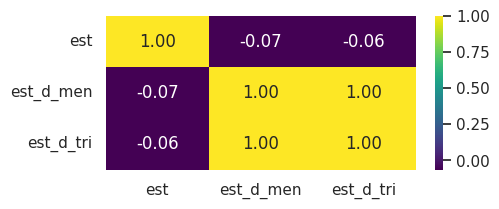

In [ ]:
plt.figure(figsize=(5,2))
sns.heatmap(df_VIVT[['est','est_d_men','est_d_tri']].corr(), annot=True, cmap='viridis',fmt=".2f",)
plt.show()

In [ ]:
df_VIVT.drop('est_d_men', axis=1, inplace=True)

##cve_ageb: Clave del Área Geoestadística Básica (AGEB) a la que pertenece la vivienda.

In [ ]:
df_VIVT['cve_ageb'].unique()

array([0])

In [ ]:
df_VIVT['cve_ageb'].value_counts()

cve_ageb
0    150405
Name: count, dtype: int64

In [ ]:
df_VIVT.drop('cve_ageb', axis=1, inplace=True)

##t_loc_tri: Clave que indica el tamaño de la localidad para las estimaciones trimestrales.

In [ ]:
df_VIVT['t_loc_tri'].unique()

array([1, 2, 3, 4])

In [ ]:
df_VIVT['t_loc_tri'].value_counts()

t_loc_tri
1    87730
4    23976
2    19490
3    19209
Name: count, dtype: int64

In [ ]:
df_VIVT['t_loc_tri'].isna().sum()

np.int64(0)

Como representa la cantidad de personas puede quedarse como numerico ya que es tipo ordinal

In [ ]:
obtener_catalogo(vivt,'t_loc_tri')

cve                                     descrip
0    1   Localidades mayores de 100 000 habitantes
1    2   Localidades de 15 000 a 99 999 habitantes
2    3  Localidades de 2 500 a 14 999 habitantes  
3    4   Localidades menores de 2 500 habitantes

##- t_loc_men: Clave que indica el tamaño de la localidad para las estimaciones mensuales.

In [ ]:
df_VIVT['t_loc_men'].unique()

array(['1', ' ', '2', '3', '4'], dtype=object)

In [ ]:
df_VIVT['t_loc_men'] = df_VIVT['t_loc_men'].replace(' ', np.nan).astype(float)

In [ ]:
df_VIVT['t_loc_men'].unique()

array([ 1., nan,  2.,  3.,  4.])

In [ ]:
df_VIVT['t_loc_men'].value_counts()

t_loc_men
1.0    81655
4.0    23761
2.0    18810
3.0    18704
Name: count, dtype: int64

In [ ]:
df_VIVT['t_loc_men'].isna().sum()

np.int64(7475)

In [ ]:
df_VIVT['t_loc_men'].isna().sum()*100/df_VIVT.shape[0]

np.float64(4.969914564010505)

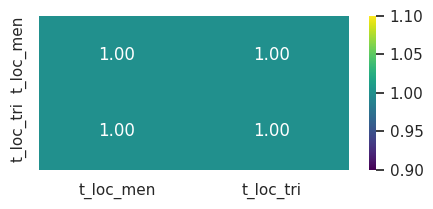

In [ ]:
Graficar_corr(df_VIVT,['t_loc_men','t_loc_tri'])

Mismo problema que anteriormente de que dos columnas estan muy correlacionadas, se trabajara con solo t_loc_tri

In [ ]:
df_VIVT.drop('t_loc_men', axis=1, inplace=True)

##cd_a: Clave que identifica si la vivienda se encuentra en una ciudad autorrepresentada (grandes ciudades).

In [ ]:
df_VIVT['cd_a'].unique()

array([14, 83, 84, 85, 86, 21, 44, 81, 82, 40, 28, 42,  6, 17, 33, 19, 52,
        9, 20,  1, 26,  5, 13, 43,  2, 16, 15, 29, 27,  3, 31,  4, 36, 41,
        7, 24, 25, 18, 10, 46, 39, 12, 30,  8, 32])

In [ ]:
df_VIVT['cd_a'].value_counts().sort_index().to_frame().T

cd_a     1     2     3     4     5     6     7     8     9     10    12    13  \
count  6065  3350  3445  3240  3185  3290  2370  2420  2245  2225  2175  2225   

cd_a     14    15    16    17    18    19    20    21    24    25    26    27  \
count  2520  2230  2165  2265  2240  2175  2340  2400  2265  2265  2300  2300   

cd_a     28    29    30    31    32    33    36    39    40    41    42    43  \
count  1965  2400  2120  2210  2215  2330  2415  2500  1985  2390  2235  2220   

cd_a     44    46    52    81    82    83    84    85     86  
count  2235  2220  2130  8980  3820  7380  7240  4884  20831

In [ ]:
obtener_catalogo(vivt,'cd_a')

cve                   descrip
0     1                    México
1     2               Guadalajara
2     3                 Monterrey
3     4                    Puebla
4     5                      León
5     6                   Torreón
6     7           San Luis Potosí
7     8                    Mérida
8     9                 Chihuahua
9    10                   Tampico
10   12                  Veracruz
11   13                  Acapulco
12   14            Aguascalientes
13   15                   Morelia
14   16                    Toluca
15   17                  Saltillo
16   18              Villahermosa
17   19          Tuxtla Gutiérrez
18   20             Ciudad Juárez
19   21                   Tijuana
20   24                  Culiacán
21   25                Hermosillo
22   26                   Durango
23   27                     Tepic
24   28                  Campeche
25   29                Cuernavaca
26   30             Coatzacoalcos
27   31                    Oaxaca
28   32                 Zacatecas
29   33                    Colima
30   36                 Querétaro
31   39                  Tlaxcala
32   40                    La Paz
33   41                    Cancún
34   42         Ciudad del Carmen
35   43                   Pachuca
36   44                  Mexicali
37   46                   Reynosa
38   52                 Tapachula
39   81  Complemento urbano-Rural
40   82  Complemento urbano-Rural
41   83  Complemento urbano-Rural
42   84  Complemento urbano-Rural
43   85  Complemento urbano-Rural
44   86  Complemento urbano-Rural

In [ ]:
df_VIVT=mapear_clave_catalogo(df_VIVT,path,vivt,'cd_a','cve')

/content/drive/My Drive/Datasets/ProyectoM3/conjunto_de_datos_viv_enoe_2025_3t/catalogos/cd_a.csv
✅ Columna 'cd_a' mapeada exitosamente a descripciones.


In [ ]:
df_VIVT

est  est_d_tri  t_loc_tri   cd_a  cve_ent    con      upm  d_sem  \
0         1        501          1  00014        1  40001   100292    312   
1         1        501          1  00014        1  40001   100292    312   
2         1        501          1  00014        1  40001   100292    312   
3         1        501          1  00014        1  40001   100292    312   
4         1        501          1  00014        1  40001   100292    312   
...     ...        ...        ...    ...      ...    ...      ...    ...   
150400    2       1244          4  00086       32  60078  3260119    301   
150401    2       1244          4  00086       32  60078  3260119    301   
150402    2       1244          4  00086       32  60078  3260119    301   
150403    2       1244          4  00086       32  60078  3260119    301   
150404    2       1244          4  00086       32  60078  3260119    301   

        n_pro_viv  v_sel  n_ent  per p1 p2 p3  ur  tipo  mes_cal  fac_tri  \
0              13     51      5  325  8  1      1     1        9       23   
1              35     52      5  325  1         1     1        9       23   
2              58     53      5  325  6  1      1     1        9       23   
3              82     54      5  325  4  1      1     1        9       23   
4             107     55      5  325  4  1      1     1        9       23   
...           ...    ...    ...  ... .. .. ..  ..   ...      ...      ...   
150400         55     66      5  325  2  1      2     1        7      216   
150401         11     67      5  325  5  1      2     1        7      216   
150402         17     68      5  325  5  1      2     1        7      216   
150403          7     69      5  325  3  1      2     1        7      216   
150404         54     70      5  325  2  1      2     1        7      216   

        fac_men  cvegeo                  Map_cd_a  
0            58    1001            Aguascalientes  
1            58    1001            Aguascalientes  
2            58    1001            Aguascalientes  
3            58    1001            Aguascalientes  
4            58    1001            Aguascalientes  
...         ...     ...                       ...  
150400      668   32010  Complemento urbano-Rural  
150401      668   32010  Complemento urbano-Rural  
150402      668   32010  Complemento urbano-Rural  
150403      668   32010  Complemento urbano-Rural  
150404      668   32010  Complemento urbano-Rural  

[150405 rows x 22 columns]

In [ ]:
df_VIVT[['cd_a','Map_cd_a']]

cd_a                  Map_cd_a
0       00014            Aguascalientes
1       00014            Aguascalientes
2       00014            Aguascalientes
3       00014            Aguascalientes
4       00014            Aguascalientes
...       ...                       ...
150400  00086  Complemento urbano-Rural
150401  00086  Complemento urbano-Rural
150402  00086  Complemento urbano-Rural
150403  00086  Complemento urbano-Rural
150404  00086  Complemento urbano-Rural

[150405 rows x 2 columns]

In [ ]:
df_VIVT.drop('cd_a', axis=1, inplace=True)

##cve_ent: Clave numérica de la Entidad Federativa (estado) donde se ubica la vivienda.

In [ ]:
df_VIVT['cve_ent'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [ ]:
df_VIVT['cve_ent'].value_counts().sort_index().to_frame().T

cve_ent    1     2     3     4     5     6     7     8     9     10    11  \
count    4061  5979  3473  5502  5886  4006  6564  5577  3855  4644  5254   

cve_ent    12    13    14    15    16    17    18    19    20    21    22  \
count    4465  3965  4806  5765  4185  3962  4163  4669  4666  4966  4164   

cve_ent    23    24    25    26    27    28    29    30    31    32  
count    3964  4165  4067  4066  4161  6183  3862  7138  3963  4259

In [ ]:
obtener_catalogo(vivt,'cve_ent').T

0                1                    2         3   \
cvegeo                1                2                    3         4   
cve_ent               1                2                    3         4   
descrip  Aguascalientes  Baja California  Baja California Sur  Campeche   

               4       5        6          7                 8        9   \
cvegeo          5       6        7          8                 9       10   
cve_ent         5       6        7          8                 9       10   
descrip  Coahuila  Colima  Chiapas  Chihuahua  Ciudad de México  Durango   

                 10        11       12       13      14         15       16  \
cvegeo           11        12       13       14      15         16       17   
cve_ent          11        12       13       14      15         16       17   
descrip  Guanajuato  Guerrero  Hidalgo  Jalisco  México  Michoacán  Morelos   

              17          18      19      20         21            22  \
cvegeo        18          19      20      21         22            23   
cve_ent       18          19      20      21         22            23   
descrip  Nayarit  Nuevo León  Oaxaca  Puebla  Querétaro  Quintana Roo   

                      23       24      25       26          27        28  \
cvegeo                24       25      26       27          28        29   
cve_ent               24       25      26       27          28        29   
descrip  San Luis Potosí  Sinaloa  Sonora  Tabasco  Tamaulipas  Tlaxcala   

               29       30         31  
cvegeo         30       31         32  
cve_ent        30       31         32  
descrip  Veracruz  Yucatán  Zacatecas

In [ ]:
df_VIVT=mapear_clave_catalogo(df_VIVT,path,vivt,'cve_ent')

/content/drive/My Drive/Datasets/ProyectoM3/conjunto_de_datos_viv_enoe_2025_3t/catalogos/cve_ent.csv
✅ Columna 'cve_ent' mapeada exitosamente a descripciones.


In [ ]:
df_VIVT['cve_ent']

0         00001
1         00001
2         00001
3         00001
4         00001
          ...  
150400    00032
150401    00032
150402    00032
150403    00032
150404    00032
Name: cve_ent, Length: 150405, dtype: object

In [ ]:
df_VIVT['cve_ent'].isna().sum()

np.int64(0)

## con: Clave de control interno de la muestra.

In [ ]:
len(df_VIVT['con'].unique())

1827

In [ ]:
df_VIVT['con'].value_counts()

con
60014    462
60009    460
60005    459
60025    441
60010    441
        ... 
42383      5
50172      5
42420      5
42419      5
42418      5
Name: count, Length: 1827, dtype: int64

In [ ]:
df_VIVT['con'].describe()

count    150405.000000
mean      45095.766564
std        7427.369862
min           1.000000
25%       40219.000000
50%       40597.000000
75%       50057.000000
max       60099.000000
Name: con, dtype: float64

In [ ]:
df_VIVT['con'].isna().sum()

np.int64(0)

Este valor es un inidice usado por la tabla para relacionarse con otras tablas, no sera de utilidad como caractericticas pero si para unir

##upm: Clave de la Unidad Primaria de Muestreo utilizada en el diseño muestral.

In [ ]:
len(df_VIVT['upm'].unique())

21252

In [ ]:
df_VIVT['upm'].value_counts()

upm
1360709    45
1860456    44
760546     44
2161047    42
2360418    41
           ..
400803      5
400766      5
400672      5
400553      5
400467      5
Name: count, Length: 21252, dtype: int64

In [ ]:
df_VIVT['upm'].describe()

count    1.504050e+05
mean     1.639630e+06
std      9.349668e+05
min      1.000940e+05
25%      8.032020e+05
50%      1.604240e+06
75%      2.500504e+06
max      3.261264e+06
Name: upm, dtype: float64

In [ ]:
df_VIVT['upm'].isna().sum()

np.int64(0)

Una UPM es un grupo que se selecciona en un proceso de muestreo complejo de múltiples etapas ya que en ves de elegir usuarios al azar de una zona extenesa mejor primero se seleccionan estos grupos y después se seleccionan elementos dentro de ellos. Es mas util para ver que se eligan zonas representativas y mutuamnete excluyentes, pero no ofrecen una caracteritica sociodemográfico interpretable por lo que no se usara.

In [ ]:
df_VIVT.drop('upm', axis=1, inplace=True)

##d_sem: Clave que indica la distribución de la entrevista en el calendario semanal.


In [ ]:
np.sort(df_VIVT['d_sem'].unique())

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513])

In [ ]:
df_VIVT['d_sem'].value_counts()

d_sem
301    5201
203    5150
202    5111
402    5080
401    5080
       ... 
209    1475
207    1470
406    1465
411    1465
311    1460
Name: count, Length: 65, dtype: int64

In [ ]:
df_VIVT['d_sem'].describe()

count    150405.000000
mean        304.983684
std         141.322212
min         101.000000
25%         202.000000
50%         303.000000
75%         408.000000
max         513.000000
Name: d_sem, dtype: float64

In [ ]:
df_VIVT['d_sem'].isna().sum()

np.int64(0)

De lo investigado en el [Diseño Muestral](https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/nueva_estruc/889463908777.pdf) se entiende que un numero de vecidades se entrevistan dividido en 5 paneles cada trimestre, cada trimestre la vecindad empieza en 1 y termina en 5,  esto con el fin de tener de cierta forma datos conscistentes con los 4 pero un panel de datos nuevos cada trismetre. Se quedara con el primero ya que nos indica el punto de estudio de la vivienda y la semana se dejara de lado ya que fue mas una herramienta logistica ya que es poco probable que los ascperctos socioeconmicos de las viviendas sean muy diferentes de una semana que se hizo la entrevista que a la semana que sigue

In [ ]:
df_VIVT['d_sem']=df_VIVT['d_sem'].astype(str).str[0].astype(int)

In [ ]:
df_VIVT['d_sem']

0         3
1         3
2         3
3         3
4         3
         ..
150400    3
150401    3
150402    3
150403    3
150404    3
Name: d_sem, Length: 150405, dtype: int64

##n_pro_viv: Número consecutivo de la vivienda dentro de la muestra.

In [ ]:
df_VIVT['n_pro_viv'].value_counts()

n_pro_viv
47     1155
11     1147
13     1144
16     1141
15     1139
       ... 
565       1
644       1
366       1
474       1
434       1
Name: count, Length: 511, dtype: int64

In [ ]:
df_VIVT['n_pro_viv'].describe()

count    150405.000000
mean         75.477451
std          52.888559
min           1.000000
25%          35.000000
50%          70.000000
75%         108.000000
max        1478.000000
Name: n_pro_viv, dtype: float64

In [ ]:
df_VIVT['n_pro_viv'].isnull().sum()

np.int64(0)

Esta variable solo es util para la logistica de las entrevistas que se haen en las muestras pero no ofrece alguna carateristica de la vivienda, no se usara en el dataset

In [ ]:
df_VIVT.drop('n_pro_viv', axis=1, inplace=True)

##v_sel: Clave que indica la selección de la vivienda.

In [ ]:
np.sort(df_VIVT['v_sel'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

In [ ]:
df_VIVT['v_sel'].value_counts()

v_sel
51    16777
52    16777
53    16777
54    16777
55    16777
      ...  
73       10
96        7
74        3
21        2
97        1
Name: count, Length: 68, dtype: int64

In [ ]:
df_VIVT['v_sel'].describe()

count    150405.000000
mean         47.462292
std          22.883891
min           1.000000
25%          51.000000
50%          53.000000
75%          55.000000
max          97.000000
Name: v_sel, dtype: float64

In [ ]:
df_VIVT['v_sel'].isna().sum()

np.int64(0)

In [ ]:
obtener_catalogo(vivt,'v_sel')

cve                 descrip
0     1            Vivienda uno
1     2            Vivienda dos
2     3           Vivienda tres
3     4         Vivienda cuatro
4     5          Vivienda cinco
5     6           Vivienda seis
6     7          Vivienda siete
7     8           Vivienda ocho
8     9          Vivienda nueve
9    10           Vivienda diez
10   11           Vivienda once
11   12           Vivienda doce
12   13         Vivienda trece 
13   14       Vivienda catorce 
14   15        Vivienda quince 
15   16     Vivienda dieciséis 
16   17    Vivienda diecisiete 
17   18     Vivienda dieciocho 
18   19    Vivienda diecinueve 
19   20        Vivienda veinte 
20   21     Vivienda veintiuno 
21   22     Vivienda veintidós 
22   23    Vivienda veintitrés 
23   24  Vivienda veinticuatro 
24   25   Vivienda veinticinco 
25   26    Vivienda veintiséis 
26   27   Vivienda veintisiete 
27   28    Vivienda veintiocho 
28   29   Vivienda veintinueve 
29   30        Vivienda treinta

No aporta informacion pero su utilidad es logistica y en este caso para unir las tablas

##n_ent: Número de veces que se ha intentado entrevistar o se ha visitado la vivienda.

In [ ]:
df_VIVT['n_ent'].unique()

array([5, 4, 3, 1, 2])

In [ ]:
df_VIVT['n_ent'].value_counts()

n_ent
5    30201
1    30192
2    30047
4    30020
3    29945
Name: count, dtype: int64

In [ ]:
df_VIVT['n_ent'].isna().sum()

np.int64(0)

In [ ]:
obtener_catalogo(vivt,'n_ent')

cve             descrip
0    1  Primera entrevista
1    2  Segunda entrevista
2    3  Tercera entrevista
3    4   Cuarta entrevista
4    5   Quinta entrevista

Parece que el numero de la entrevista es mas util de saber que el panel al que se asocio la vivienda ya que ese no tiene un patron ordinal relevante, se quedara con n_ent

In [ ]:
display(df_VIVT[df_VIVT['n_ent']==1]['d_sem'].unique())
display(df_VIVT[df_VIVT['n_ent']==2]['d_sem'].unique())
display(df_VIVT[df_VIVT['n_ent']==3]['d_sem'].unique())
display(df_VIVT[df_VIVT['n_ent']==4]['d_sem'].unique())
display(df_VIVT[df_VIVT['n_ent']==5]['d_sem'].unique())

array([2])

array([1])

array([5])

array([4])

array([3])

In [ ]:
df_VIVT.drop('d_sem', axis=1, inplace=True)

##per: Clave que identifica el periodo (trimestre o mes) al que corresponde la información.

In [ ]:
df_VIVT['per'].unique()

array([325])

Es unico ya que se esta evaluando el tercer trimestre del 2025

In [ ]:
df_VIVT.drop('per', axis=1, inplace=True)

##Preguntas

- p1: Número total de personas que residen habitualmente en la vivienda.
- p2: Indica si todos los residentes comparten o no los gastos de comida (para identificar hogares).
- p3: Número de hogares separados dentro de la misma vivienda.

In [ ]:
preguntas=['p1','p2','p3']

In [ ]:
print(df_VIVT['p1'].unique())
print(df_VIVT['p2'].unique())
print(df_VIVT['p3'].unique())

['8' '1' '6' '4' ' ' '3' '5' '2' '12' '7' '10' '9' '11' '16' '14' '13'
 '15' '19' '21' '18']
['1' ' ' '2']
[' ' '4' '2' '3' '5']


Estas son viviendas presentan en las 3 preguntas nulos y puede que no esten habitadas o viviendas que no fueron encuestadas. Si fuera un error aleatorio, no tendrías exactamente las mismas 3 preguntas vacías ya que si fuera un error de p1 algunas personas habrían contestado al menos P2 o P3

In [ ]:
display(df_VIVT[df_VIVT['p1']==' ']['p2'].value_counts())
display(df_VIVT[df_VIVT['p1']==' ']['p3'].value_counts())

p2
    25616
Name: count, dtype: int64

p3
    25616
Name: count, dtype: int64

In [ ]:
#df_VIVT['ELIMINAR'] = (df_VIVT['p1'] == ' ').astype(int)
dfE_VIVT=df_VIVT[df_VIVT['p1']==' '].copy()
df_VIVT=df_VIVT[df_VIVT['p1']!=' ']
df_VIVT.shape

(124789, 18)

In [ ]:
df_VIVT['p1']=df_VIVT['p1'].replace(' ', np.nan).astype(float)

In [ ]:
df_VIVT['p2'].value_counts()

p2
1    107492
      16689
2       608
Name: count, dtype: int64

Los que no repsonieron es porque solo vive una persona y no tiene que compartir gastos por eso no es si y tampoco no, la tercera como p1 fue solo una prsona no aplico la pregunta 3 porque el resultado es 1 sola vivienda  

In [ ]:
display(df_VIVT[df_VIVT['p2']==' ']['p1'].value_counts())
display(df_VIVT[df_VIVT['p2']==' ']['p3'].value_counts())

p1
1.0    16689
Name: count, dtype: int64

p3
    16689
Name: count, dtype: int64

In [ ]:
mask_unipersonal = (df_VIVT['p1'] == 1)
df_VIVT.loc[mask_unipersonal, 'p3'] = '1'
df_VIVT.loc[mask_unipersonal, 'p2'] = '1'

In [ ]:
df_VIVT['p2'].unique()

array(['1', '2'], dtype=object)

In [ ]:
df_VIVT['p2']=df_VIVT['p2'].replace(' ', np.nan).astype(float)

In [ ]:
df_VIVT['p2'].isna().sum()

np.int64(0)

In [ ]:
df_VIVT['p3'].value_counts()

p3
     107492
1     16689
2       501
3        90
4        16
5         1
Name: count, dtype: int64

In [ ]:
df_VIVT['p2'].unique()

array([1., 2.])

In [ ]:
df_VIVT['p2']=df_VIVT['p2'].map({1.0: 1, 2.0: 0})

In [ ]:
df_VIVT['p2'].value_counts()

p2
1    124181
0       608
Name: count, dtype: int64

Los nulos en p3 es porque solo hay una persona en la vivienda

In [ ]:
display(df_VIVT[df_VIVT['p3']==' ']['p1'].value_counts())
display(df_VIVT[df_VIVT['p3']==' ']['p2'].value_counts())

p1
2.0     28438
3.0     26667
4.0     26233
5.0     15273
6.0      6190
7.0      2638
8.0      1101
9.0       473
10.0      267
11.0      108
12.0       50
13.0       30
14.0       11
15.0        8
16.0        2
19.0        1
21.0        1
18.0        1
Name: count, dtype: int64

p2
1    107492
Name: count, dtype: int64

In [ ]:
df_VIVT['p3']=df_VIVT['p3'].replace(' ', np.nan).astype(float)

In [ ]:
df_VIVT['p3']=df_VIVT['p3'].replace(np.nan,1).astype(float)

In [ ]:
df_VIVT['p3'].value_counts()

p3
1.0    124181
2.0       501
3.0        90
4.0        16
5.0         1
Name: count, dtype: int64

In [ ]:
display(df_VIVT['p1'].isna().sum()*100/df_VIVT.shape[0])
display(df_VIVT['p2'].isna().sum()*100/df_VIVT.shape[0])
display(df_VIVT['p3'].isna().sum()*100/df_VIVT.shape[0])

np.float64(0.0)

np.float64(0.0)

np.float64(0.0)

In [ ]:
df_VIVT[preguntas].value_counts()

p1    p2  p3 
2.0   1   1.0    28438
3.0   1   1.0    26667
4.0   1   1.0    26233
1.0   1   1.0    16689
5.0   1   1.0    15273
6.0   1   1.0     6190
7.0   1   1.0     2638
8.0   1   1.0     1101
9.0   1   1.0      473
10.0  1   1.0      267
11.0  1   1.0      108
6.0   0   2.0       93
5.0   0   2.0       72
7.0   0   2.0       71
2.0   0   2.0       54
8.0   0   2.0       53
12.0  1   1.0       50
4.0   0   2.0       47
3.0   0   2.0       36
9.0   0   2.0       31
13.0  1   1.0       30
10.0  0   2.0       19
3.0   0   3.0       19
11.0  0   2.0       13
14.0  1   1.0       11
9.0   0   3.0       11
8.0   0   3.0       11
7.0   0   3.0       10
4.0   0   4.0        9
15.0  1   1.0        8
12.0  0   3.0        8
10.0  0   3.0        7
12.0  0   2.0        7
6.0   0   3.0        6
11.0  0   3.0        5
4.0   0   3.0        5
13.0  0   2.0        3
16.0  1   1.0        2
5.0   0   3.0        2
16.0  0   4.0        2
13.0  0   3.0        2
16.0  0   3.0        2
6.0   0   4.0        1
2.0   0   3.0        1
5.0   0   4.0        1
4.0   0   5.0        1
3.0   0   4.0        1
7.0   0   4.0        1
12.0  0   4.0        1
14.0  0   3.0        1
18.0  0   2.0        1
      1   1.0        1
19.0  0   2.0        1
      1   1.0        1
21.0  1   1.0        1
Name: count, dtype: int64

##ur: Indica si el área de la vivienda es Urbana (1) o Rural (2).


In [ ]:
df_VIVT['ur'].unique()

array([1, 2])

In [ ]:
df_VIVT['ur'].value_counts()

ur
1    80310
2    44479
Name: count, dtype: int64

In [ ]:
obtener_catalogo(vivt,'ur')

cve                      descrip
0    1               Muestra urbana
1    2  Muestra complemento y rural

In [ ]:
df_VIVT['ur'].isna().sum()

np.int64(0)

In [ ]:
df_VIVT['ur']=df_VIVT['ur'].map({1.0: 1, 2.0: 0})

In [ ]:
df_VIVT['ur'].value_counts()

ur
1    80310
0    44479
Name: count, dtype: int64

##tipo: Clave que indica el tipo de entrevista realizada

In [ ]:
df_VIVT['tipo'].unique()

array([1, 2])

In [ ]:
df_VIVT['tipo'].value_counts()

tipo
1    113666
2     11123
Name: count, dtype: int64

In [ ]:
obtener_catalogo(vivt,'tipo')

cve    descrip
0    1       ENOE
1    2  ENOE-CATI

Es un indice por lo que se dejara como esta

##mes_cal: Mes del calendario en el que se levantó la entrevista (01-12).

In [ ]:
df_VIVT['mes_cal'].unique()

array([ 9,  7, 98,  8])

In [ ]:
df_VIVT['mes_cal'].value_counts()

mes_cal
9     39629
8     39555
7     39415
98     6190
Name: count, dtype: int64

In [ ]:
df_VIVT['mes_cal'].isna().sum()

np.int64(0)

In [ ]:
obtener_catalogo(vivt,'mes_cal')

cve                     descrip
0     1                       Enero
1     2                     Febrero
2     3                       Marzo
3     4                       Abril
4     5                        Mayo
5     6                       Junio
6     7                       Julio
7     8                      Agosto
8     9                  Septiembre
9    10                     Octubre
10   11                   Noviembre
11   12                   Diciembre
12   96  Semana 1 del 1er trimestre
13   97  Semana 1 del 2do trimestre
14   98  Semana 1 del 3er trimestre
15   99  Semana 1 del 4to trimestre

Ese 98 se imputara con el mes de julio ya que es la semana 1 del inicio del tercer trimestre y se ajusatra para que un ordinal mas noral

In [ ]:
df_VIVT['mes_cal'] = df_VIVT['mes_cal'].replace(98, 7)

In [ ]:
df_VIVT['mes_cal']=df_VIVT['mes_cal'].map({7:1,8:2,9:3})

In [ ]:
df_VIVT['mes_cal'].value_counts()

mes_cal
1    45605
3    39629
2    39555
Name: count, dtype: int64

In [ ]:
df_VIVT['mes_cal'].isna().sum()

np.int64(0)

## fac_tri: Factor de expansión necesario para obtener estimaciones poblacionales válidas a nivel trimestral.


In [ ]:
df_VIVT['fac_tri'].unique()

array([  23,  188,  191, ..., 1409,  880, 1015])

In [ ]:
df_VIVT['fac_tri'].value_counts()

fac_tri
58      849
54      689
60      682
52      666
53      624
       ... 
2030      1
2196      1
2059      1
1728      1
2093      1
Name: count, Length: 1743, dtype: int64

In [ ]:
df_VIVT['fac_tri'].isna().sum()

np.int64(0)

esta se usa para saber cuanto representa esa vivienda a otra viviendas, como se buscan caracteriticas no se usara

In [ ]:
df_VIVT.drop('fac_tri', axis=1, inplace=True)

## fac_men: Factor de expansión necesario para obtener estimaciones poblacionales válidas a nivel mensual.


In [ ]:
df_VIVT['fac_men'].value_counts()

fac_men
0       6403
172      311
183      268
179      224
191      224
        ... 
8910       1
5935       1
9873       1
6529       1
2385       1
Name: count, Length: 3541, dtype: int64

El mismo tema como con fac_tri

In [ ]:
df_VIVT.drop('fac_men', axis=1, inplace=True)

##cvegeo: Clave geoestadística (combinación de claves geográficas).

In [ ]:
df_VIVT['cvegeo'].value_counts()

cvegeo
11020    2342
2004     2048
8037     2036
2002     2005
4003     2003
         ... 
29019       3
15073       3
30016       3
30011       3
31013       3
Name: count, Length: 1050, dtype: int64

Es una etiqueta de localizacion para la logitica de la encuentas pero no una caracteritica

In [ ]:
df_VIVT.drop('cvegeo', axis=1, inplace=True)

In [ ]:
df_VIVT

est  est_d_tri  t_loc_tri cve_ent    con  v_sel  n_ent   p1  p2   p3  \
0         1        501          1   00001  40001     51      5  8.0   1  1.0   
1         1        501          1   00001  40001     52      5  1.0   1  1.0   
2         1        501          1   00001  40001     53      5  6.0   1  1.0   
3         1        501          1   00001  40001     54      5  4.0   1  1.0   
4         1        501          1   00001  40001     55      5  4.0   1  1.0   
...     ...        ...        ...     ...    ...    ...    ...  ...  ..  ...   
150400    2       1244          4   00032  60078     66      5  2.0   1  1.0   
150401    2       1244          4   00032  60078     67      5  5.0   1  1.0   
150402    2       1244          4   00032  60078     68      5  5.0   1  1.0   
150403    2       1244          4   00032  60078     69      5  3.0   1  1.0   
150404    2       1244          4   00032  60078     70      5  2.0   1  1.0   

        ur  tipo  mes_cal                  Map_cd_a     Map_cve_ent  
0        1     1        3            Aguascalientes  Aguascalientes  
1        1     1        3            Aguascalientes  Aguascalientes  
2        1     1        3            Aguascalientes  Aguascalientes  
3        1     1        3            Aguascalientes  Aguascalientes  
4        1     1        3            Aguascalientes  Aguascalientes  
...     ..   ...      ...                       ...             ...  
150400   0     1        1  Complemento urbano-Rural       Zacatecas  
150401   0     1        1  Complemento urbano-Rural       Zacatecas  
150402   0     1        1  Complemento urbano-Rural       Zacatecas  
150403   0     1        1  Complemento urbano-Rural       Zacatecas  
150404   0     1        1  Complemento urbano-Rural       Zacatecas  

[124789 rows x 15 columns]

In [ ]:
df_VIVT.isna().sum()

est            0
est_d_tri      0
t_loc_tri      0
cve_ent        0
con            0
v_sel          0
n_ent          0
p1             0
p2             0
p3             0
ur             0
tipo           0
mes_cal        0
Map_cd_a       0
Map_cve_ent    0
dtype: int64

##Clasificacion de Columnas

In [ ]:
cols_cat = ['est', 'Map_cd_a', 'Map_cve_ent']
cols_cont = ['p1', 'p2', 'p3', 'ur']
cols_ordinal = ['t_loc_tri', 'est_d_tri', 'n_ent', 'mes_cal']

In [ ]:
df_VIVT

est  est_d_tri  t_loc_tri cve_ent    con  v_sel  n_ent   p1  p2   p3  \
0         1        501          1   00001  40001     51      5  8.0   1  1.0   
1         1        501          1   00001  40001     52      5  1.0   1  1.0   
2         1        501          1   00001  40001     53      5  6.0   1  1.0   
3         1        501          1   00001  40001     54      5  4.0   1  1.0   
4         1        501          1   00001  40001     55      5  4.0   1  1.0   
...     ...        ...        ...     ...    ...    ...    ...  ...  ..  ...   
150400    2       1244          4   00032  60078     66      5  2.0   1  1.0   
150401    2       1244          4   00032  60078     67      5  5.0   1  1.0   
150402    2       1244          4   00032  60078     68      5  5.0   1  1.0   
150403    2       1244          4   00032  60078     69      5  3.0   1  1.0   
150404    2       1244          4   00032  60078     70      5  2.0   1  1.0   

        ur  tipo  mes_cal                  Map_cd_a     Map_cve_ent  
0        1     1        3            Aguascalientes  Aguascalientes  
1        1     1        3            Aguascalientes  Aguascalientes  
2        1     1        3            Aguascalientes  Aguascalientes  
3        1     1        3            Aguascalientes  Aguascalientes  
4        1     1        3            Aguascalientes  Aguascalientes  
...     ..   ...      ...                       ...             ...  
150400   0     1        1  Complemento urbano-Rural       Zacatecas  
150401   0     1        1  Complemento urbano-Rural       Zacatecas  
150402   0     1        1  Complemento urbano-Rural       Zacatecas  
150403   0     1        1  Complemento urbano-Rural       Zacatecas  
150404   0     1        1  Complemento urbano-Rural       Zacatecas  

[124789 rows x 15 columns]

##Ouliers

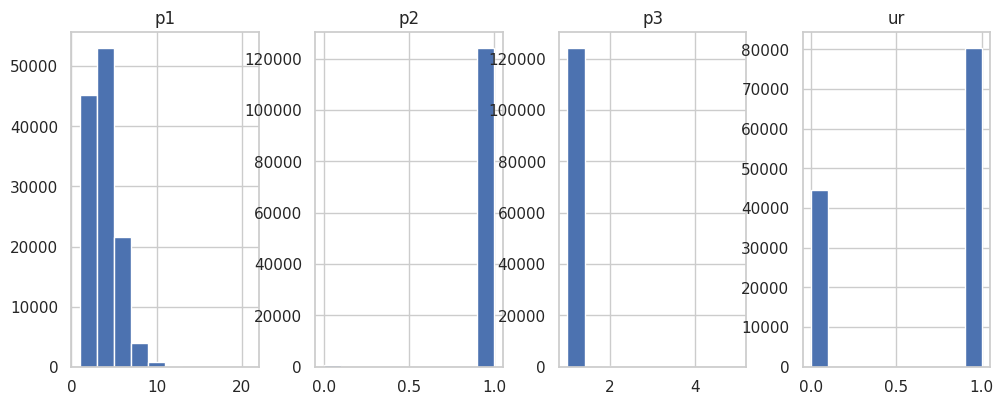

In [ ]:
df_VIVT[cols_cont + cols_dummie].hist(figsize=(15,10),layout=(2, 5));

In [ ]:
df_VIVT['p1'].value_counts()

p1
2.0     28493
3.0     26723
4.0     26295
1.0     16689
5.0     15348
6.0      6290
7.0      2720
8.0      1165
9.0       515
10.0      293
11.0      126
12.0       66
13.0       35
14.0       12
15.0        8
16.0        6
19.0        2
18.0        2
21.0        1
Name: count, dtype: int64

Tiene valores atipicos de persoanAs en una vivienda, se truncaran a 10 para que no sepierda la informacion y estan en el punto de familia numerosa

In [ ]:
df_VIVT['p1'] = np.where(df_VIVT['p1'] > 10, 10, df_VIVT['p1'])

In [ ]:
df_VIVT['p1'].value_counts()

p1
2.0     28493
3.0     26723
4.0     26295
1.0     16689
5.0     15348
6.0      6290
7.0      2720
8.0      1165
10.0      551
9.0       515
Name: count, dtype: int64

p2 y p3 tienen un fuerte desbalance pero sera importante mantener ya que en mexico el desbalance socioeconmico es bastante notorrio por lo que elimniar los atipicos quitara nos quedariamos con viviendas estadar excluyendo el analsisi el resto, pero p3 se puede quedar como binario representando 1 y 2 o mas

In [ ]:
df_VIVT['p2'].value_counts()

p2
1    124181
0       608
Name: count, dtype: int64

In [ ]:
df_VIVT['p3'] = np.where(df_VIVT['p3'] >= 2, 1, 0)

In [ ]:
df_VIVT['p3'].value_counts()

p3
0    124181
1       608
Name: count, dtype: int64

In [ ]:
df_VIVT.sample(n=10)

est  est_d_tri  t_loc_tri cve_ent    con  v_sel  n_ent   p1  p2  p3  \
35559     2        658          1   00008  40012     54      5  1.0   1   0   
42532     1        686          4   00009  40256     55      2  5.0   1   0   
131626    3       1149          3   00029  40073      4      1  2.0   1   0   
67494     3        804          3   00014  50090     69      3  5.0   1   0   
114847    3       1063          1   00025  40392     52      3  8.0   1   0   
70289     4        810          1   00015  40377     53      3  4.0   1   0   
8056      4        532          1   00002  41299     51      5  2.0   1   0   
147014    4       1233          1   00032  40163     54      5  3.0   1   0   
78291     3        874          1   00017  40051     55      5  4.0   1   0   
119328    2       1084          1   00026  50040      1      1  3.0   1   0   

        ur  tipo  mes_cal                  Map_cd_a       Map_cve_ent  
35559    1     1        1                 Chihuahua         Chihuahua  
42532    1     1        3                    México  Ciudad de México  
131626   1     1        3                  Tlaxcala          Tlaxcala  
67494    0     1        3  Complemento urbano-Rural           Jalisco  
114847   1     1        1                  Culiacán           Sinaloa  
70289    1     1        2                    México            México  
8056     1     1        1                  Mexicali   Baja California  
147014   1     1        2                 Zacatecas         Zacatecas  
78291    1     1        1                Cuernavaca           Morelos  
119328   0     1        2  Complemento urbano-Rural            Sonora

#Hogar

##Revision de columnas repetidas

In [ ]:
cols_V_H

['cve_loc',
 'cve_mun',
 'est',
 'est_d_tri',
 'est_d_men',
 'cve_ageb',
 't_loc_tri',
 't_loc_men',
 'cd_a',
 'cve_ent',
 'con',
 'upm',
 'd_sem',
 'n_pro_viv',
 'v_sel',
 'n_ent',
 'per',
 'ur',
 'tipo',
 'mes_cal',
 'fac_tri',
 'fac_men',
 'cvegeo']

In [ ]:
llaves_vivienda = ['cve_ent', 'con', 'v_sel', 'tipo']
llaves_hogar = ['cve_ent', 'con', 'v_sel', 'n_hog', 'h_mud', 'tipo']

In [ ]:
cols_a_renombrar = [col for col in df_VIVT.columns if col not in llaves_vivienda]
mapa_renombre = {col: f"{col}_viv" for col in cols_a_renombrar}
df_VIVT_prueba=df_VIVT.copy()
df_VIVT_prueba = df_VIVT_prueba.rename(columns=mapa_renombre)

cols_a_renombrar = [col for col in df_HOGT.columns if col not in llaves_hogar]
mapa_renombre = {col: f"{col}_hog" for col in cols_a_renombrar}
df_HOGT_prueba=df_HOGT.copy()
df_HOGT_prueba = df_HOGT_prueba.rename(columns=mapa_renombre)

In [ ]:
df_HOGT_prueba['cve_ent'] = df_HOGT_prueba['cve_ent'].astype(str).str.zfill(5)

In [ ]:
df_maestra = pd.merge(
    df_HOGT_prueba,
    df_VIVT_prueba,
    on=llaves_vivienda,
    #how='left'
    )

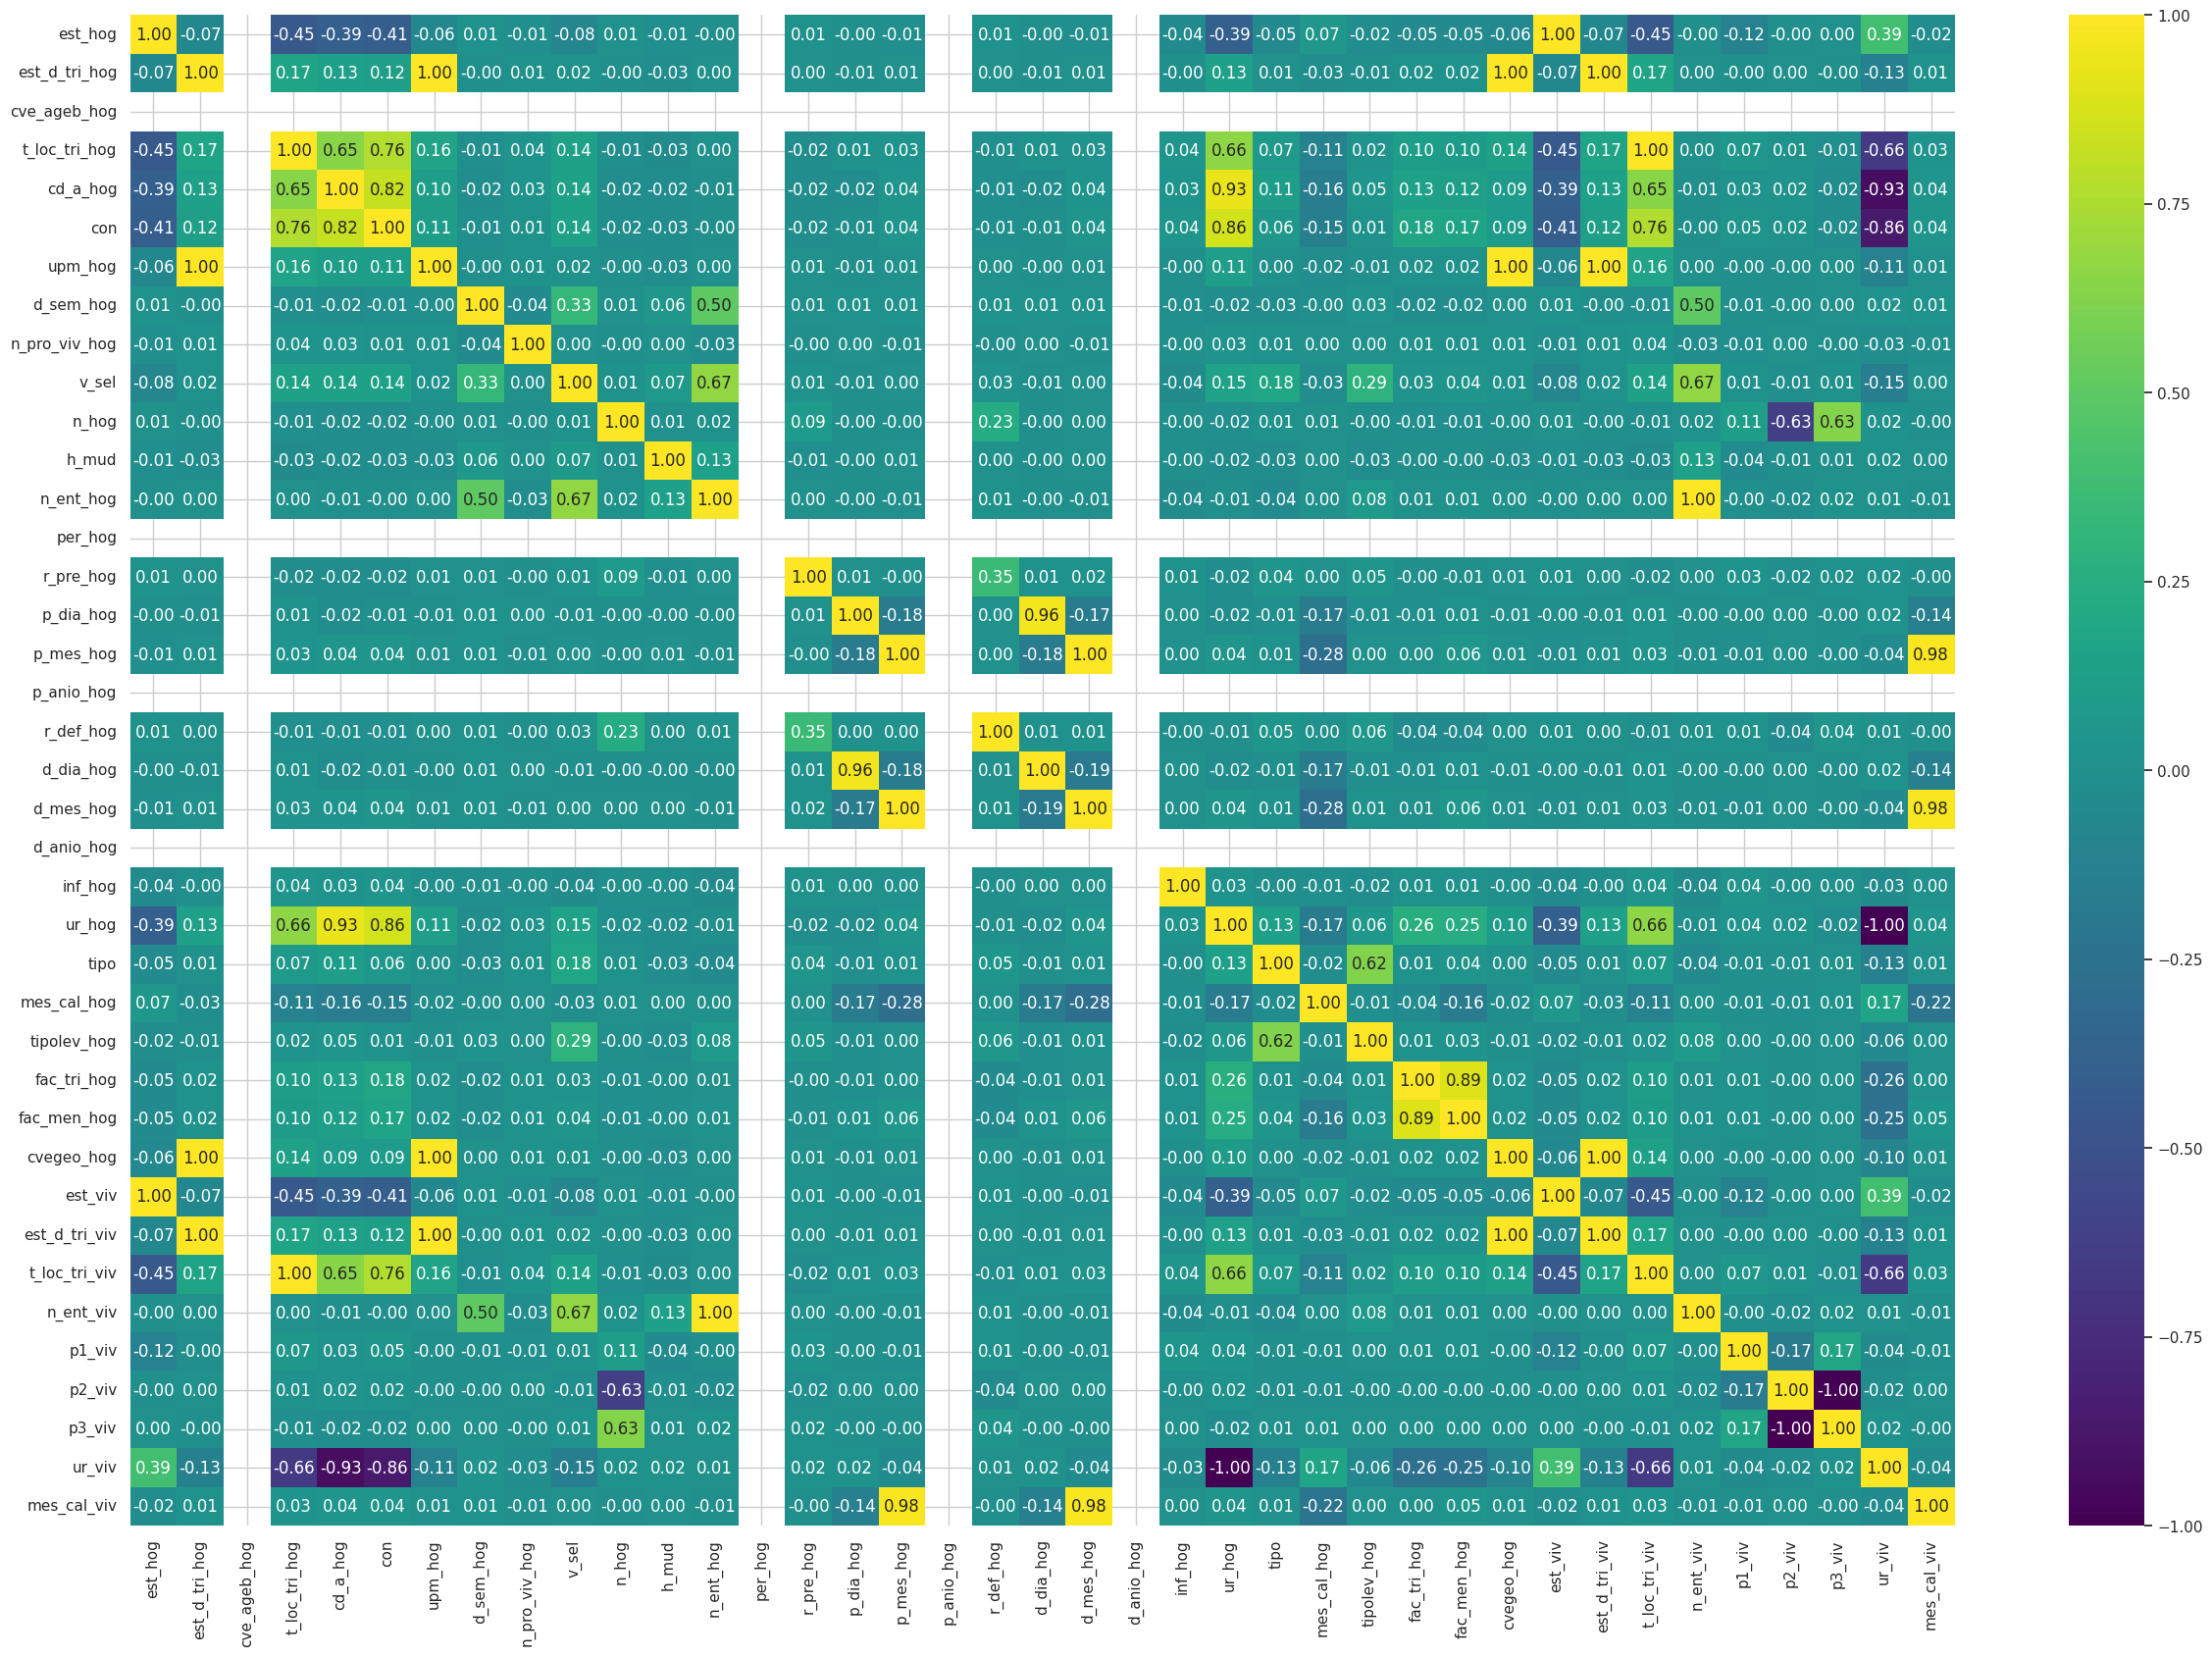

In [ ]:
plt.figure(figsize=(30,20))
sns.heatmap(df_maestra.corr(numeric_only=True), annot=True, cmap='viridis',fmt=".2f",)
plt.show()

Podemos ver como las columnas del mismo nomrbe que estan en dos columnas tienen los mismos valores, por lo que solo se encesitara analizar una vez cada

Los indices para unir se coparten pero no se deben de borrar

In [ ]:
columnas_comunes = list(set(cols_V_H) - set(llaves_hogar))
columnas_comunes

['est',
 'cve_loc',
 'cve_mun',
 'cvegeo',
 'cve_ageb',
 'est_d_tri',
 'd_sem',
 'n_pro_viv',
 't_loc_men',
 'n_ent',
 'fac_men',
 'upm',
 'mes_cal',
 'per',
 't_loc_tri',
 'fac_tri',
 'cd_a',
 'ur',
 'est_d_men']

In [ ]:
df_HOGT.drop(columnas_comunes, axis=1, inplace=True)

In [ ]:
df_HOGT

cve_ent    con  v_sel  n_hog  h_mud  r_pre  p_dia  p_mes  p_anio  \
0             1  40001     51      1      0      0     17      9      25   
1             1  40001     52      1      0      0     17      9      25   
2             1  40001     53      1      0      0     17      9      25   
3             1  40001     54      1      0      0     18      9      25   
4             1  40001     55      1      0      0     17      9      25   
...         ...    ...    ...    ...    ...    ...    ...    ...     ...   
151349       32  60078     66      1      0      0     10      7      25   
151350       32  60078     67      1      0      0     10      7      25   
151351       32  60078     68      1      0      0     10      7      25   
151352       32  60078     69      1      0      0     10      7      25   
151353       32  60078     70      1      0      0     10      7      25   

        r_def  d_dia  d_mes  d_anio e_obs p4_1 p4_2  inf  tipo  tipolev  
0           0     17      9      25     2    4         4     1        1  
1           0     17      9      25     2    4         1     1        1  
2           0     17      9      25     2    4         2     1        1  
3           0     18      9      25     2    4         2     1        1  
4           0     17      9      25     2    4         2     1        1  
...       ...    ...    ...     ...   ...  ...  ...  ...   ...      ...  
151349      0     10      7      25     2    4         1     1        1  
151350      0     10      7      25     2    4         2     1        1  
151351      0     10      7      25     2    4         1     1        1  
151352      0     10      7      25     2    4         2     1        1  
151353      0     10      7      25     2    4         2     1        1  

[151354 rows x 19 columns]

##cve_ent: Clave numérica de la entidad federativa (estado) donde se ubica la vivienda.

Solo hay que igualar al resto de las tablas

In [ ]:
df_HOGT['cve_ent'] = df_HOGT['cve_ent'].astype(str).str.zfill(5)

##con: Clave de control interno de la muestra.

Se deja tal como esta al ser un indice

##v_sel: Número de la vivienda seleccionada.

Se deja tal como esta al ser un indice

##n_hog: Número de hogar dentro de la vivienda

In [ ]:
df_HOGT['n_hog'].unique()

array([1, 2, 3, 4, 5])

In [ ]:
df_HOGT['n_hog'].value_counts()

n_hog
1    150397
2       773
3       142
4        37
5         5
Name: count, dtype: int64

In [ ]:
obtener_catalogo(hog,'n_hog')

cve                                        descrip
0    1          Hogar principal dentro de la vivienda
1    2   Primer hogar adicional dentro de la vivienda
2    3  Segundo hogar adicional dentro de la vivienda
3    4   Tercer hogar adicional dentro de la vivienda
4    5   Cuarto hogar adicional dentro de la vivienda
5    6   Quinto hogar adicional dentro de la vivienda
6    7    Sexto hogar adicional dentro de la vivienda
7    8  Séptimo hogar adicional dentro de la vivienda
8    9   Octavo hogar adicional dentro de la vivienda

In [ ]:
df_HOGT['n_hog'].isnull().sum()

np.int64(0)

En su estado esta de forma ordinal por lo que se queda tal como esta

##h_mud: Número de veces que el hogar se ha mudado (variable de seguimiento).

In [ ]:
df_HOGT['h_mud'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
df_HOGT['h_mud'].value_counts()

h_mud
0    146701
1      4176
2       436
3        38
4         3
Name: count, dtype: int64

In [ ]:
df_HOGT['h_mud'].isnull().sum()

np.int64(0)

##Prelimnares

- r_pre: Resultado preliminar de la entrevista (ej. Entrevista completa, Nadie en casa, Se negó a dar información, etc.).
- p_dia: Día de referencia del resultado preliminar (01-31).
- p_mes: Mes de referencia del resultado preliminar (01-12).
- p_anio: Año de referencia del resultado preliminar (00-99).

Al ser prelimnares no nos dice cual fue el resultado de la entrevista

Esta columna no nos servira ya que solo fue la preliminar, el resultado definitivo (r_def) es el estatus final y validado del registro, por lo que es la columna correcta para definir nuestra Población Objetivo de hogares entrevistados.

In [ ]:
df_HOGT.drop('r_pre', axis=1, inplace=True)
df_HOGT.drop('p_dia', axis=1, inplace=True)
df_HOGT.drop('p_mes', axis=1, inplace=True)
df_HOGT.drop('p_anio', axis=1, inplace=True)

##Definitivos

- r_def: Resultado definitivo de la entrevista (similar a r_pre pero final).
- d_dia: Día del resultado definitivo (01-31).
- d_mes: Mes del resultado definitivo (01-12).
- d_anio: Año del resultado definitivo (00-99).


In [ ]:
df_HOGT['r_def'].unique()

array([ 0,  2,  7,  3,  6,  8,  1,  5,  4, 15, 12,  9, 18, 17, 10, 13, 14])

In [ ]:
obtener_catalogo(hog,'r_def')

cve                                                    descrip
0     0                                        Entrevista completa
1     1                       Nadie en el momento de la entrevista
2     2                                           Ausente temporal
3     3                                  Se negó a dar información
4     4                                      Informante inadecuado
5     5                                                Otro motivo
6     6                                    Adecuada para habitarse
7     7                                            De uso temporal
8     8                                  Inadecuada para habitarse
9     9  De uso temporal para fines diferentes a los de habitación
10   10                                                   Demolida
11   11                                    Cambió de sitio (móvil)
12   12   Uso permanente para fines diferentes a los de habitación
13   13                                                Otro motivo
14   14                                           El hogar se mudó
15   15                                      Entrevista suspendida

In [ ]:
df_HOGT['r_def'].value_counts()*100/df_HOGT.shape[0]

r_def
0     82.723284
3      4.365263
6      3.368262
1      3.069625
7      2.491510
2      1.456850
5      0.992375
17     0.326387
9      0.269567
8      0.203496
12     0.181033
15     0.149980
4      0.122891
14     0.093820
13     0.077963
18     0.062106
10     0.045588
Name: count, dtype: float64

Como necesitamos datos solo se tomaran las viviendas donde se completo la entrevista

In [ ]:
df_HOGT = df_HOGT[df_HOGT['r_def']== 0]

In [ ]:
df_HOGT['r_def'].value_counts()*100/df_HOGT.shape[0]

r_def
0    100.0
Name: count, dtype: float64

Y se elimnara ya que solo fue para filtrar y no tiene variabilidad

In [ ]:
df_HOGT.drop('r_def', axis=1, inplace=True)

El resto de variable de definitivas son ruido administrativo que no ayuda a describir el perfil del hogar, solo fueron utilies para saver cuando se hacen las entrevistas

In [ ]:
df_HOGT.drop('d_dia', axis=1, inplace=True)
df_HOGT.drop('d_mes', axis=1, inplace=True)
df_HOGT.drop('d_anio', axis=1, inplace=True)

##e_obs: Entrevista observada (1=Sí, 2=No).

In [ ]:
df_HOGT['e_obs'].unique()

array(['2', '1'], dtype=object)

In [ ]:
obtener_catalogo(hog,'e_obs')

cve descrip
0    1      Sí
1    2      No

In [ ]:
df_HOGT['e_obs'].value_counts()

e_obs
2    121625
1      3580
Name: count, dtype: int64

In [ ]:
df_HOGT['e_obs']=df_HOGT['e_obs'].map({'1': 1, '2': 0})

In [ ]:
df_HOGT['e_obs'].value_counts()


e_obs
0    121625
1      3580
Name: count, dtype: int64

##p4_1: Pregunta 4: Indica si en este hogar se contratan trabajadores domésticos (Entrada/Salida, Planta, Ambos, No contrata).

In [ ]:
df_HOGT['p4_1'].unique()

array(['4', '1', '2', '3'], dtype=object)

In [ ]:
obtener_catalogo(hog,'p4_1')

cve                              descrip
0    1               de entrada por salida?
1    2                           de planta?
2    3   de entrada por salida y de planta?
3    4  No contrata trabajadores domésticos

In [ ]:
df_HOGT['p4_1'].value_counts()

p4_1
4    119890
1      5156
2       152
3         7
Name: count, dtype: int64

In [ ]:
df_HOGT['p4_1'].value_counts()*100/df_HOGT.shape[0]

p4_1
4    95.754962
1     4.118046
2     0.121401
3     0.005591
Name: count, dtype: float64

la respuesta representa cierto nivel economico por lo que se puede organizar de forma oridinal

In [ ]:
mapeo = {'4': 0, '1': 1, '2': 2, '3': 3}

In [ ]:
df_HOGT['p4_1'] = df_HOGT['p4_1'].map(mapeo)

##p4_2: Número de trabajadores domésticos contratados.

In [ ]:
df_HOGT['p4_2'].unique()

array([' ', '1', '2', '3', '4', '6'], dtype=object)

In [ ]:
df_HOGT['p4_2'].value_counts()

p4_2
     119890
1      5061
2       215
3        30
4         6
6         3
Name: count, dtype: int64

Aquellos que reoondieron no tener trabajadores se quedo vacio, al ser informacion se marcara como 0

In [ ]:
df_HOGT[df_HOGT['p4_1']==0]['p4_2'].unique()

array([' '], dtype=object)

In [ ]:
df_HOGT.loc[df_HOGT['p4_1'] == 0, 'p4_2'] = '0'

In [ ]:
df_HOGT['p4_2'].unique()

array(['0', '1', '2', '3', '4', '6'], dtype=object)

In [ ]:
df_HOGT[df_HOGT['p4_1']==0]['p4_2'].unique()

array(['0'], dtype=object)

In [ ]:
df_HOGT['p4_2']=df_HOGT['p4_2'].astype(float)

In [ ]:
df_HOGT['p4_2'].value_counts()

p4_2
0.0    119890
1.0      5061
2.0       215
3.0        30
4.0         6
6.0         3
Name: count, dtype: int64

In [ ]:
df_HOGT['p4_2'].isnull().sum()

np.int64(0)

##inf: Renglón del informante (Número de renglón de la persona que proporcionó la información).

In [ ]:
df_HOGT['inf'].value_counts()

inf
1     63048
2     44985
3      8605
4      3593
97     2135
5      1406
6       552
99      409
7       252
8       120
9        58
10       25
11        7
12        5
14        2
13        2
17        1
Name: count, dtype: int64

In [ ]:
obtener_catalogo(hog,'inf')

cve                              descrip
0     1           Renglón del informante uno
1     2           Renglón del informante dos
2     3          Renglón del informante tres
3     4        Renglón del informante cuatro
4     5         Renglón del informante cinco
5     6          Renglón del informante seis
6     7         Renglón del informante siete
7     8          Renglón del informante ocho
8     9         Renglón del informante nueve
9    10          Renglón del informante diez
10   11          Renglón del informante once
11   12          Renglón del informante doce
12   13         Renglón del informante trece
13   14       Renglón del informante catorce
14   15        Renglón del informante quince
15   16     Renglón del informante dieciséis
16   17    Renglón del informante diecisiete
17   18     Renglón del informante dieciocho
18   19    Renglón del informante diecinueve
19   20        Renglón del informante veinte
20   21     Renglón del informante veintiuno
21   22     Renglón del informante veintidós
22   23    Renglón del informante veintitrés
23   24  Renglón del informante veinticuatro
24   25   Renglón del informante veinticinco
25   26    Renglón del informante veintiséis
26   27   Renglón del informante veintisiete
27   28    Renglón del informante veintiocho
28   29   Renglón del informante veintinueve
29   30       Renglón del informante treinta
30   97                 Más de un informante
31   99                      No especificado

Solo indica quién respondió la encuesta pero no atributos.

In [ ]:
df_HOGT.drop('inf', axis=1, inplace=True)

##tipo: Tipo de muestra (1=ENOE, 2=ENOE-CATI).

Es un indice por lo que se dejara como esta

##tipolev: Tipo de levantamiento de la entrevista (1=Presencial, 2=Telefónico).

In [ ]:
df_HOGT['tipolev'].value_counts()

tipolev
1    120710
2      4495
Name: count, dtype: int64

In [ ]:
obtener_catalogo(hog,'tipolev')

cve     descrip
0    1  Presencial
1    2  Telefónico

In [ ]:
df_HOGT['tipolev']=df_HOGT['tipolev'].map({1: 1, 2: 0})

In [ ]:
df_HOGT.isnull().sum()

cve_ent    0
con        0
v_sel      0
n_hog      0
h_mud      0
e_obs      0
p4_1       0
p4_2       0
tipo       0
tipolev    0
dtype: int64

##Clasificacion de columnas

In [ ]:
cols_ordinal.append('p4_1')
cols_cont.append('p4_2')
cols_cont.append('e_obs')
cols_cont.append('tipo_lev')

In [ ]:
df_HOGT

cve_ent    con  v_sel  n_hog  h_mud  e_obs  p4_1  p4_2  tipo  tipolev
0        00001  40001     51      1      0      0     0   0.0     1        1
1        00001  40001     52      1      0      0     0   0.0     1        1
2        00001  40001     53      1      0      0     0   0.0     1        1
3        00001  40001     54      1      0      0     0   0.0     1        1
4        00001  40001     55      1      0      0     0   0.0     1        1
...        ...    ...    ...    ...    ...    ...   ...   ...   ...      ...
151349   00032  60078     66      1      0      0     0   0.0     1        1
151350   00032  60078     67      1      0      0     0   0.0     1        1
151351   00032  60078     68      1      0      0     0   0.0     1        1
151352   00032  60078     69      1      0      0     0   0.0     1        1
151353   00032  60078     70      1      0      0     0   0.0     1        1

[125205 rows x 10 columns]

##Unir Vivienda y hogar

In [ ]:
cols_H_indice=['cve_ent', 'con', 'v_sel', 'tipo']

In [ ]:
cols_H_indice

['cve_ent', 'con', 'v_sel', 'tipo']

In [ ]:
print(df_VIVT.shape)
print(df_HOGT.shape)

(124789, 15)
(125205, 10)


In [ ]:
print(df_VIVT.columns)
print(df_HOGT.columns)

Index(['est', 'est_d_tri', 't_loc_tri', 'cve_ent', 'con', 'v_sel', 'n_ent',
       'p1', 'p2', 'p3', 'ur', 'tipo', 'mes_cal', 'Map_cd_a', 'Map_cve_ent'],
      dtype='object')
Index(['cve_ent', 'con', 'v_sel', 'n_hog', 'h_mud', 'e_obs', 'p4_1', 'p4_2',
       'tipo', 'tipolev'],
      dtype='object')


In [ ]:
df_maestra = pd.merge(
    df_HOGT,
    df_VIVT,
    on=cols_H_indice,
    how='left')

In [ ]:
df_maestra.isnull().sum()

cve_ent        0
con            0
v_sel          0
n_hog          0
h_mud          0
e_obs          0
p4_1           0
p4_2           0
tipo           0
tipolev        0
est            2
est_d_tri      2
t_loc_tri      2
n_ent          2
p1             2
p2             2
p3             2
ur             2
mes_cal        2
Map_cd_a       2
Map_cve_ent    2
dtype: int64

In [ ]:
df_maestra.isnull().sum() * 100 / df_maestra.shape[0]

cve_ent        0.000000
con            0.000000
v_sel          0.000000
n_hog          0.000000
h_mud          0.000000
e_obs          0.000000
p4_1           0.000000
p4_2           0.000000
tipo           0.000000
tipolev        0.000000
est            0.001597
est_d_tri      0.001597
t_loc_tri      0.001597
n_ent          0.001597
p1             0.001597
p2             0.001597
p3             0.001597
ur             0.001597
mes_cal        0.001597
Map_cd_a       0.001597
Map_cve_ent    0.001597
dtype: float64

Se tuvieron 2 hogares sin vivienda que represetane el 0.0016% por lo que se imputaran

In [ ]:
nulos = df_maestra[df_maestra['est'].isna()]

In [ ]:
nulos

cve_ent    con  v_sel  n_hog  h_mud  e_obs  p4_1  p4_2  tipo  tipolev  \
74981    00019  40602     53      1      2      0     0   0.0     1        1   
109142   00028  60004     61      2      0      0     0   0.0     1        1   

        est  est_d_tri  t_loc_tri  n_ent  p1  p2  p3  ur  mes_cal Map_cd_a  \
74981   NaN        NaN        NaN    NaN NaN NaN NaN NaN      NaN      NaN   
109142  NaN        NaN        NaN    NaN NaN NaN NaN NaN      NaN      NaN   

       Map_cve_ent  
74981          NaN  
109142         NaN

In [ ]:
df_maestra = pd.merge(df_VIVT,df_HOGT, on=cols_H_indice, how='inner')

In [ ]:
df_maestra.isnull().sum() * 100 / df_maestra.shape[0]

est            0.0
est_d_tri      0.0
t_loc_tri      0.0
cve_ent        0.0
con            0.0
v_sel          0.0
n_ent          0.0
p1             0.0
p2             0.0
p3             0.0
ur             0.0
tipo           0.0
mes_cal        0.0
Map_cd_a       0.0
Map_cve_ent    0.0
n_hog          0.0
h_mud          0.0
e_obs          0.0
p4_1           0.0
p4_2           0.0
tipolev        0.0
dtype: float64

In [ ]:
df_maestra

est  est_d_tri  t_loc_tri cve_ent    con  v_sel  n_ent   p1  p2  p3  \
0         1        501          1   00001  40001     51      5  8.0   1   0   
1         1        501          1   00001  40001     52      5  1.0   1   0   
2         1        501          1   00001  40001     53      5  6.0   1   0   
3         1        501          1   00001  40001     54      5  4.0   1   0   
4         1        501          1   00001  40001     55      5  4.0   1   0   
...     ...        ...        ...     ...    ...    ...    ...  ...  ..  ..   
125198    2       1244          4   00032  60078     66      5  2.0   1   0   
125199    2       1244          4   00032  60078     67      5  5.0   1   0   
125200    2       1244          4   00032  60078     68      5  5.0   1   0   
125201    2       1244          4   00032  60078     69      5  3.0   1   0   
125202    2       1244          4   00032  60078     70      5  2.0   1   0   

        ur  tipo  mes_cal                  Map_cd_a     Map_cve_ent  n_hog  \
0        1     1        3            Aguascalientes  Aguascalientes      1   
1        1     1        3            Aguascalientes  Aguascalientes      1   
2        1     1        3            Aguascalientes  Aguascalientes      1   
3        1     1        3            Aguascalientes  Aguascalientes      1   
4        1     1        3            Aguascalientes  Aguascalientes      1   
...     ..   ...      ...                       ...             ...    ...   
125198   0     1        1  Complemento urbano-Rural       Zacatecas      1   
125199   0     1        1  Complemento urbano-Rural       Zacatecas      1   
125200   0     1        1  Complemento urbano-Rural       Zacatecas      1   
125201   0     1        1  Complemento urbano-Rural       Zacatecas      1   
125202   0     1        1  Complemento urbano-Rural       Zacatecas      1   

        h_mud  e_obs  p4_1  p4_2  tipolev  
0           0      0     0   0.0        1  
1           0      0     0   0.0        1  
2           0      0     0   0.0        1  
3           0      0     0   0.0        1  
4           0      0     0   0.0        1  
...       ...    ...   ...   ...      ...  
125198      0      0     0   0.0        1  
125199      0      0     0   0.0        1  
125200      0      0     0   0.0        1  
125201      0      0     0   0.0        1  
125202      0      0     0   0.0        1  

[125203 rows x 21 columns]

In [ ]:
df_maestra.sample(n=10)

est  est_d_tri  t_loc_tri cve_ent    con  v_sel  n_ent   p1  p2  p3  \
20774     2        608          1   00006  40101     51      4  2.0   1   0   
9418      4        550          1   00003  40278     52      2  2.0   1   0   
12180     4        567          1   00004  40283     53      2  4.0   1   0   
28529     1        653          3   00007  50103     19      1  3.0   1   0   
95687     4       1064          1   00025  40323     55      4  4.0   1   0   
123139    4       1233          1   00032  40315     52      3  4.0   1   0   
77792     2        954          3   00020  40382     51      4  5.0   1   0   
7757      1        541          3   00002  50109     54      3  2.0   1   0   
13027     2        571          1   00004  41111     55      2  2.0   1   0   
12037     3        566          1   00004  40252     54      2  2.0   1   0   

        ur  tipo  mes_cal                  Map_cd_a          Map_cve_ent  \
20774    1     1        3                    Colima               Colima   
9418     1     1        1                    La Paz  Baja California Sur   
12180    1     1        1                  Campeche             Campeche   
28529    0     1        2  Complemento urbano-Rural              Chiapas   
95687    1     1        1                  Culiacán              Sinaloa   
123139   1     1        3                 Zacatecas            Zacatecas   
77792    1     1        2                    Oaxaca               Oaxaca   
7757     0     1        1  Complemento urbano-Rural      Baja California   
13027    1     1        1         Ciudad del Carmen             Campeche   
12037    1     1        1                  Campeche             Campeche   

        n_hog  h_mud  e_obs  p4_1  p4_2  tipolev  
20774       1      0      0     0   0.0        1  
9418        1      0      0     0   0.0        1  
12180       1      0      0     0   0.0        1  
28529       1      0      0     0   0.0        1  
95687       1      0      0     0   0.0        1  
123139      1      0      0     0   0.0        1  
77792       1      0      1     0   0.0        1  
7757        1      0      0     0   0.0        1  
13027       1      0      0     0   0.0        1  
12037       1      0      0     0   0.0        1

#Sociodemográfico

##Revision de columnas repetidas

In [ ]:
cols_H_E

['cve_loc',
 'cve_mun',
 'est',
 'est_d_tri',
 'est_d_men',
 'cve_ageb',
 't_loc_tri',
 't_loc_men',
 'cd_a',
 'cve_ent',
 'con',
 'upm',
 'd_sem',
 'n_pro_viv',
 'v_sel',
 'n_hog',
 'h_mud',
 'n_ent',
 'per',
 'r_def',
 'ur',
 'tipo',
 'mes_cal',
 'fac_tri',
 'fac_men',
 'cvegeo']

In [ ]:
llaves_Persona = ['cve_ent', 'con', 'v_sel', 'n_hog', 'h_mud', 'n_ren','tipo']

In [ ]:
columnas_comunes = list(set(cols_H_E) - set(llaves_Persona))
columnas_comunes

['r_def',
 'est',
 'cve_loc',
 'cve_mun',
 'cvegeo',
 'cve_ageb',
 'est_d_tri',
 'd_sem',
 'n_pro_viv',
 't_loc_men',
 'n_ent',
 'fac_men',
 'upm',
 'mes_cal',
 'per',
 't_loc_tri',
 'fac_tri',
 'cd_a',
 'ur',
 'est_d_men']

In [ ]:
df_SDMET.drop(columnas_comunes, axis=1, inplace=True)

In [ ]:
df_SDMET.columns

Index(['cve_ent', 'con', 'v_sel', 'n_hog', 'h_mud', 'n_ren', 'c_res', 'par_c',
       'sex', 'eda', 'nac_dia', 'nac_mes', 'nac_anio', 'l_nac_c', 'cs_p12',
       'cs_p13_1', 'cs_p13_2', 'cs_p14_c', 'cs_p15', 'cs_p16', 'cs_p17',
       'n_hij', 'e_con', 'cs_p20a_1', 'cs_p20a_c', 'cs_p20b_1', 'cs_p20b_c',
       'cs_p20c_1', 'cs_ad_mot', 'cs_p21_des', 'cs_ad_des', 'cs_nr_mot',
       'cs_p23_des', 'cs_nr_ori', 'zona', 'salario', 'clase1', 'clase2',
       'clase3', 'pos_ocu', 'seg_soc', 'rama', 'c_ocu11c', 'ing7c', 'dur9c',
       'emple7c', 'medica5c', 'buscar5c', 'rama_est1', 'rama_est2', 'dur_est',
       'ambito1', 'ambito2', 'tue1', 'tue2', 'tue3', 'busqueda', 'd_ant_lab',
       'd_cexp_est', 'dur_des', 'sub_o', 's_clasifi', 'remune2c', 'pre_asa',
       'tip_con', 'dispo', 'nodispo', 'c_inac5c', 'pnea_est', 'niv_ins',
       'eda5c', 'eda7c', 'eda12c', 'eda19c', 'hij5c', 'domestico', 'anios_esc',
       'hrsocup', 'ingocup', 'ing_x_hrs', 'tpg_p8a', 'tcco', 'cp_anoc',
       'imssi

##n_ren: Número de renglón del integrante del hogar (ID de la persona).

Es el Id que relaciona a la pesona son la encuesta

##par_c: Clave de parentesco con el jefe(a) del hogar.

In [ ]:
obtener_catalogo(sdem,'par_c')

cve                                      descrip
0   101                                      Jefa(e)
1   201                                    Esposa(o)
2   202                   Concubina(o) o unión libre
3   203                          Amante o querida(o)
4   301                                      Hija(o)
5   302                          Hija(o) adoptiva(o)
6   303                                  Hijastra(o)
7   304                           Hija(o) de crianza
8   401                                Madre o padre
9   402                        Madrastra o padrastro
10  403                                   Hermana(o)
11  404                          Media(o) hermana(o)
12  405                               Hermanastra(o)
13  406                                    Abuela(o)
14  407                Bisabuela(o) o tatarabuela(o)
15  408                                     Nieta(o)
16  409                                 Nietastra(o)
17  410                        Esposa(o) de nieto(a)
18  411                 Bisnieta(o) o tataranieta(o)
19  412                                       Tía(o)
20  413                                   Sobrina(o)
21  414                          Sobrina(o) nieta(o)
22  415                                     Prima(o)
23  416                                    Suegra(o)
24  417                                 Consuegra(o)
25  418                                Nuera o yerno
26  419                                    Cuñada(o)
27  420                                   Concuña(o)
28  421                            Madrina o padrino
29  422                                   Ahijada(o)
30  423                           Comadre o compadre
31  424                             Otros familiares
32  501                               Sin parentesco
33  502                                     Tutor(a)
34  503                                  Tutelada(o)
35  601                   Trabajador(a) doméstico(a)
36  611      Esposa(o) de trabajador(a) doméstico(a)
37  612        Hija(o) de trabajador(a) doméstico(a)
38  613  Otro pariente de trabajador(a) doméstico(a)
39  701                                      Huésped
40  999                   Parentesco no especificado

In [ ]:
values_can_porcentaje(df_SDMET,'par_c')

Cantidad  Porcentaje
par_c                      
301      148598   35.187281
101      125432   29.701686
201       64632   15.304542
408       29516    6.989245
202       10296    2.438043
           9874    2.338115
418        7631    1.806984
403        5453    1.291244
401        4262    1.009221
413        3514    0.832098
303        3035    0.718673
501        1784    0.422442
416        1704    0.403499
419        1337    0.316595
302        1108    0.262369
411        1066    0.252424
415         476    0.112714
409         413    0.097796
414         408    0.096612
412         399    0.094481
304         201    0.047596
406         192    0.045465
424         175    0.041439
601         172    0.040729
999         116    0.027468
410          87    0.020601
402          82    0.019417
420          80    0.018944
404          51    0.012077
203          47    0.011129
701          38    0.008998
422          34    0.008051
417          28    0.006630
423          21    0.004973
405          20    0.004736
421           7    0.001658
502           7    0.001658
407           5    0.001184
612           4    0.000947
503           1    0.000237

Hay mucha cardinalidad pero podemos usar el [documento del inegi](https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/nueva_estruc/702825197278.pdf) que clasifica esto, el 100 es el jefe, el 200 es la pareja, 300 el hijo, 400 el otro parentesco, el 500 sin parentesco, el 600 del trabajador domestico, 700 que es el huesped y 900 que se desconoce.

In [ ]:
df_SDMET['par_c'] = df_SDMET['par_c'].apply(agrupar_parentesco)

In [ ]:
values_can_porcentaje(df_SDMET,'par_c')

Cantidad  Porcentaje
par_c                                     
Hijos_Nietos            183937   43.555384
Jefe_Hogar              125432   29.701686
Conyuge_Pareja           74975   17.753714
Familia_Extensa          25966    6.148622
Error                     9874    2.338115
Sin_Parentesco            1946    0.460803
Trabajador_Domestico       176    0.041676

El asunto de los nulos se analizara mas adelante

##sex: Sexo (1=Hombre, 2=Mujer).


In [ ]:
values_can_porcentaje(df_SDMET,'sex')

Cantidad  Porcentaje
sex                      
2      215099   50.934394
1      197333   46.727491
         9874    2.338115

In [ ]:
df_SDMET['sex']=df_SDMET['sex'].replace(' ', np.nan).astype(float)

analizando los datos parece que eas personas tiene nulos en el resto de las columnas, todo ellos se acumulan en C_res con valor 2 que significa Ausente definitivo

In [ ]:
for col in df_SDMET.columns:
  display(df_SDMET[df_SDMET['sex'].isnull()][col].value_counts())



cve_ent
7     613
30    534
5     442
8     403
20    395
11    360
4     354
2     350
10    332
27    322
23    320
14    319
28    315
24    309
26    302
1     295
16    295
12    292
19    290
25    288
29    281
6     279
18    279
32    258
13    252
21    245
3     221
31    220
15    217
9     200
17    176
22    116
Name: count, dtype: int64

con
60014    45
60030    43
60024    41
60002    41
60007    40
         ..
41206     1
59        1
40488     1
41179     1
42111     1
Name: count, Length: 1246, dtype: int64

v_sel
53    1536
55    1430
54    1408
51    1393
52    1391
65     165
64     144
61     141
66     139
70     135
68     134
60     134
63     134
67     131
59     130
69     128
57     127
62     122
56     119
58     115
77     114
76      96
79      91
78      85
75      53
80      40
81      31
90      25
82      25
88      18
84      18
94      17
86      17
89      15
85      15
92      14
83      13
87      11
91       8
93       5
71       5
72       2
Name: count, dtype: int64

n_hog
1    9861
2      13
Name: count, dtype: int64

h_mud
0    9624
1     234
2      15
3       1
Name: count, dtype: int64

n_ren
3     2501
4     1752
2     1725
5     1155
1     1018
6      788
7      407
8      243
9      131
10      80
11      39
12      16
13       8
14       4
15       4
16       1
17       1
18       1
Name: count, dtype: int64

c_res
2    9874
Name: count, dtype: int64

par_c
Error    9874
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

eda
    9874
Name: count, dtype: int64

nac_dia
    9874
Name: count, dtype: int64

nac_mes
    9874
Name: count, dtype: int64

nac_anio
    9874
Name: count, dtype: int64

l_nac_c
    9874
Name: count, dtype: int64

cs_p12
    9874
Name: count, dtype: int64

cs_p13_1
    9874
Name: count, dtype: int64

cs_p13_2
    9874
Name: count, dtype: int64

cs_p14_c
    9874
Name: count, dtype: int64

cs_p15
    9874
Name: count, dtype: int64

cs_p16
    9874
Name: count, dtype: int64

cs_p17
    9874
Name: count, dtype: int64

n_hij
    9874
Name: count, dtype: int64

e_con
    9874
Name: count, dtype: int64

cs_p20a_1
    9874
Name: count, dtype: int64

cs_p20a_c
    9874
Name: count, dtype: int64

cs_p20b_1
    9874
Name: count, dtype: int64

cs_p20b_c
    9874
Name: count, dtype: int64

cs_p20c_1
    9874
Name: count, dtype: int64

cs_ad_mot
6     2945
1     1559
10    1542
9     1326
3      968
4      633
8      401
2      391
5       55
99      43
7       11
Name: count, dtype: int64

cs_p21_des
                                  8332
CAMBIO DE DOMICILIO                199
SE INDEPENDIZO                     126
SE INDEPENDIZË                      69
CAMBIË DE DOMICILIO                 58
                                  ... 
LOS DATOS EST-N MAL                  1
ES DEL HOGAR 2                       1
DEJO DE RENTAR EN EL DOMICILIO       1
ES OTRA VIVIENDA A UN LADO           1
CAMBIË DE LEGAR DE RESIDENCIA        1
Name: count, Length: 583, dtype: int64

cs_ad_des
1    6568
     1727
2    1233
3     273
9      73
Name: count, dtype: int64

cs_nr_mot
    9874
Name: count, dtype: int64

cs_p23_des
    9874
Name: count, dtype: int64

cs_nr_ori
    9874
Name: count, dtype: int64

zona
2    9109
1     765
Name: count, dtype: int64

salario
8364     9109
12596     765
Name: count, dtype: int64

clase1
0    9874
Name: count, dtype: int64

clase2
0    9874
Name: count, dtype: int64

clase3
0    9874
Name: count, dtype: int64

pos_ocu
0    9874
Name: count, dtype: int64

seg_soc
0    9874
Name: count, dtype: int64

rama
0    9874
Name: count, dtype: int64

c_ocu11c
0    9874
Name: count, dtype: int64

ing7c
0    9874
Name: count, dtype: int64

dur9c
0    9874
Name: count, dtype: int64

emple7c
0    9874
Name: count, dtype: int64

medica5c
0    9874
Name: count, dtype: int64

buscar5c
0    9874
Name: count, dtype: int64

rama_est1
0    9874
Name: count, dtype: int64

rama_est2
0    9874
Name: count, dtype: int64

dur_est
0    9874
Name: count, dtype: int64

ambito1
0    9874
Name: count, dtype: int64

ambito2
0    9874
Name: count, dtype: int64

tue1
0    9874
Name: count, dtype: int64

tue2
0    9874
Name: count, dtype: int64

tue3
0    9874
Name: count, dtype: int64

busqueda
0    9874
Name: count, dtype: int64

d_ant_lab
0    9874
Name: count, dtype: int64

d_cexp_est
0    9874
Name: count, dtype: int64

dur_des
0    9874
Name: count, dtype: int64

sub_o
0    9874
Name: count, dtype: int64

s_clasifi
0    9874
Name: count, dtype: int64

remune2c
0    9874
Name: count, dtype: int64

pre_asa
0    9874
Name: count, dtype: int64

tip_con
0    9874
Name: count, dtype: int64

dispo
0    9874
Name: count, dtype: int64

nodispo
0    9874
Name: count, dtype: int64

c_inac5c
0    9874
Name: count, dtype: int64

pnea_est
0    9874
Name: count, dtype: int64

niv_ins
0    9874
Name: count, dtype: int64

eda5c
0    9874
Name: count, dtype: int64

eda7c
0    9874
Name: count, dtype: int64

eda12c
0    9874
Name: count, dtype: int64

eda19c
0    9874
Name: count, dtype: int64

hij5c
0    9874
Name: count, dtype: int64

domestico
0    9874
Name: count, dtype: int64

anios_esc
0    9874
Name: count, dtype: int64

hrsocup
0    9874
Name: count, dtype: int64

ingocup
0    9874
Name: count, dtype: int64

ing_x_hrs
0.0    9874
Name: count, dtype: int64

tpg_p8a
0    9874
Name: count, dtype: int64

tcco
0    9874
Name: count, dtype: int64

cp_anoc
0    9874
Name: count, dtype: int64

imssissste
0    9874
Name: count, dtype: int64

ma48me1sm
0    9874
Name: count, dtype: int64

p14apoyos
0    9874
Name: count, dtype: int64

scian
0    9874
Name: count, dtype: int64

t_tra
0    9874
Name: count, dtype: int64

emp_ppal
0    9874
Name: count, dtype: int64

tue_ppal
0    9874
Name: count, dtype: int64

trans_ppal
0    9874
Name: count, dtype: int64

mh_fil2
0    9874
Name: count, dtype: int64

mh_col
0    9874
Name: count, dtype: int64

sec_ins
0    9874
Name: count, dtype: int64

tipo
1    9163
2     711
Name: count, dtype: int64

In [ ]:
df_SDMET['c_res'].value_counts()

c_res
1    404143
2      9874
3      8289
Name: count, dtype: int64

In [ ]:
df_SDMET = df_SDMET[df_SDMET['c_res'] != 2].copy()

In [ ]:
values_can_porcentaje(df_SDMET,'sex')

Cantidad  Porcentaje
sex                      
2.0    215099    52.15381
1.0    197333    47.84619

In [ ]:
df_SDMET['sex'].isna().sum()

np.int64(0)

In [ ]:
df_SDMET['sex']=df_SDMET['sex'].map({1: 1, 2: 0})

##eda: Edad en años cumplidos (97=97 y más, 98/99=No especificado).

In [ ]:
df_SDMET['eda'].unique()

array(['64', '58', '19', '28', '49', '41', '14', '44', '12', '6', '35',
       '40', '4', '69', '10', '57', '32', '21', '5', '8', '29', '62',
       '23', '73', '7', '63', '11', '33', '16', '47', '20', '82', '55',
       '15', '59', '3', '36', '39', '65', '45', '46', '53', '54', '0',
       '52', '25', '27', '68', '43', '75', '66', '34', '74', '2', '70',
       '1', '30', '18', '77', '13', '24', '38', '42', '51', '60', '26',
       '17', '56', '88', '22', '9', '90', '37', '94', '84', '71', '50',
       '61', '91', '89', '81', '72', '79', '85', '76', '31', '48', '83',
       '67', '92', '86', '80', '87', '98', '97', '95', '78', '96', '93',
       '99'], dtype=object)

In [ ]:
obtener_catalogo(sdem,'eda')

cve                                 descrip
0     0                                    Años
1     1                                     Año
2     2                                    Años
3     3                                    Años
4     4                                    Años
..  ...                                     ...
95   95                                    Años
96   96                                    Años
97   97                              Años y más
98   98  Años no especificados de 12 años y más
99   99  Años no especificados de menores de 12

[100 rows x 2 columns]

In [ ]:
df_SDMET['eda']=df_SDMET['eda'].replace(' ', np.nan).astype(float)

In [ ]:
df_SDMET['eda'].isna().sum()

np.int64(0)

In [ ]:
values_can_porcentaje(df_SDMET,'eda')

Cantidad  Porcentaje
eda                       
15.0      7387    1.791083
18.0      7340    1.779687
16.0      7261    1.760533
14.0      7246    1.756896
17.0      7235    1.754229
...        ...         ...
93.0       152    0.036855
94.0       139    0.033703
95.0       106    0.025701
96.0        81    0.019640
99.0        33    0.008001

[100 rows x 2 columns]

In [ ]:
df_SDMET[df_SDMET['eda']>97]['eda'].value_counts()

eda
98.0    163
99.0     33
Name: count, dtype: int64

In [ ]:
#df_SDMET['eda'] = df_SDMET['eda'].replace([98, 99], np.nan)

In [ ]:
df_SDMET['eda'].isnull().sum()

np.int64(0)

In [ ]:
edad_valida_calc = df_SDMET.loc[~df_SDMET['eda'].isin([98, 99]), 'eda']
mediana_menor_12 = edad_valida_calc.loc[edad_valida_calc < 12].median()
mediana_mayor_12 = edad_valida_calc.loc[edad_valida_calc >= 12].median()
print(mediana_menor_12)
print(mediana_mayor_12)

df_SDMET['eda'] = df_SDMET['eda'].replace(99, mediana_menor_12)
df_SDMET['eda'] = df_SDMET['eda'].replace(98, mediana_mayor_12)


7.0
39.0


In [ ]:
df_SDMET[df_SDMET['eda']>97]['eda'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
df_SDMET['eda'].isnull().sum()

np.int64(0)

<Axes: >

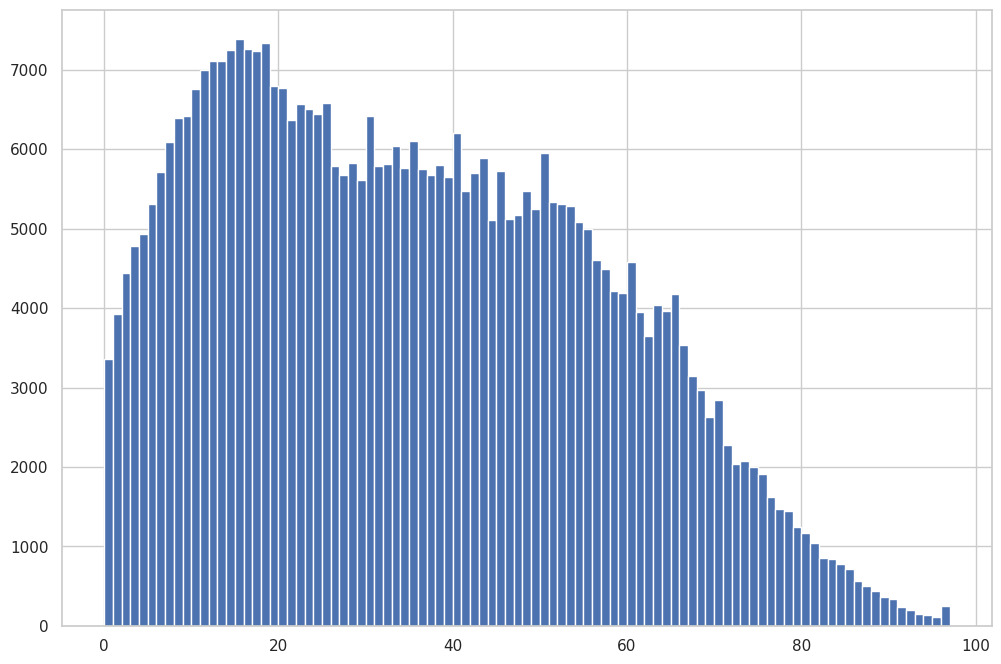

In [ ]:
df_SDMET['eda'].hist(bins=97)

La edad de 0 años no es oulier como tal ya que en los hogares puede haber recien nacidos que no cumplen el año

In [ ]:
df_SDMET[df_SDMET['eda']==0]

cve_ent    con  v_sel  n_hog  h_mud  n_ren  c_res         par_c  sex  \
63           27  40126     53      1      0      3      1  Hijos_Nietos    1   
209          14  40073     53      1      0      4      1  Hijos_Nietos    1   
292          25  50136      7      1      0      3      1  Hijos_Nietos    1   
362          24  40170      1      1      0      9      1  Hijos_Nietos    1   
572          26  40405     54      1      0      6      1  Hijos_Nietos    0   
...         ...    ...    ...    ...    ...    ...    ...           ...  ...   
420796       12  40092     51      1      0      4      1  Hijos_Nietos    0   
421075       19  40448     52      1      0      4      1  Hijos_Nietos    1   
421392        9  40617     52      1      0      4      1  Hijos_Nietos    0   
421400       24  40144     54      1      0      5      1  Hijos_Nietos    1   
421993       19  50019     53      1      1      7      1  Hijos_Nietos    1   

        eda nac_dia nac_mes nac_anio l_nac_c cs_p12 cs_p13_1 cs_p13_2  \
63      0.0      18       2     2025      27                            
209     0.0      29      11     2024      14                            
292     0.0      18       7     2025      25                            
362     0.0      17      12     2024      24                            
572     0.0       7       1     2025      26                            
...     ...     ...     ...      ...     ...    ...      ...      ...   
420796  0.0      11      11     2024      12                            
421075  0.0       8      12     2024      19                            
421392  0.0      25       2     2025       9                            
421400  0.0      99       5     2025      24                            
421993  0.0      10      10     2024      19                            

       cs_p14_c cs_p15 cs_p16 cs_p17 n_hij e_con cs_p20a_1 cs_p20a_c  \
63                                                                     
209                                                                    
292                                                                    
362                                                                    
572                                                                    
...         ...    ...    ...    ...   ...   ...       ...       ...   
420796                                                                 
421075                                                                 
421392                                                                 
421400                                                                 
421993                                                                 

       cs_p20b_1 cs_p20b_c cs_p20c_1 cs_ad_mot cs_p21_des cs_ad_des cs_nr_mot  \
63                                                                              
209                                                                             
292                                                                             
362                                                                             
572                                                                             
...          ...       ...       ...       ...        ...       ...       ...   
420796                                                                          
421075                                                                          
421392                                                                          
421400                                                                          
421993                                                                          

       cs_p23_des cs_nr_ori  zona  salario  clase1  clase2  clase3  pos_ocu  \
63                              2     8364       0       0       0        0   
209                             2     8364       0       0       0        0   
292                             2     8364       0       0       0        0   
362             

##Fecha nacimiento

- nac_dia: Día de nacimiento.
- nac_mes: Mes de nacimiento.
- nac_anio: Año de nacimiento.
- l_nac_c: Clave del lugar de nacimiento (Entidad o país).

In [ ]:
display(obtener_catalogo(sdem,'nac_dia'))
display(obtener_catalogo(sdem,'nac_mes'))

cve              descrip
0     1              Día uno
1     2              Día dos
2     3             Día tres
3     4           Día cuatro
4     5            Día cinco
5     6             Día seis
6     7            Día siete
7     8             Día ocho
8     9            Día nueve
9    10             Día diez
10   11             Día once
11   12             Día doce
12   13           Día trece 
13   14         Día catorce 
14   15          Día quince 
15   16       Día dieciséis 
16   17      Día diecisiete 
17   18       Día dieciocho 
18   19      Día diecinueve 
19   20          Día veinte 
20   21       Día veintiuno 
21   22       Día veintidós 
22   23      Día veintitrés 
23   24    Día veinticuatro 
24   25     Día veinticinco 
25   26      Día veintiséis 
26   27     Día veintisiete 
27   28      Día veintiocho 
28   29     Día veintinueve 
29   30         Día treinta 
30   31      Día treintaiuno
31   99  Día no especificado

cve              descrip
0     1                Enero
1     2              Febrero
2     3                Marzo
3     4                Abril
4     5                 Mayo
5     6                Junio
6     7                Julio
7     8               Agosto
8     9           Septiembre
9    10              Octubre
10   11            Noviembre
11   12            Diciembre
12   99  Mes no especificado

In [ ]:
df_SDMET['nac_dia']=df_SDMET['nac_dia'].astype(float)
df_SDMET['nac_mes']=df_SDMET['nac_mes'].astype(float)
df_SDMET['nac_anio']=df_SDMET['nac_anio'].astype(float)

In [ ]:
print(df_SDMET['nac_dia'].isna().sum())
print(df_SDMET['nac_mes'].isna().sum())
print(df_SDMET['nac_anio'].isna().sum())

0
0
0


In [ ]:
df_SDMET[['nac_dia','nac_mes','nac_anio']].describe()

nac_dia       nac_mes       nac_anio
count  412432.000000  412432.00000  412432.000000
mean       23.595458      14.38667    1993.426555
std        26.175576      25.89467     175.881080
min         1.000000       1.00000    1916.000000
25%         9.000000       4.00000    1973.000000
50%        17.000000       7.00000    1992.000000
75%        26.000000      10.00000    2008.000000
max        99.000000      99.00000    9999.000000

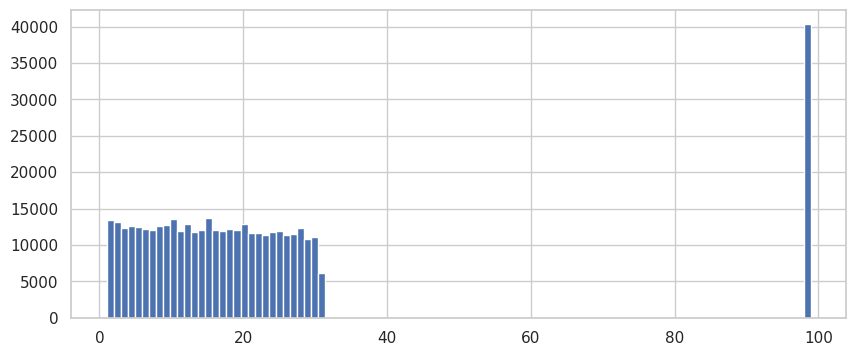

In [ ]:
df_SDMET['nac_dia'].hist(bins=100,figsize=(10,4));

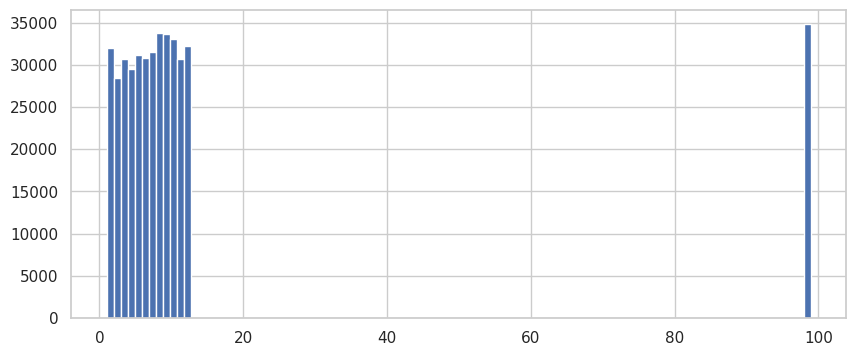

In [ ]:
df_SDMET['nac_mes'].hist(bins=100,figsize=(10,4));

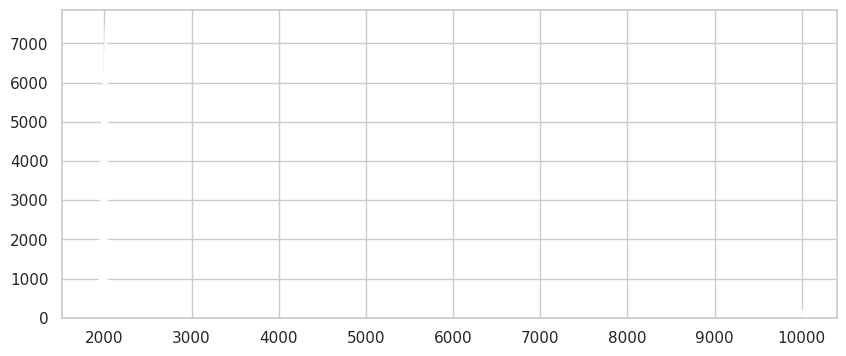

In [ ]:
df_SDMET['nac_anio'].hist(bins=10000,figsize=(10,4));


Las fechas tiene mucha granuladidad con los dias, el mes de nacimento no ayudaria al pefirl, el año de nacimento que da la edad ya se tiene. Se quedara solo con el mes.

In [ ]:
df_SDMET.drop('nac_dia', axis=1, inplace=True)
df_SDMET.drop('nac_mes', axis=1, inplace=True)
df_SDMET.drop('nac_anio', axis=1, inplace=True)

##l_nac_c: Clave del lugar de nacimiento (Entidad o país).

El significado de los datos no viene de un catalogo del data set pero se puede encontrar [aqui](https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/nueva_estruc/702825197285.pdf)

In [ ]:
df_SDMET['l_nac_c']=df_SDMET['l_nac_c'].astype(float)

In [ ]:
np.sort(df_SDMET['l_nac_c'].unique())

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
       100., 102., 142., 200., 211., 213., 214., 216., 217., 219., 220.,
       221., 225., 228., 229., 234., 235., 237., 250., 300., 315., 316.,
       325., 330., 343., 352., 400., 415., 419., 423., 425., 435., 436.,
       437., 438., 439., 500., 800., 999.])

In [ ]:
df_SDMET['cve_ent'] = pd.to_numeric(df_SDMET['cve_ent'])
df_SDMET['l_nac_c'] = pd.to_numeric(df_SDMET['l_nac_c'])

Buscamos el orgen de nacimento

In [ ]:
df_SDMET['nac_origen'] = df_SDMET.apply(clasificar_origen, axis=1)

In [ ]:
df_SDMET['nac_origen']

0         Otro_Estado
1               Local
2               Local
3               Local
4         Otro_Estado
             ...     
422301          Local
422302          Local
422303    Otro_Estado
422304          Local
422305          Local
Name: nac_origen, Length: 412432, dtype: object

In [ ]:
values_can_porcentaje(df_SDMET,'nac_origen')

Cantidad  Porcentaje
nac_origen                             
Local                338061   81.967694
Otro_Estado           70815   17.170103
EUA_Canada             2040    0.494627
Latam                  1198    0.290472
Asia_Africa_Resto       201    0.048735
Europa                  117    0.028368

In [ ]:
df_SDMET.drop('l_nac_c', axis=1, inplace=True)

##cs_p12: ¿Sabe leer y escribir un recado?\

In [ ]:
obtener_catalogo(sdem,'cs_p12')

cve  descrip
0    1       Sí
1    2       No
2    9  No sabe

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p12')

Cantidad  Porcentaje
cs_p12                      
1         369447   89.577676
2          21496    5.212011
           21445    5.199645
9             44    0.010668

In [ ]:
df_SDMET[df_SDMET['cs_p12']==' ']['eda'].value_counts()

eda
4.0    4931
3.0    4777
2.0    4441
1.0    3931
0.0    3365
Name: count, dtype: int64

Como son niños su valor es que no saben leer o escribir

In [ ]:
df_SDMET['cs_p12'] = df_SDMET['cs_p12'].astype(str).replace([' ', '9'], '2')

In [ ]:
df_SDMET['cs_p12'] = df_SDMET['cs_p12'].astype(float)

In [ ]:
df_SDMET['cs_p12'] = df_SDMET['cs_p12'].map({1: 1, 2: 0})

##cs_p13_1: Nivel escolar máximo aprobado (Primaria, Secundaria, etc.).

In [ ]:
obtener_catalogo(sdem,'cs_p13_1')

cve                      descrip
0     0                      Ninguno
1     1                   Preescolar
2     2                     Primaria
3     3                   Secundaria
4     4  Preparatoria o bachillerato
5     5                       Normal
6     6              Carrera técnica
7     7                  Profesional
8     8                     Maestría
9     9                    Doctorado
10   99                      No sabe

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p13_1')

Cantidad  Porcentaje
cs_p13_1                      
2            99246   24.063603
3            99023   24.009534
4            78022   18.917543
7            70530   17.101001
             21445    5.199645
0            13126    3.182585
1            12755    3.092631
6            10373    2.515081
8             5196    1.259844
5             1176    0.285138
9              861    0.208762
99             679    0.164633

In [ ]:
df_SDMET[df_SDMET['cs_p13_1']==' ']['eda'].value_counts()

eda
4.0    4931
3.0    4777
2.0    4441
1.0    3931
0.0    3365
Name: count, dtype: int64

In [ ]:
df_SDMET['cs_p13_1'] = df_SDMET['cs_p13_1'].astype(str).replace([' ', '99'], '0')
df_SDMET['cs_p13_1'] = df_SDMET['cs_p13_1'].astype(float)

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p13_1')

Cantidad  Porcentaje
cs_p13_1                      
2.0          99246   24.063603
3.0          99023   24.009534
4.0          78022   18.917543
7.0          70530   17.101001
0.0          35250    8.546863
1.0          12755    3.092631
6.0          10373    2.515081
8.0           5196    1.259844
5.0           1176    0.285138
9.0            861    0.208762

##cs_p13_2: Grado o año aprobado en ese nivel.

In [ ]:
obtener_catalogo(sdem,'cs_p13_2')

cve                descrip
0    0    Cero años aprobados
1    1        Un año aprobado
2    2     Dos años aprobados
3    3    Tres años aprobados
4    4  Cuatro años aprobados
5    5   Cinco años aprobados
6    6    Seis años aprobados
7    7   Siete años aprobados
8    8    Ocho años aprobados
9    9   Nueve años aprobados

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p13_2')

Cantidad  Porcentaje
cs_p13_2                      
3           170951   41.449500
2            52364   12.696396
6            46857   11.361146
4            36700    8.898437
5            35841    8.690160
1            34143    8.278456
             21445    5.199645
0            13126    3.182585
9              908    0.220158
7               94    0.022792
8                3    0.000727

In [ ]:
df_SDMET[df_SDMET['cs_p13_2']==' ']['eda'].value_counts()

eda
4.0    4931
3.0    4777
2.0    4441
1.0    3931
0.0    3365
Name: count, dtype: int64

In [ ]:
df_SDMET['cs_p13_2'] = df_SDMET['cs_p13_2'].astype(str).replace(' ', '0')
df_SDMET['cs_p13_2'] = df_SDMET['cs_p13_2'].astype(float)

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p13_2')

Cantidad  Porcentaje
cs_p13_2                      
3.0         170951   41.449500
2.0          52364   12.696396
6.0          46857   11.361146
4.0          36700    8.898437
5.0          35841    8.690160
0.0          34571    8.382230
1.0          34143    8.278456
9.0            908    0.220158
7.0             94    0.022792
8.0              3    0.000727

##cs_p14_c: Clave de la carrera (para niveles técnicos o superiores).

Para entender su armado se puede revisar el siguiente [pdf](https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/nueva_estruc/702825086664.pdf)

In [ ]:
obtener_catalogo(sdem,'cs_p14_c').sample(n=20)

cve                                                  descrip
177  101300                  Servicios de cuidado personal y belleza
133   91335                                             Oftalmología
176  101200                                     Servicios funerarios
45    33200                            Criminología y criminalística
117   91319                        Inmunología clínica y alergología
25    21400    Tecnologías audiovisuales para medios de comunicación
7     12100  Formación docente en educación básica, nivel preescolar
106   91308                                       Cirugía pediátrica
178  101400           Servicios de apoyo y asistencia administrativa
53    42200               Administración turística y de restaurantes
84    72100                             Industria de la alimentación
114   91316                                Ginecología y obstetricia
23    21200                                          Artes escénicas
18    12701                   Formación docente en educación inicial
122   91324                                     Medicina del deporte
168   95100           Atención prehospitalaria y emergencias médicas
100   91302                            Angiología y cirugía vascular
92    81200                                             Horticultura
157   93202                                               Endodoncia
145   92200                               Enfermería de especialidad

In [ ]:
df_SDMET['cs_p14_c'].value_counts().head(50)

cs_p14_c
          324296
041400      7211
033100      6421
042100      5830
092100      4299
101400      3521
071700      3406
031100      3054
061300      2941
071300      2591
011500      2464
012200      2226
042000      1954
041100      1915
091100      1913
073100      1822
073200      1750
011100      1652
062200      1405
071100      1365
012100      1275
041200      1252
081100      1176
093100      1126
071400      1069
101500      1063
031500       999
021500       949
032100       887
012300       806
101600       763
012000       762
071200       745
094200       721
051200       691
071500       691
012601       636
033200       627
082100       609
042400       567
094100       556
051100       541
061100       506
031400       488
021600       483
041300       477
022200       464
031300       457
999999       446
072400       386
Name: count, dtype: int64

In [ ]:
df_SDMET[df_SDMET['cs_p14_c']==' ']['eda'].value_counts()

eda
15.0    7380
14.0    7246
16.0    7240
17.0    7196
12.0    7110
        ... 
97.0     154
93.0     139
94.0     130
95.0      97
96.0      76
Name: count, Length: 98, dtype: int64

In [ ]:
df_SDMET['cs_p14_c'] = df_SDMET['cs_p14_c'].astype(str).replace(' ', '0')

In [ ]:
df_SDMET['cs_p14_c'] = df_SDMET['cs_p14_c'].str[:3]

In [ ]:
df_SDMET['cs_p14_c'].value_counts()

cs_p14_c
0      324296
041     10859
071     10245
042      8982
033      7048
012      6591
101      5852
031      5341
011      4549
092      4382
061      3634
073      3572
091      2380
021      2145
062      1825
051      1390
094      1314
081      1312
093      1203
022      1123
032       925
072       741
095       613
082       609
052       530
999       446
053       252
102       134
104       109
103        30
Name: count, dtype: int64

##cs_p15: Antecedente escolar requerido para la carrera.

In [ ]:
obtener_catalogo(sdem,'cs_p15')

cve       descrip
0    1      Primaria
1    2    Secundaria
2    3  Preparatoria
3    9       No sabe

In [ ]:
df_SDMET['cs_p15'].value_counts()

cs_p15
     330353
3     72490
2      8709
1       836
9        44
Name: count, dtype: int64

Suena redundante ya que tenemos el nivel que llego la persona

In [ ]:
df_SDMET.drop('cs_p15', axis=1, inplace=True)

##cs_p16: ¿Terminó los estudios de la carrera?

In [ ]:
obtener_catalogo(sdem,'cs_p16')

cve  descrip
0    1       Sí
1    2       No
2    9  No sabe

In [ ]:
df_SDMET['cs_p16'].value_counts()

cs_p16
     324296
1     68005
2     19932
9       199
Name: count, dtype: int64

In [ ]:
df_SDMET['cs_p16'] = df_SDMET['cs_p16'].astype(str).replace([' ','9'], '2')

In [ ]:
df_SDMET['cs_p16'] = df_SDMET['cs_p16'].astype(float)

In [ ]:
df_SDMET['cs_p16'].value_counts()

cs_p16
2.0    344427
1.0     68005
Name: count, dtype: int64

In [ ]:
df_SDMET['cs_p16']=df_SDMET['cs_p16'].map({1: 1, 2: 0})

##cs_p17: ¿Asiste actualmente a la escuela?


In [ ]:
obtener_catalogo(sdem,'cs_p17')

cve  descrip
0    1       Sí
1    2       No
2    9  No sabe

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p17')

Cantidad  Porcentaje
cs_p17                      
2         285261   69.165584
1         105692   25.626528
           21445    5.199645
9             34    0.008244

In [ ]:
df_SDMET['cs_p17'] = df_SDMET['cs_p17'].astype(str).replace([' ','9'], '2')

In [ ]:
df_SDMET['cs_p17'] = df_SDMET['cs_p17'].astype(float)

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p17')

Cantidad  Porcentaje
cs_p17                      
2.0       306740   74.373472
1.0       105692   25.626528

In [ ]:
df_SDMET['cs_p17'] =df_SDMET['cs_p17'].map({1: 1, 2: 0})

##n_hij: Número de hijos nacidos vivos

In [ ]:
values_can_porcentaje(df_SDMET,'n_hij')

Cantidad  Porcentaje
n_hij                      
         229300   55.597044
0         59737   14.484085
2         37825    9.171209
3         31278    7.583796
1         23536    5.706638
4         13938    3.379466
5          6602    1.600749
6          3678    0.891783
7          2216    0.537301
8          1571    0.380911
9           957    0.232038
10          745    0.180636
11          386    0.093591
12          327    0.079286
13          141    0.034187
14           87    0.021094
16           35    0.008486
15           35    0.008486
99           15    0.003637
17            6    0.001455
18            5    0.001212
20            5    0.001212
22            3    0.000727
21            2    0.000485
25            1    0.000242
23            1    0.000242

Esta pregunto tiene varios nulos porque la mayoria son hombres

In [ ]:
df_SDMET[df_SDMET['n_hij']==' ']['sex'].value_counts()

sex
1    197333
0     31967
Name: count, dtype: int64

Y las que son mujeres tiene una edad menor a 11 años

In [ ]:
df_SDMET[(df_SDMET['n_hij']==' ')&(df_SDMET['sex']==0)]['eda'].value_counts()

eda
11.0    3403
10.0    3321
8.0     3176
9.0     3138
7.0     2926
6.0     2821
5.0     2666
4.0     2441
3.0     2393
2.0     2140
1.0     1920
0.0     1622
Name: count, dtype: int64

In [ ]:
df_SDMET['n_hij'] = df_SDMET['n_hij'].astype(str).replace([' ','99'], '0')

In [ ]:
df_SDMET['n_hij'] = df_SDMET['n_hij'].astype(float)

Para los outliers se hara una Winsorización para gruparlos

In [ ]:
limite_maximo = 13
df_SDMET['n_hij'] = np.where(df_SDMET['n_hij'] > limite_maximo,limite_maximo,df_SDMET['n_hij'])

##e_con: Estado conyugal (Unión libre, separado, divorciado, viudo, casado, soltero).

In [ ]:
obtener_catalogo(sdem,'e_con')

cve                            descrip
0    1  Vive con su pareja en unión libre
1    2                   Está separado(a)
2    3                 Está divorciado(a)
3    4                      Está viudo(a)
4    5                     Está casado(a)
5    6                    Está soltero(a)
6    9                            No sabe

In [ ]:
values_can_porcentaje(df_SDMET,'e_con')

Cantidad  Porcentaje
e_con                      
6        129344   31.361291
5        117301   28.441295
          65146   15.795574
1         57674   13.983881
4         18846    4.569481
2         16534    4.008903
3          7551    1.830847
9            36    0.008729

In [ ]:
df_SDMET[df_SDMET['e_con']==' ']['eda'].value_counts()

eda
11.0    7004
10.0    6764
9.0     6420
8.0     6388
7.0     6096
6.0     5718
5.0     5311
4.0     4931
3.0     4777
2.0     4441
1.0     3931
0.0     3365
Name: count, dtype: int64

In [ ]:
df_SDMET['e_con'] = df_SDMET['e_con'].replace([' ', '9'], '6')

In [ ]:
df_SDMET['e_con'] = df_SDMET['e_con'].astype(float)

##cs_p20a_1: Lugar donde vivía hace un año (Estado o País).

In [ ]:
obtener_catalogo(sdem,'cs_p20a_1')

cve                           descrip
0    1              Aquí, en este estado
1    2       En otro estado (Especifica)
2    3  En los Estados Unidos de América
3    4         En otro país (Especifica)

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p20a_1')

Cantidad  Porcentaje
cs_p20a_1                      
1            406884   98.654809
               3365    0.815892
2              1757    0.426010
3               270    0.065465
4               156    0.037824

Los recien nacidos tienen vacio porque aun no cumple el año

In [ ]:
df_SDMET[df_SDMET['cs_p20a_1']==' ']['eda'].value_counts()

eda
0.0    3365
Name: count, dtype: int64

In [ ]:
df_SDMET['cs_p20a_1'] = df_SDMET['cs_p20a_1'].replace(' ', '1')

In [ ]:
df_SDMET['cs_p20a_1'] = df_SDMET['cs_p20a_1'].astype(float)

Muncipios y estados

- cs_p20a_c: Clave de la entidad o país donde vivía hace un año.
- cs_p20b_1: Municipio donde vivía hace un año.
- cs_p20b_c: Clave del municipio donde vivía hace un año.

la clave del estado de origen por si sola no es de ayuda y ya se tiene el dato si se movio o no hace un año y el muncipio es muy granular

In [ ]:
df_SDMET.drop('cs_p20a_c', axis=1, inplace=True)
df_SDMET.drop('cs_p20b_1', axis=1, inplace=True)
df_SDMET.drop('cs_p20b_c', axis=1, inplace=True)

##cs_p20c_1: Causa por la que dejó de vivir en ese lugar.


In [ ]:
obtener_catalogo(sdem,'cs_p20c_1')

cve                                                            descrip
0     1                                                     Buscar trabajo
1     2                                         Cambio u oferta de trabajo
2     3                                            Reunirse con la familia
3     4                                                     Se casó o unió
4     5                                                           Estudiar
5     6  Por inseguridad o delincuencia (asaltos, extorsiones, homicidios)
6     7            Por violencia (entre vecinos, comunidad, intrafamiliar)
7     8                                       Por sus creencias religiosas
8     9                                            Por desastres naturales
9    10                                         Lo deportaron (regresaron)
10   11                                            Otra causa (Especifica)

In [ ]:
values_can_porcentaje(df_SDMET,'cs_p20c_1')

Cantidad  Porcentaje
cs_p20c_1                      
             408911   99.146284
3              1635    0.396429
1               614    0.148873
11              449    0.108866
2               296    0.071769
5               193    0.046796
4               178    0.043159
6               101    0.024489
10               36    0.008729
7                12    0.002910
8                 4    0.000970
9                 3    0.000727

Casi todas las personas no respondieron este punto, y hacerla binaria no es util ya que tenemos otras variables que grupan si se cambio

In [ ]:
df_SDMET.drop('cs_p20c_1', axis=1, inplace=True)

##Ausentes y nuevos

Estas variables tienen nulos masivos porque solo se activan si hay cambios de residencia o si la persona estuvo ausente y como se filtro ese tipo de personas quedaron los que tienen muy pocos datos

In [ ]:
obtener_catalogo(sdem,'cs_ad_mot')

cve                       descrip
0     1                       Trabajo
1     2                      Estudios
2     3                Se casó o unió
3     4          Se separó o divorció
4     5            Problemas de salud
5     6       Reunirse con la familia
6     7           Inseguridad pública
7     8                      Falleció
8     9  Persona registrada por error
9    10                   Otro motivo
10   99                       No sabe

In [ ]:
display(values_can_porcentaje(df_SDMET,'cs_ad_mot'))
display(values_can_porcentaje(df_SDMET,'cs_p21_des'))
display(values_can_porcentaje(df_SDMET,'cs_ad_des'))
display(values_can_porcentaje(df_SDMET,'cs_nr_mot'))
display(values_can_porcentaje(df_SDMET,'cs_p23_des'))
display(values_can_porcentaje(df_SDMET,'cs_nr_ori'))

Cantidad  Porcentaje
cs_ad_mot                      
             412432       100.0

Cantidad  Porcentaje
cs_p21_des                      
              412432       100.0

Cantidad  Porcentaje
cs_ad_des                      
             412432       100.0

Cantidad  Porcentaje
cs_nr_mot                      
             404143   97.990214
6              3236    0.784614
9              2585    0.626770
3               583    0.141357
8               508    0.123172
1               384    0.093106
10              348    0.084378
4               320    0.077589
2               225    0.054554
5                75    0.018185
7                18    0.004364
99                7    0.001697

Cantidad  Porcentaje
cs_p23_des                                                        
                                                412084   99.915622
PROBLEMAS FAMILIARES                                 9    0.002182
SE UNIË AL HOGAR PRINCIPAL                           6    0.001455
NO TEN-A DONDE VIVIR                                 5    0.001212
LO ELIMINARON POR ERROR                              5    0.001212
...                                                ...         ...
PARA CUIDAR A SUS PAP-S QUE YA EST-N GRANDES         1    0.000242
DEPORTADO                                            1    0.000242
BAJA POR ERI                                         1    0.000242
BAJA POR ERROR                                       1    0.000242
TERMINO DE ESTUDIAR                                  1    0.000242

[287 rows x 2 columns]

Cantidad  Porcentaje
cs_nr_ori                      
             407236   98.740156
1              4384    1.062963
2               662    0.160511
3               147    0.035642
9                 3    0.000727

se elimnaran por estar vacios

In [ ]:
df_SDMET.drop('cs_ad_mot', axis=1, inplace=True)
df_SDMET.drop('cs_p21_des', axis=1, inplace=True)
df_SDMET.drop('cs_ad_des', axis=1, inplace=True)
df_SDMET.drop('cs_nr_mot', axis=1, inplace=True)
df_SDMET.drop('cs_p23_des', axis=1, inplace=True)
df_SDMET.drop('cs_nr_ori', axis=1, inplace=True)

##zona: Zona salarial

- Zona 1 Frontera Norte
- Zona 2 Resto del país

In [ ]:
obtener_catalogo(sdem,'zona')

cve                descrip
0    0              No aplica
1    1  Zona 1 Frontera norte
2    2  Zona 2 Resto del país

In [ ]:
values_can_porcentaje(df_SDMET,'zona')

Cantidad  Porcentaje
zona                      
2       379654   92.052508
1        32778    7.947492

In [ ]:
df_SDMET['zona'].isna().sum()

np.int64(0)

In [ ]:
df_SDMET['zona']=df_SDMET['zona'].map({1: 1, 2: 0})

##salario: Monto del salario mínimo

In [ ]:
df_SDMET['salario'].isna().sum()

np.int64(0)

In [ ]:
df_SDMET['salario'].describe()

count    412432.000000
mean       8700.337859
std        1144.666695
min        8364.000000
25%        8364.000000
50%        8364.000000
75%        8364.000000
max       12596.000000
Name: salario, dtype: float64

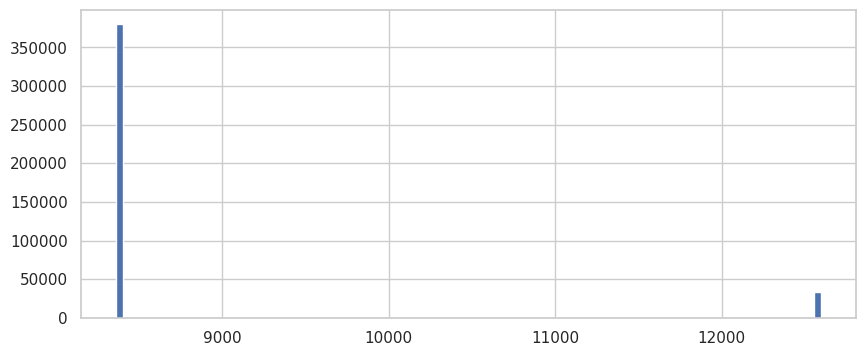

In [ ]:
df_SDMET['salario'].hist(bins=100,figsize=(10,4));

In [ ]:
df_SDMET['salario'].value_counts()

salario
8364     379654
12596     32778
Name: count, dtype: int64

In [ ]:
df_SDMET[df_SDMET['salario']==8364]['zona'].value_counts()

zona
0    379654
Name: count, dtype: int64

In [ ]:
df_SDMET[df_SDMET['salario']==12596]['zona'].value_counts()

zona
1    32778
Name: count, dtype: int64

Es redunsnate este valor porque ya viene en la etiqueta de zona

In [ ]:
df_SDMET.drop('salario', axis=1, inplace=True)

##clase1: Población Económicamente Activa (PEA) vs No Económicamente Activa (PNEA).

In [ ]:
obtener_catalogo(sdem,'clase1')

cve                             descrip
0    0                           No aplica
1    1     Población económicamente activa
2    2  Población no económicamente activa

In [ ]:
values_can_porcentaje(df_SDMET,'clase1')

Cantidad  Porcentaje
clase1                      
1         197929   47.990699
2         148595   36.028970
0          65908   15.980331

##clase2: Población Ocupada vs Desocupada vs Disponible.

In [ ]:
obtener_catalogo(sdem,'clase2')

cve               descrip
0    0             No aplica
1    1     Población ocupada
2    2  Población desocupada
3    3           Disponibles
4    4        No disponibles

In [ ]:
values_can_porcentaje(df_SDMET,'clase2')

Cantidad  Porcentaje
clase2                      
1         192201   46.601864
4         132072   32.022733
0          65908   15.980331
3          16523    4.006236
2           5728    1.388835

##clase3: Clasificación detallada

In [ ]:
obtener_catalogo(sdem,'clase3')

cve                                              descrip
0    0                                            No aplica
1    1                                        Ocupado pleno
2    2                                     Ocupado Sin Pago
3    3                     Ocupado ausente con nexo laboral
4    4                Ocupado ausente con retorno asegurado
5    5                              Desocupados Iniciadores
6    6                             Desocupados con búsqueda
7    7  Desocupados Ausentes sin ingreso y sin nexo laboral

In [ ]:
values_can_porcentaje(df_SDMET,'clase3')

Cantidad  Porcentaje
clase3                      
0         214503   52.009301
1         182983   44.366829
6           5459    1.323612
3           4533    1.099090
2           3335    0.808618
4           1350    0.327327
7            144    0.034915
5            125    0.030308

##pos_ocu: Posición en la ocupación

In [ ]:
obtener_catalogo(sdem,'pos_ocu')

cve                                  descrip
0    0                                No aplica
1    1  Trabajadores subordinados y remunerados
2    2                              Empleadores
3    3           Trabajadores por cuenta propia
4    4                    Trabajadores sin pago
5    5                          No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'pos_ocu')

Cantidad  Porcentaje
pos_ocu                      
0          220231   53.398136
1          135581   32.873540
3           38000    9.213640
2           11797    2.860350
4            6823    1.654333

In [ ]:
df_SDMET['pos_ocu'].isnull().sum()

np.int64(0)

##seg_soc: Acceso a instituciones de salud por el trabajo.


In [ ]:
obtener_catalogo(sdem,'seg_soc')

cve          descrip
0    0        No aplica
1    1       Con acceso
2    2       Sin acceso
3    3  No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'seg_soc')

Cantidad  Porcentaje
seg_soc                      
0          220231   53.398136
2          109597   26.573350
1           80852   19.603716
3            1752    0.424797

In [ ]:
df_SDMET['seg_soc'].isnull().sum()

np.int64(0)

##rama: Sector de actividad económica

In [ ]:
obtener_catalogo(sdem,'rama')

cve                  descrip
0    0                No aplica
1    6             Agropecuario
2    1             Construcción
3    2  Industria manufacturera
4    3                 Comercio
5    4                Servicios
6    5                    Otros
7    7          No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'rama')

Cantidad  Porcentaje
rama                      
0       220231   53.398136
4        88773   21.524276
3        37298    9.043430
2        31081    7.536030
6        16345    3.963078
1        15532    3.765954
5         1728    0.418978
7         1444    0.350118

In [ ]:
df_SDMET['rama'].isnull().sum()

np.int64(0)

##c_ocu11c: Tipo de ocupación

In [ ]:
obtener_catalogo(sdem,'c_ocu11c')

cve                                           descrip
0     0                                         No aplica
1     1   Profesionales, técnicos y trabajadores del arte
2     2                      Trabajadores de la educación
3     3                         Funcionarios y directivos
4     4                                       Oficinistas
5     5  Trabajadores industriales  artesanos y ayudantes
6     6                                      Comerciantes
7     7                          Operadores de transporte
8     8              Trabajadores en servicios personales
9     9           Trabajadores en protección y vigilancia
10   10                        Trabajadores agropecuarios
11   11                                   No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'c_ocu11c')

Cantidad  Porcentaje
c_ocu11c                      
0           220231   53.398136
5            50540   12.254141
6            33530    8.129825
8            29586    7.173546
1            22930    5.559704
4            17187    4.167232
10           15838    3.840148
7            10050    2.436765
2             6893    1.671306
3             3736    0.905846
9             1656    0.401521
11             255    0.061828

In [ ]:
df_SDMET['c_ocu11c'].isnull().sum()

np.int64(0)

##ing7c: Nivel de ingreso agrupado en salarios mínimos.

In [ ]:
obtener_catalogo(sdem,'ing7c')

cve                            descrip
0    0                          No aplica
1    1            Hasta un salario mínimo
2    2  Más de 1 hasta 2 salarios mínimos
3    3  Más de 2 hasta 3 salarios mínimos
4    4  Más de 3 hasta 5 salarios mínimos
5    5          Más de 5 salarios mínimos
6    6                 No recibe ingresos
7    7                    No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'ing7c')

Cantidad  Porcentaje
ing7c                      
0        220231   53.398136
1         70966   17.206715
2         61871   15.001503
7         31659    7.676174
3         12804    3.104512
6          8840    2.143384
4          4556    1.104667
5          1505    0.364909

In [ ]:
df_SDMET['ing7c'].isnull().sum()

np.int64(0)

In [ ]:
df_SDMET['ing7c'] = df_SDMET['ing7c'].replace({0: 0, 6: 0})

In [ ]:
mediana_ingreso = df_SDMET[df_SDMET['ing7c'].isin([1,2,3,4,5])]['ing7c'].median()

In [ ]:
mediana_ingreso

2.0

In [ ]:
df_SDMET['ing7c'] = df_SDMET['ing7c'].replace({7: mediana_ingreso})

In [ ]:
values_can_porcentaje(df_SDMET,'ing7c')

Cantidad  Porcentaje
ing7c                      
0        229071   55.541520
2         93530   22.677678
1         70966   17.206715
3         12804    3.104512
4          4556    1.104667
5          1505    0.364909

##dur9c: Duración de la jornada laboral (horas agrupadas).

In [ ]:
obtener_catalogo(sdem,'dur9c')

cve                                  descrip
0    0                                No aplica
1    1  Ausentes temporales con vínculo laboral
2    2                        Menos de 15 horas
3    3                         De 15 a 24 horas
4    4                         De 25 a 34 horas
5    5                         De 35 a 39 horas
6    6                         De 40 a 48 horas
7    7                         De 49 a 56 horas
8    8                          Más de 56 horas
9    9                          No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'dur9c')

Cantidad  Porcentaje
dur9c                      
0        220231   53.398136
6         82523   20.008874
7         23314    5.652811
8         23004    5.577647
3         16160    3.918222
4         14805    3.589683
2         13177    3.194951
5         10770    2.611340
1          6005    1.455998
9          2443    0.592340

In [ ]:
df_SDMET['dur9c'].isnull().sum()

np.int64(0)

Se probara una imputacion logica tomando los valores entre rangos

In [ ]:
mapeo_horas = {
    0: 0,
    1: 0,
    2: 7.5,
    3: 19.5,
    4: 29.5,
    5: 37,
    6: 44,
    7: 52.5,
    8: 60,
    9: np.nan
}

In [ ]:
df_SDMET['dur9c'] = df_SDMET['dur9c'].map(mapeo_horas)

In [ ]:
df_SDMET['dur9c'].fillna(df_SDMET['dur9c'].median(), inplace=True)

##emple7c: Tamaño del establecimiento donde trabaja (número de personas).


In [ ]:
obtener_catalogo(sdem,'emple7c')

cve               descrip
0    0             No aplica
1    1             1 persona
2    2     De 2 a 5 personas
3    3    De 6 a 10 personas
4    4   De 11 a 15 personas
5    5   De 16 a 50 personas
6    6  De 51 y más personas
7    7       No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'emple7c')

Cantidad  Porcentaje
emple7c                      
0          220231   53.398136
2           55679   13.500165
6           42138   10.216957
1           35932    8.712224
5           18735    4.542567
7           17669    4.284100
3           15115    3.664847
4            6933    1.681004

In [ ]:
df_SDMET['emple7c'].isnull().sum()

np.int64(0)

In [ ]:
mapeo_empresa = {
    0: 0,
    1: 1,
    2: 3.5,
    3: 8,
    4: 13,
    5: 33,
    6: 75,
    7: np.nan
}

df_SDMET['emple7c'] = df_SDMET['emple7c'].map(mapeo_empresa)

df_SDMET['emple7c'].fillna(
    df_SDMET['emple7c'].median(),
    inplace=True
)

##medica5c: Prestaciones de salud (Acceso directo, otras prestaciones).

In [ ]:
obtener_catalogo(sdem,'medica5c')

cve                                                                descrip
0    0                                                              No aplica
1    1                                                       Sin prestaciones
2    2                                   Solo acceso a instituciones de salud
3    3                  Acceso de instituciones de salud y otras prestaciones
4    4  No tiene acceso a instituciones de salud pero si a otras prestaciones
5    5                                                        No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'medica5c')

Cantidad  Porcentaje
medica5c                      
0           220231   53.398136
1            92004   22.307677
3            77679   18.834378
4            17464    4.234395
2             3173    0.769339
5             1881    0.456075

In [ ]:
df_SDMET['medica5c'].isnull().sum()

np.int64(0)

##buscar5c: Motivo de búsqueda de otro empleo (para ocupados).

In [ ]:
obtener_catalogo(sdem,'buscar5c')

cve                    descrip
0    0                  No aplica
1    1     Para tener otro empleo
2    2  Para cambiarse de trabajo
3    3                       Otro
4    4                   No buscó
5    5            No especificado

In [ ]:
values_can_porcentaje(df_SDMET,'buscar5c')

Cantidad  Porcentaje
buscar5c                      
0           220231   53.398136
4           185869   45.066581
2             3895    0.944398
3             1200    0.290957
1             1127    0.273257
5              110    0.026671

In [ ]:
df_SDMET['buscar5c'].isnull().sum()

np.int64(0)

##rama_est1: Clasificación de la población ocupada según sector de actividad-Totales.

In [ ]:
col='rama_est1'
display(obtener_catalogo(sdem,col))
display(values_can_porcentaje(df_SDMET,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")

cve          descrip
0    0        No aplica
1    1         Primario
2    2       Secundario
3    3        Terciario
4    4  No especificado

Cantidad  Porcentaje
rama_est1                      
0            220231   53.398136
3            126071   30.567706
2             48341   11.720962
1             16345    3.963078
4              1444    0.350118

Nulos: 0


In [ ]:
df_SDMET['rama_est1'] = df_SDMET['rama_est1'].replace(4, 0)

In [ ]:
col='rama_est1'
display(obtener_catalogo(sdem,col))
display(values_can_porcentaje(df_SDMET,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")

cve          descrip
0    0        No aplica
1    1         Primario
2    2       Secundario
3    3        Terciario
4    4  No especificado

Cantidad  Porcentaje
rama_est1                      
0            221675   53.748254
3            126071   30.567706
2             48341   11.720962
1             16345    3.963078

Nulos: 0


##rama_est2: Clasificación de la población ocupada según sector de actividad Subtotales

In [ ]:
col='rama_est2'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                               descrip
0     0                                             No aplica
1     1    Agricultura, ganadería, silvicultura, caza y pesca
2     2             Industria extractiva y de la electricidad
3     3                               Industria manufacturera
4     4                                          Construcción
5     5                                              Comercio
6     6               Restaurantes y servicios de alojamiento
7     7  Transportes, comunicaciones, correo y almacenamiento
8     8   Servicios profesionales, financieros y corporativos
9     9                                    Servicios sociales
10   10                                    Servicios diversos
11   11                 Gobierno y organismos internacionales

Nulos: 0


Cantidad  Porcentaje
rama_est2                      
0            221675   53.748254
5             37298    9.043430
3             31081    7.536030
10            20070    4.866257
6             17517    4.247246
9             16988    4.118982
1             16345    3.963078
4             15532    3.765954
8             14869    3.605200
7             10831    2.626130
11             8498    2.060461
2              1728    0.418978

##dur_est: Clasificación de la población ocupada por duración de la jornada.

In [ ]:
col='dur_est'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                  descrip
0    0                                No aplica
1    1  Ausentes temporales con vínculo laboral
2    2                        Menos de 15 horas
3    3                         De 15 a 34 horas
4    4                         De 35 a 48 horas
5    5                          Más de 48 horas
6    6                          No especificado

Nulos: 0


Cantidad  Porcentaje
dur_est                      
0          220231   53.398136
4           93293   22.620214
5           46318   11.230457
3           30965    7.507904
2           13177    3.194951
1            6005    1.455998
6            2443    0.592340

In [ ]:
df_SDMET['dur_est'] = df_SDMET['dur_est'].replace(6, 0)

Se elimina porque dur9c ya representa eso

In [ ]:
df_SDMET.drop('dur_est', axis=1, inplace=True)

##ambito1: Clasificación de la población ocupada según el tamaño de la unidad económica-Totales.

In [ ]:
col='ambito1'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                 descrip
0    0               No aplica
1    1     Ámbito agropecuario
2    2  Ámbito no agropecuario
3    3         No especificado

Nulos: 0


Cantidad  Porcentaje
ambito1                      
0          220231   53.398136
2          159469   38.665525
3           16387    3.973261
1           16345    3.963078

In [ ]:
df_SDMET['ambito1'] = (df_SDMET['ambito1'] == 1).astype(int)

##ambito2: Clasificación de la población ocupada según el tamaño de la unidad económica-Subtotales.

In [ ]:
col='ambito2'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                         descrip
0    0                                       No aplica
1    1  Micronegocios (Calculado se suma código 2 y 3)
2    2                             Sin establecimiento
3    3                             Con establecimiento
4    4                       Pequeños establecimientos
5    5                       Medianos establecimientos
6    6                        Grandes establecimientos
7    7                                        Gobierno
8    8                                           Otros

Nulos: 0


Cantidad  Porcentaje
ambito2                      
0          252963   61.334475
2           39683    9.621707
3           35503    8.608207
4           29801    7.225676
6           20622    5.000097
5           16762    4.064185
8            8600    2.085192
7            8498    2.060461

In [ ]:
df_SDMET[df_SDMET['ambito2']==0]['c_res'].value_counts()

c_res
1    247465
3      5498
Name: count, dtype: int64

In [ ]:
mapeo_ambito = {
    0: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
    8: 1
}

df_SDMET['ambito2'] = df_SDMET['ambito2'].map(mapeo_ambito)

##tue1: Clasificación de la población ocupada por tipo de unidad económica-Totales.


In [ ]:
col='tue1'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                              descrip
0    0                                            No aplica
1    1                                  Empresas y negocios
2    2                                        Instituciones
3    3                                Sector de los hogares
4    4  Situaciones de carácter especial y no especificadas

Nulos: 0


Cantidad  Porcentaje
tue1                      
0       220231   53.398136
1       101494   24.608663
3        64105   15.543168
2        25335    6.142831
4         1267    0.307202

##tue2: Clasificación de la población ocupada por tipo de unidad económica-Subtotales.

In [ ]:
col='tue2'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                           descrip
0    0                                         No aplica
1    1  Empresas constituidas en sociedad y corporativas
2    2              Negocios no constituidos en sociedad
3    3                                          Privadas
4    4                                          Públicas
5    5                                   Sector informal
6    6                      Trabajo doméstico remunerado
7    7                  Agricultura de auto subsistencia

Nulos: 0


Cantidad  Porcentaje
tue2                      
0       221498   53.705338
1        56005   13.579208
5        53022   12.855937
2        45489   11.029455
4        21841    5.295661
6         7436    1.802964
7         3647    0.884267
3         3494    0.847170

##tue3: Clasificación de la población ocupada por tipo de unidad económica- Subtotales.


In [ ]:
col='tue3'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                             descrip
0    0                           No aplica
1    1     Administradas por los gobiernos
2    2  No administradas por los gobiernos

Nulos: 0


Cantidad  Porcentaje
tue3                      
0       390591   94.704339
1        20328    4.928813
2         1513    0.366848

##busqueda: Clasificación de la población ocupada buscador de otro trabajo.

In [ ]:
col='busqueda'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve  \
0    0   
1    1   
2    2   

                                                                    descrip  
0                                                                 No aplica  
1  Con condición de búsqueda de un trabajo adicional para tener dos empleos  
2                         Sin condición de búsqueda de un trabajo adicional

Nulos: 0


Cantidad  Porcentaje
busqueda                      
0           220231   53.398136
2           191074   46.328607
1             1127    0.273257

##d_ant_lab: Clasificación de la población desocupada por antecedentes laborales.


In [ ]:
col='d_ant_lab'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve          descrip
0    0        No aplica
1    1  Con experiencia
2    2  Sin experiencia

Nulos: 0


Cantidad  Porcentaje
d_ant_lab                      
0            406704   98.611165
1              5048    1.223959
2               680    0.164876

In [ ]:
df_SDMET['d_ant_lab'] = df_SDMET['d_ant_lab'].replace(0, 2)

In [ ]:
df_SDMET['d_ant_lab'] = df_SDMET['d_ant_lab'].map({1: 1, 2: 0})

##d_cexp_est: Clasificación de la población con antecedentes laborales.


In [ ]:
col='d_cexp_est'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                descrip
0    0                              No aplica
1    1    Perdió o terminó su empleo anterior
2    2  Insatisfacción con el empleo anterior
3    3         Dejó o cerró un negocio propio
4    4                                   Otro

Nulos: 0


Cantidad  Porcentaje
d_cexp_est                      
0             407384   98.776041
1               2532    0.613919
2               2096    0.508205
4                215    0.052130
3                205    0.049705

##dur_des: Clasificación de la duración del desempleo.


In [ ]:
col='dur_des'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                     descrip
0    0                   No aplica
1    1                 Hasta 1 mes
2    2  Más de 1 mes hasta 3 meses
3    3  Más de 3 mes hasta 6 meses
4    4  Más de 6 meses hasta 1 año
5    5                Más de 1 año
6    6             No especificado

Nulos: 0


Cantidad  Porcentaje
dur_des                      
0          406704   98.611165
1            2794    0.677445
2            1737    0.421160
3             575    0.139417
4             298    0.072254
6             220    0.053342
5             104    0.025216

In [ ]:
df_SDMET['dur_des'] = df_SDMET['dur_des'].replace(6, 0)

##sub_o: Población subocupada.

In [ ]:
col='sub_o'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve           descrip
0    1  Si es subocupado

Nulos: 0


Cantidad  Porcentaje
sub_o                      
0        398607   96.647932
1         13825    3.352068

##s_clasifi: Clasificación de la población subocupada.


In [ ]:
col='s_clasifi'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                                          descrip
0    0                                                        No aplica
1    1                     Pers. c/ nexo labo. p/ afec. p/ paro técnico
2    2             Pers. afecta. p/ una caida en el ritmo de su activi.
3    3                  Pers. q/laboran - de 35 h p/ razones de mercado
4    4  Pers. q/laboran + de 35 h p/ - de lo habitual p/razones de mer.
5    5            Pers. q/ buscan aumen. su jor. lab. p/ obtener + ing.
6    6               Ausentes con retorno en la semana de la entrevista

Nulos: 0


Cantidad  Porcentaje
s_clasifi                      
0            398607   96.647932
2              8397    2.035972
5              5022    1.217655
3               315    0.076376
4                68    0.016488
1                21    0.005092
6                 2    0.000485

In [ ]:
#df_SDMET['s_clasifi'] = (df_SDMET['s_clasifi'] != 0).astype(int)

##remune2c: Población subordinada y remunerada.


In [ ]:
col='remune2c'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                                    descrip
0    0                                                  No aplica
1    1                     Subordinados y remunerados-asalariados
2    2  Subordinados y remunerados-con percepciones no salariales

Nulos: 0


Cantidad  Porcentaje
remune2c                      
0           276851   67.126460
1           130151   31.556960
2             5430    1.316581

In [ ]:
df_SDMET['remune2c'] = df_SDMET['remune2c'].isin([1,2]).astype(int)

##pre_asa: Población subordinada y remunerada por prestaciones laborales (sin considerar el acceso a las instituciones de salud).


In [ ]:
col='pre_asa'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve           descrip
0    0         No aplica
1    1  Con prestaciones
2    2  Sin prestaciones
3    3   No especificado

Nulos: 0


Cantidad  Porcentaje
pre_asa                      
0          276851   67.126460
1           95742   23.214009
2           37601    9.116897
3            2238    0.542635

In [ ]:
df_SDMET['pre_asa'] = df_SDMET['pre_asa'].replace([0, 3], 0)
mapeo_prestaciones = {
    2: 1,
    1: 2
}
df_SDMET['pre_asa'] = df_SDMET['pre_asa'].replace(mapeo_prestaciones)

##tip_con: Clasificación de la población subordinada y remunerada por disponibilidad de contrato escrito.


In [ ]:
col='tip_con'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                  descrip
0    0                                No aplica
1    1                     Con contrato escrito
2    2                                 Temporal
3    3  De base, planta o por tiempo indefinido
4    4         Contrato de tipo no especificado
5    5                     Sin contrato escrito
6    6                          No especificado

Nulos: 0


Cantidad  Porcentaje
tip_con                      
0          276851   67.126460
3           68533   16.616800
5           51878   12.578558
2           10772    2.611824
6            3437    0.833349
4             961    0.233008

In [ ]:
mapeo_contrato = {
    0: 0,
    5: 1,
    6: 1,
    2: 2,
    4: 2,
    1: 3,
    3: 4
}

df_SDMET['tip_con'] = df_SDMET['tip_con'].map(mapeo_contrato)

##dispo: Población no económicamente activa disponible.


In [ ]:
col='dispo'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve          descrip
0    0        No aplica
1    1  Primera opción 
2    2   Segunda opción
3    3   Tercera opción
4    4    Cuarta opción
5    5    Quinta opción
6    6     Sexta opción
7    7   Séptima opción

Nulos: 0


Cantidad  Porcentaje
dispo                      
0        395909   95.993764
4         16213    3.931072
7           196    0.047523
1            61    0.014790
6            49    0.011881
5             3    0.000727
3             1    0.000242

In [ ]:
df_SDMET['dispo'] = np.where(df_SDMET['dispo'] == 0, 0, 1)

##nodispo: Población no económicamente activa no disponible.


In [ ]:
col='nodispo'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve          descrip
0    0        No aplica
1    1  Primera opción 
2    2   Segunda opción
3    3   Tercera opción
4    4    Cuarta opción
5    5    Quinta opción
6    6     Sexta opción
7    7   Séptima opción
8    8    Octava opción
9    9    Novena opción

Nulos: 0


Cantidad  Porcentaje
nodispo                      
0          280360   67.977267
3          117525   28.495607
9            7200    1.745742
5            5513    1.336705
2            1603    0.388670
4             138    0.033460
1              75    0.018185
8              18    0.004364

Es redundante

In [ ]:
df_SDMET.drop('nodispo', axis=1, inplace=True)

##c_inac5c: Clasificación de la población no económicamente activa por condición de inactividad.


In [ ]:
col='c_inac5c'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                    descrip
0    0                  No aplica
1    1                Estudiantes
2    2      Quehaceres domésticos
3    3    Pensionados y jubilados
4    4  Incapacitados permanentes
5    5           Otros no activos

Nulos: 0


Cantidad  Porcentaje
c_inac5c                      
0           263837   63.971030
2            66992   16.243163
1            48626   11.790065
3            17669    4.284100
5            13705    3.322972
4             1603    0.388670

##pnea_est: Composición de la población no económicamente activa.


In [ ]:
col='pnea_est'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve  \
0    0   
1    1   
2    2   
3    3   
4    4   
5    5   
6    6   

                                                                                      descrip  
0                                                                                   No aplica  
1                                 Disponible para trabajar que han desistido de buscar empleo  
2  Disponibles para trabajar que  no buscan empleo por considerar que no tienen posibilidades  
3                      Con interés para trabajar pero bajo un contexto que les impide hacerlo  
4                                     Sin interés por trabajar por atender otras obligaciones  
5                                                      Con impedimentos físicos para trabajar  
6                                                                                       Otros

Nulos: 0


Cantidad  Porcentaje
pnea_est                      
0           263837   63.971030
4           111926   27.138049
2            16216    3.931800
6            11249    2.727480
3             7294    1.768534
5             1603    0.388670
1              307    0.074437

Agrupar por inactivo pero disponiblee

In [ ]:
df_SDMET['pnea_est'] = df_SDMET['pnea_est'].isin([1,2,3]).astype(int)

In [ ]:
display(values_can_porcentaje(df_SDMET,col))

Cantidad  Porcentaje
pnea_est                      
0           388615    94.22523
1            23817     5.77477

##niv_ins: Clasificación de la población de 5 años y más por nivel de instrucción.


In [ ]:
col='niv_ins'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                    descrip
0    0                  No aplica
1    1        Primaria incompleta
2    2          Primaria completa
3    3        Secundaria completa
4    4  Medio superior y superior
5    5            No especificado

Nulos: 0


Cantidad  Porcentaje
niv_ins                      
4          135321   32.810500
3          108567   26.323612
1           78941   19.140367
2           66618   16.152481
0           22284    5.403073
5             701    0.169967

In [ ]:
mapeo_niv_ins = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    0: 0,
    5: 0
}

df_SDMET['niv_ins'] = df_SDMET['niv_ins'].replace(mapeo_niv_ins)

##Rangos de edad

eda5c: Clasificación de la población de 15 años y más: grupo de edad cinco claves.


In [ ]:
obtener_catalogo(sdem,'eda5c')

cve               descrip
0    0             No aplica
1    1          15 a 24 años
2    2          25 a 44 años
3    3          45 a 64 años
4    4         65 años y más
5    5  Edad no especificado

eda7c: Clasificación de la población de 15 años y más: grupo de edad siete claves.

In [ ]:
obtener_catalogo(sdem,'eda7c')

cve               descrip
0    0             No aplica
1    1      De 15 a 19 años 
2    2       De 20 a 29 años
3    3       De 30 a 39 años
4    4       De 40 a 49 años
5    5       De 50 a 59 años
6    6      De 60 años y más
7    7  Edad no especificado

eda12c: Clasificación de la población de 15 años y más: grupo de edad 12 claves.

In [ ]:
obtener_catalogo(sdem,'eda12c')

cve             descrip
0     0           No aplica
1     1    De 15 a 19 años 
2     2     De 20 a 24 años
3     3     De 25 a 29 años
4     4     De 30 a 34 años
5     5     De 35 a 39 años
6     6     De 40 a 44 años
7     7     De 45 a 49 años
8     8     De 50 a 54 años
9     9  De 55 años 59 años
10   10     De 60 a 64 años
11   11    De 65 años y más
12   12     No especificado

eda19c: Clasificación de la población total en grupos de edad: Grupo de edad 19 claves.


In [ ]:
obtener_catalogo(sdem,'eda19c')

cve           descrip
0     0         No aplica
1     1  Menores de 1 año
2     2     De 1 a 4 años
3     3     De 5 a 9 años
4     4   De 10 a 11 años
5     5   De 12 a 14 años
6     6   De 15 a 19 años
7     7   De 20 a 24 años
8     8   De 25 a 29 años
9     9   De 30 a 34 años
10   10   De 35 a 39 años
11   11   De 40 a 44 años
12   12   De 45 a 49 años
13   13   De 50 a 54 años
14   14   De 55 a 59 años
15   15   De 60 a 64 años
16   16   De 65 a 69 años
17   17   De 70 a 74 años
18   18  De 75 años y más
19   19   No especificado

Todas las neteriores son redundantes ya que tengo la edad en un estado continuo

In [ ]:
df_SDMET.drop('eda5c', axis=1, inplace=True)
df_SDMET.drop('eda7c', axis=1, inplace=True)
df_SDMET.drop('eda12c', axis=1, inplace=True)
df_SDMET.drop('eda19c', axis=1, inplace=True)

##hij5c: Clasificación de la población femenina de 15 años y más por número de hijos.

In [ ]:
col='hij5c'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve           descrip
0    0         No aplica
1    1         Sin hijos
2    2    De 1 a 2 hijos
3    3    De 3 a 5 hijos
4    4  De 6 hijos y más
5    5   No especificado

Nulos: 0


Cantidad  Porcentaje
hij5c                      
0        229683   55.689908
2         61237   14.847781
1         59592   14.448927
3         51720   12.540249
4         10185    2.469498
5            15    0.003637

Tambien ya tenemos una columna que representa esto

In [ ]:
df_SDMET.drop('hij5c', axis=1, inplace=True)

##domestico: Clasificación de la población de 15 años y más por condición de actividad e inactividad.


In [ ]:
col='domestico'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                       descrip
0     0                     No aplica
1     1                      Solo PEA
2     2                PEA y estudian
3     3   PEA y quehaceres domésticos
4     4         PEA y apoyos al hogar
5     5       PEA y otras actividades
6     6                     Solo PNEA
7     7               PNEA y estudian
8     8  PNEA y quehaceres domésticos
9     9        PNEA y apoyos al hogar
10   10      PNEA y otras actividades

Nulos: 0


Cantidad  Porcentaje
domestico                      
3            149200   36.175660
8            108842   26.390290
0             65908   15.980331
7             24299    5.891638
1             21275    5.158426
4             18543    4.496014
6             11590    2.810160
2              7006    1.698704
9              3558    0.862688
5              1905    0.461894
10              306    0.074194

##anios_esc: Años de escolaridad.


In [ ]:
col='anios_esc'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                              descrip
0     0                            No aplica
1     1                Un año de escolaridad
2     2              dos años de escolaridad
3     3             tres años de escolaridad
4     4           cuatro años de escolaridad
5     5            cinco años de escolaridad
6     6             seis años de escolaridad
7     7            siete años de escolaridad
8     8             ocho años de escolaridad
9     9            nueve años de escolaridad
10   10             diez años de escolaridad
11   11             once años de escolaridad
12   12             doce años de escolaridad
13   13            trece años de escolaridad
14   14          catorce años de escolaridad
15   15           quince años de escolaridad
16   16        dieciséis años de escolaridad
17   17       diecisiete años de escolaridad
18   18        dieciocho años de escolaridad
19   19       diecinueve años de escolaridad
20   20           veinte años de escolaridad
21   21        veintiuno años de escolaridad
22   22        veintidós años de escolaridad
23   23       veintitrés años de escolaridad
24   24     veinticuatro años de escolaridad
25   99  No especificada años de escolaridad

Nulos: 0


Cantidad  Porcentaje
anios_esc                      
9             79572   19.293362
0             78199   18.960459
12            62945   15.261910
6             45370   11.000601
17            26659    6.463853
16            25779    6.250485
11            13638    3.306727
8             11205    2.716811
10             9141    2.216365
7              8825    2.139747
15             7540    1.828180
3              7096    1.720526
14             6270    1.520251
13             6215    1.506915
5              6038    1.463999
2              4749    1.151463
18             4497    1.090362
4              3656    0.886449
1              2091    0.506993
19             1242    0.301141
99              916    0.222097
20              438    0.106199
21              293    0.071042
22               46    0.011153
23               10    0.002425
24                2    0.000485

In [ ]:
df_SDMET['anios_esc'] = df_SDMET['anios_esc'].replace([0, 99], 0)

##hrsocup: Horas trabajadas en la semana.


In [ ]:
col='hrsocup'
#display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

Nulos: 0


Cantidad  Porcentaje
hrsocup                      
0          228679   55.446474
48          34576    8.383443
40          24705    5.990078
45          11438    2.773306
60           7355    1.783324
...           ...         ...
115             2    0.000485
133             2    0.000485
140             1    0.000242
109             1    0.000242
113             1    0.000242

[121 rows x 2 columns]

##ingocup: Ingreso mensual.

In [ ]:
col='ingocup'
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

Nulos: 0


Cantidad  Porcentaje
ingocup                      
0          295618   71.676786
8600         8442    2.046883
12900        6554    1.589110
6450         6157    1.492852
10750        5974    1.448481
...           ...         ...
8776            1    0.000242
7172            1    0.000242
11115           1    0.000242
10384           1    0.000242
20855           1    0.000242

[1425 rows x 2 columns]

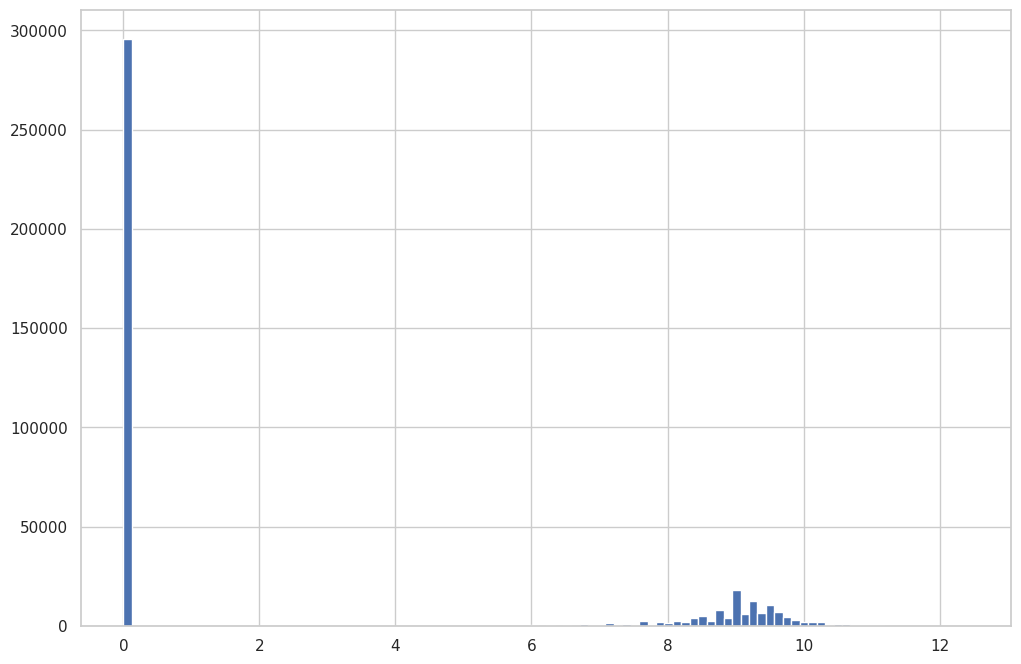

In [ ]:
np.log1p(df_SDMET['ingocup']).hist(bins=100);

In [ ]:
df_SDMET['ingocup'] = np.log1p(df_SDMET['ingocup'])

##ing_x_hrs: Promedio de ingreso por hora trabajada.


In [ ]:
col='ing_x_hrs'
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

Nulos: 0


Cantidad  Porcentaje
ing_x_hrs                      
0.00000      300032   72.747023
50.00000       4548    1.102727
41.66667       3440    0.834077
37.50000       3083    0.747517
62.50000       2857    0.692720
...             ...         ...
276.92308         1    0.000242
258.62069         1    0.000242
37.07449          1    0.000242
37.37500          1    0.000242
71.81943          1    0.000242

[5558 rows x 2 columns]

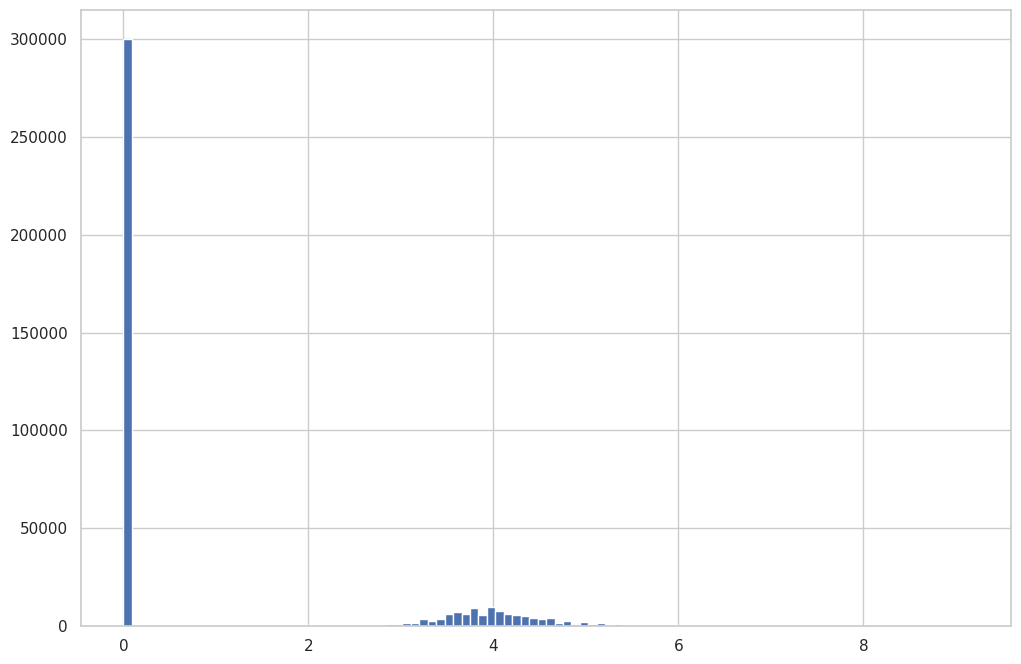

In [ ]:
np.log1p(df_SDMET['ing_x_hrs']).hist(bins=100);

In [ ]:
df_SDMET['ing_x_hrs']=np.log1p(df_SDMET['ing_x_hrs'])

##tpg_p8a: Sí buscó trabajo.

In [ ]:
col='tpg_p8a'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                       descrip
0    0                                     No aplica
1    1  Si busco trabajo (Para calculo de las tasas)

Nulos: 0


Cantidad  Porcentaje
tpg_p8a                      
0          406210   98.491388
1            6222    1.508612

##tcco: Clasificación de la población ocupada que trabajan menos de 35 horas más de 35 horas y de 48 horas.

In [ ]:
col='tcco'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve  \
0    0   
1    1   
2    2   
3    3   

                                                                                            descrip  
0                                                                                         No aplica  
1                             OH35RM (Ocupados que trabajan menos de 35 hrs por razones de mercado)  
2                     OH35SM (Ocupados que trabajan de 35 hrs ó más y ganan hasta 1 salario mínimo)  
3  OH48SM (Ocupados que trabajan mas de 48 horas con ingresos de más de 1 hasta 2 salarios mínimos)

Nulos: 0


Cantidad  Porcentaje
tcco                      
0       351459   85.216230
2        43093   10.448510
3        17521    4.248215
1          359    0.087045

Es redundante ya que se tiene ya las horas y los salarios de cada uno se tienen en otra columnas

In [ ]:
df_SDMET.drop('tcco', axis=1, inplace=True)

##cp_anoc: Clasificación de la población cuenta propia en actividades no calificadas.


In [ ]:
col='cp_anoc'
#display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

Nulos: 0


Cantidad  Porcentaje
cp_anoc                      
0          378897   91.868963
1           33535    8.131037

In [ ]:
df_SDMET.drop('cp_anoc', axis=1, inplace=True)

##imssissste: Instituciones de atención médica.


In [ ]:
col='imssissste'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                    descrip
0    0                  No aplica
1    1                       Imss
2    2                     Issste
3    3        Otras instituciones
4    4  No recibe atención médica
5    5            No especificado

Nulos: 0


Cantidad  Porcentaje
imssissste                      
0             220231   53.398136
4             109597   26.573350
1              67260   16.308143
2              12569    3.047533
5               1752    0.424797
3               1023    0.248041

##ma48me1sm: Población ocupada que trabaja más de 48 horas y gana menos de un salario mínimo.

In [ ]:
col='ma48me1sm'
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

Nulos: 0


Cantidad  Porcentaje
ma48me1sm                      
0            401552   97.361989
1             10880    2.638011

Redundante ya que tenmos columnas que tienen esta informacion

In [ ]:
df_SDMET.drop('ma48me1sm', axis=1, inplace=True)

##p14apoyos: Clasificación de la población por apoyos económicos.

In [ ]:
col='p14apoyos'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                      descrip
0    0                    No aplica
1    1  Si recibe apoyos económicos
2    2  No recibe apoyos económicos
3    3              No especificado

Nulos: 0


Cantidad  Porcentaje
p14apoyos                      
0            412432       100.0

Solo tiene un valor para nuestro dataset por lo que se elimina

In [ ]:
df_SDMET.drop('p14apoyos', axis=1, inplace=True)

##scian: Clasificación de actividades económicas con base en el sistema de clasificación Industrial de América del Norte.

In [ ]:
col='scian'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                                              descrip
0     0                                                            No aplica
1     1       Agricultura, ganadería, aprovechamiento forestal, pesca y caza
2     2                                                              Minería
3     3  Generación y distribución de electricidad, suministro de agua y gas
4     4                                                         Construcción
5     5                                           Industrias manufactureras 
6     6                                                Comercio al por mayor
7     7                                                Comercio al por menor
8     8                                Transportes, correos y almacenamiento
9     9                                        Información en medios masivos
10   10                                   Servicios financieros y de seguros
11   11                      Servicios inmobiliarios y de alquiler de bienes
12   12                      Servicios profesionales, científicos y técnicos
13   13                                                         Corporativos
14   14               Servicios de apoyo a los negocios y manejo de desechos
15   15                                                 Servicios educativos
16   16                            Servicios de salud y de asistencia social
17   17                  Servicios de esparcimiento, culturales y deportivos
18   18       Servicios de hospedaje y de preparación de alimentos y bebidas
19   19                 Otros servicios, excepto actividades gubernamentales
20   20          Actividades gubernamentales y de organismos internacionales
21   21                                                      No especificado

Nulos: 0


Cantidad  Porcentaje
scian                      
0        220231   53.398136
7         31716    7.689995
5         31081    7.536030
19        18321    4.442187
18        17517    4.247246
1         16345    3.963078
4         15532    3.765954
15         9777    2.370573
8          9518    2.307774
20         8498    2.060461
16         7211    1.748409
14         6198    1.502793
6          5582    1.353435
12         5177    1.255237
10         1826    0.442740
17         1749    0.424070
11         1451    0.351816
21         1444    0.350118
9          1313    0.318356
2           917    0.222340
3           811    0.196638
13          217    0.052615

##t_tra: Total de trabajos.

In [ ]:
col='t_tra'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))


cve          descrip
0    0        No aplica
1    1  Un solo trabajo
2    2     Dos trabajos

Nulos: 0


Cantidad  Porcentaje
t_tra                      
0        220231   53.398136
1        181526   44.013559
2         10675    2.588305

##emp_ppal: Clasificación de empleos formales e informales de la primera actividad.

Es el area de que pertence el trbajador

In [ ]:
col='emp_ppal'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve          descrip
0    0        No aplica
1    1  Empleo informal
2    2    Empleo formal

Nulos: 0


Cantidad  Porcentaje
emp_ppal                      
0           220231   53.398136
1           100253   24.307765
2            91948   22.294099

In [ ]:
df_SDMET['emp_ppal'] = df_SDMET['emp_ppal'].replace(0, 1)

In [ ]:
df_SDMET['emp_ppal']=df_SDMET['emp_ppal'].map({1: 1,2:0})

##tue_ppal: Tipo de unidad económica del trabajo principal.

Es el tipo de trbajo que es el trbajo

In [ ]:
col='tue_ppal'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                    descrip
0    0                  No aplica
1    1            Sector informal
2    2  Fuera del sector informal

Nulos: 0


Cantidad  Porcentaje
tue_ppal                      
0           220231   53.398136
2           139179   33.745927
1            53022   12.855937

In [ ]:
df_SDMET['tue_ppal'] = df_SDMET['tue_ppal'].replace(0, 1)

In [ ]:
df_SDMET['tue_ppal']=df_SDMET['tue_ppal'].map({1: 1,2:0})

##trans_ppal: Trabajadores transfronterizos del trabajo principal.

In [ ]:
col='trans_ppal'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                             descrip
0    0                           No aplica
1    1  Extranjero, embajadas o consulados
2    2                     Dentro del país

Nulos: 0


Cantidad  Porcentaje
trans_ppal                      
0             411866   99.862765
1                566    0.137235

Demasiado desbalanceado

In [ ]:
df_SDMET.drop('trans_ppal', axis=1, inplace=True)

##mh_fil2: Filas agregadas de la matriz.


In [ ]:
col='mh_fil2'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                             descrip
0    0                           No aplica
1    1                     Sector informal
2    2        Trabajo doméstico remunerado
3    3  Empresas, Gobierno e Instituciones
4    4                 Ámbito agropecuario

Nulos: 0


Cantidad  Porcentaje
mh_fil2                      
0          220231   53.398136
3          115398   27.979885
1           53022   12.855937
4           16345    3.963078
2            7436    1.802964

La organizaremos por estabilidad/formalidad

In [ ]:
mapeo_ambito_trabajo = {
    0: 0,
    1: 1,
    2: 2,
    4: 3,
    3: 4
}

df_SDMET['mh_fil2'] = df_SDMET['mh_fil2'].replace(mapeo_ambito_trabajo)

##mh_col: Columnas de la matriz Hussmanns del trabajo principal.

In [ ]:
col='mh_col'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve  \
0     0   
1     1   
2     2   
3     3   
4     4   
5     5   
6     6   
7     7   
8     8   
9     9   
10   10   

                                                                                descrip  
0                                                                             No aplica  
1                      Trabajadores subordinados y remunerados - Asalariados INFORMALES  
2                        Trabajadores subordinados y remunerados - Asalariados FORMALES  
3   Trabajadores subordinados y remunerados - Con percepciones no salariales INFORMALES  
4     Trabajadores subordinados y remunerados - Con percepciones no salariales FORMALES  
5                                                                  Empleadores INFORMAL  
6                                                                    Empleadores FORMAL  
7                                               Trabajadores por cuenta propia INFORMAL  
8                                                 Trabajadores por cuenta propia FORMAL  
9                                                  Trabajadores no Remunerados INFORMAL  
10                                                   Trabajadores no Remunerados FORMAL

Nulos: 0


Cantidad  Porcentaje
mh_col                      
0         220231   53.398136
2          80128   19.428172
1          50023   12.128787
7          32984    7.997440
9           6823    1.654333
6           6194    1.501823
5           5603    1.358527
8           5016    1.216200
3           4820    1.168678
4            610    0.147903

Se organiza por formalidad y estabilidad

In [ ]:
mapeo_mh_col = {
    0: 0,
    1: 1, 7: 1, 9: 1,
    2: 2, 3: 2, 4: 2,
    5: 3, 8: 3, 10: 3,
    6: 4,
}

df_SDMET['mh_col'] = df_SDMET['mh_col'].replace(mapeo_mh_col)
df_SDMET['mh_col'] = pd.to_numeric(df_SDMET['mh_col'], errors='coerce')

##sec_ins: Sectores institucionales del trabajo principal.

In [ ]:
col='sec_ins'
display(obtener_catalogo(sdem,col))
print(f"Nulos: {df_SDMET[col].isnull().sum()}")
display(values_can_porcentaje(df_SDMET,col))

cve                                              descrip
0     0                                            No aplica
1     1                            Instituciones financieras
2     2            Corporaciones y sociedades no financieras
3     3                                         Agropecuario
4     4                                      No agropecuario
5     5                                             Gobierno
6     6                                             Privadas
7     7                                             Públicas
8     8                                      Sector Informal
9     9                         Trabajo doméstico remunerado
10   10                          Agricultura de subsistencia
11   11  Situaciones de carácter especial y no especificadas

Nulos: 0


Cantidad  Porcentaje
sec_ins                      
0          220231   53.398136
2           54408   13.191993
8           53022   12.855937
4           32645    7.915244
7           13356    3.238352
3           12698    3.078811
5            8485    2.057309
9            7436    1.802964
10           3647    0.884267
6            3494    0.847170
1            1743    0.422615
11           1267    0.307202

In [ ]:
obtener_catalogo(sdem,'c_res')

cve             descrip
0    1  Residente habitual
1    2  Ausente definitivo
2    3     Nuevo residente

In [ ]:
values_can_porcentaje(df_SDMET,'c_res')

Cantidad  Porcentaje
c_res                      
1        404143   97.990214
3          8289    2.009786

In [ ]:
df_SDMET['c_res'] = df_SDMET['c_res'].map({1: 1, 3: 0})

##Tabla persona final

In [ ]:
df_SDMET.sample(n=10)

cve_ent    con  v_sel  n_hog  h_mud  n_ren  c_res           par_c  \
197955       11  40502     51      1      0      1      1      Jefe_Hogar   
21230        29  40312     54      1      0      2      1  Conyuge_Pareja   
102819       22  50009     52      1      0      3      1    Hijos_Nietos   
215151       16  50064     59      1      0      2      1  Conyuge_Pareja   
238370       20  40123     55      1      0      2      1  Conyuge_Pareja   
385504       20  60064     57      1      0      1      1      Jefe_Hogar   
292566       30  41345     54      1      0      3      1    Hijos_Nietos   
408917        5  41201      3      1      0      3      1    Hijos_Nietos   
122087       31  60038     63      1      0      3      1    Hijos_Nietos   
235558       30  60055     64      1      0      2      1  Conyuge_Pareja   

        sex   eda  cs_p12  cs_p13_1  cs_p13_2 cs_p14_c  cs_p16  cs_p17  n_hij  \
197955    1  65.0       1       2.0       6.0        0       0       0    0.0   
21230     0  53.0       1       3.0       3.0        0       0       0    4.0   
102819    1  33.0       1       7.0       4.0      071       1       0    0.0   
215151    0  36.0       1       4.0       3.0        0       0       0    2.0   
238370    1  46.0       1       4.0       3.0        0       0       0    0.0   
385504    1  36.0       1       3.0       3.0        0       0       0    0.0   
292566    0   2.0       0       0.0       0.0        0       0       0    0.0   
408917    1  10.0       1       2.0       4.0        0       0       1    0.0   
122087    0   8.0       1       2.0       2.0        0       0       1    0.0   
235558    0  52.0       1       2.0       6.0        0       0       0    2.0   

        e_con  cs_p20a_1  zona  clase1  clase2  clase3  pos_ocu  seg_soc  \
197955    5.0        1.0     0       1       1       1        3        2   
21230     5.0        1.0     0       2       4       0        0        0   
102819    6.0        1.0     0       1       1       1        1        1   
215151    5.0        1.0     0       1       1       1        1        1   
238370    5.0        1.0     0       1       1       1        4        2   
385504    1.0        1.0     0       1       1       1        1        2   
292566    6.0        1.0     0       0       0       0        0        0   
408917    6.0        1.0     0       0       0       0        0        0   
122087    6.0        1.0     0       0       0       0        0        0   
235558    1.0        1.0     0       2       4       0        0        0   

        rama  c_ocu11c  ing7c  dur9c  emple7c  medica5c  buscar5c  rama_est1  \
197955     3         6      1   19.5      1.0         1         4          3   
21230      0         0      0    0.0      0.0         0         0          0   
102819     2         1      2   44.0     75.0         3         4          2   
215151     3         6      2   44.0     33.0         3         4          3   
238370     3         6      0   60.0      3.5         1         4          3   
385504     4         5      1   19.5      3.5         1         2          3   
292566     0         0      0    0.0      0.0         0         0          0   
408917     0         0      0    0.0      0.0         0         0          0   
122087     0         0      0    0.0      0.0         0         0          0   
235558     0         0      0    0.0      0.0         0         0          0   

        rama_est2  ambito1  ambito2  tue1  tue2  tue3  busqueda  d_ant_lab  \
197955          5        0        1     3     5     0         2          0   
21230           0        0        0     0     0     0         0          0   
102819          3        0        5     1     1     0         2          0   
215151          5        0        4     1     1     0         2          0   
238370          5        0        1     3     5     0         2          0   
385504         10        0        2     1     2     0         2          0   
2925

In [ ]:
df_SDMET

cve_ent    con  v_sel  n_hog  h_mud  n_ren  c_res            par_c  \
0            15  40170      2      1      0      1      1       Jefe_Hogar   
1            19  40270      1      1      0      1      1       Jefe_Hogar   
2            19  40270      1      1      0      3      1     Hijos_Nietos   
3            21  40101     53      1      0      3      1     Hijos_Nietos   
4            21  40364     54      1      0      1      1       Jefe_Hogar   
...         ...    ...    ...    ...    ...    ...    ...              ...   
422301       17  60014     66      1      0      3      1     Hijos_Nietos   
422302       20  60009     20      1      0      1      1       Jefe_Hogar   
422303       27  60016     59      1      0      1      1       Jefe_Hogar   
422304       29  60049     88      1      0      7      1  Familia_Extensa   
422305       30  60024     82      1      0      4      1     Hijos_Nietos   

        sex   eda  cs_p12  cs_p13_1  cs_p13_2 cs_p14_c  cs_p16  cs_p17  n_hij  \
0         1  64.0       1       3.0       3.0        0       0       0    0.0   
1         1  58.0       1       6.0       2.0      071       1       0    0.0   
2         0  19.0       1       7.0       1.0      041       0       1    0.0   
3         0  28.0       1       7.0       5.0      091       1       0    0.0   
4         0  49.0       1       3.0       3.0        0       0       0    2.0   
...     ...   ...     ...       ...       ...      ...     ...     ...    ...   
422301    0  31.0       1       3.0       3.0        0       0       0    0.0   
422302    1  61.0       1       2.0       3.0        0       0       0    0.0   
422303    1  77.0       1       2.0       2.0        0       0       0    0.0   
422304    0  56.0       1       2.0       6.0        0       0       0    1.0   
422305    0  13.0       1       2.0       6.0        0       0       1    0.0   

        e_con  cs_p20a_1  zona  clase1  clase2  clase3  pos_ocu  seg_soc  \
0         5.0        1.0     0       2       4       0        0        0   
1         5.0        1.0     0       1       1       1        2        2   
2         6.0        1.0     0       2       4       0        0        0   
3         6.0        1.0     0       1       1       1        1        2   
4         4.0        1.0     0       1       1       1        1        2   
...       ...        ...   ...     ...     ...     ...      ...      ...   
422301    6.0        1.0     0       2       4       0        0        0   
422302    5.0        1.0     0       1       1       1        3        2   
422303    5.0        1.0     0       2       4       0        0        0   
422304    6.0        1.0     0       1       1       1        1        2   
422305    6.0        1.0     0       2       4       0        0        0   

        rama  c_ocu11c  ing7c  dur9c  emple7c  medica5c  buscar5c  rama_est1  \
0          0         0      0    0.0      0.0         0         0          0   
1          4         5      4   44.0     13.0         1         4          3   
2          0         0      0    0.0      0.0         0         0          0   
3          4         1      1   19.5     13.0         1         4          3   
4          4         8      1   37.0      1.0         4         4          3   
...      ...       ...    ...    ...      ...       ...       ...        ...   
422301     0         0      0    0.0      0.0         0         0          0   
422302     1         5      1    7.5      1.0         1         4          2   
422303     0         0      0    0.0      0.0         0         0          0   
422304     4         8      2   44.0      3.5         4         4          3   
422305     0         0      0    0.0      0.0         0         0          0   

        rama_est2  ambito1  ambito2  tue1  tue2  tue3  busqueda  d_ant_lab  \
0               0        0        0     0     0     0         0          0   
1               7        0        3     1     1     0         2     

In [ ]:
display(missings_can_porcentaje(df_SDMET))

None

#Cuestionarios

##Analizar informacion



In [ ]:
cols_E_C1

['r_def',
 'cve_mun',
 'cd_a',
 'cve_ent',
 'con',
 'upm',
 'd_sem',
 'n_pro_viv',
 'v_sel',
 'n_hog',
 'h_mud',
 'n_ent',
 'per',
 'n_ren',
 'eda',
 'ur',
 'fac_tri',
 'fac_men',
 'tipo',
 'mes_cal',
 'cvegeo']

In [ ]:
llaves_custionario = ['cve_ent', 'con', 'v_sel', 'n_hog', 'h_mud', 'n_ren','tipo']

In [ ]:
columnas_comunes = list(set(cols_E_C1) - set(llaves_custionario))
columnas_comunes

['r_def',
 'd_sem',
 'mes_cal',
 'n_pro_viv',
 'per',
 'n_ent',
 'fac_men',
 'cve_mun',
 'fac_tri',
 'upm',
 'eda',
 'cd_a',
 'ur',
 'cvegeo']

In [ ]:
df_COE1T.drop(columnas_comunes, axis=1, inplace=True)

In [ ]:
values_can_porcentaje(df_COE1T,'p1a1')

Cantidad  Porcentaje
p1a1                      
        344641   99.456603
1         1883    0.543397

In [ ]:
df_COE1T

cve_ent    con  v_sel  n_hog  h_mud  n_ren  n_inf  p1 p1a1 p1a2 p1a3  \
0             9  40002     52      1      0      2      2   1                  
1             9  40002     52      1      0      1      2   2              3   
2             9  40002     52      1      0      3      2   2              3   
3             9  40008     55      1      0      1      1   2              3   
4             9  40008     55      1      0      2      1   1                  
...         ...    ...    ...    ...    ...    ...    ...  ..  ...  ...  ...   
346519       32  60056     62      1      1      1      2   2              3   
346520       32  60056     62      1      1      2      2   2              3   
346521       32  60060     15      1      0      1      2   1                  
346522       32  60060     15      1      0      2      2   1                  
346523       32  60070     10      1      0      1      1   2              3   

       p1b p1c p1d p1e p2_1 p2_2 p2_3 p2_4 p2_9 p2a_dia p2a_sem p2a_mes  \
0                                                                         
1        2                               4                                
2        2                               4                                
3        2                               4                                
4                                                                         
...     ..  ..  ..  ..  ...  ...  ...  ...  ...     ...     ...     ...   
346519   2                               4                                
346520   2                               4                                
346521                                                                    
346522                                                                    
346523   2                               4                                

       p2a_anio p2b_dia p2b_sem p2b_mes p2b_anio p2b p2c p2d1 p2d2 p2d3 p2d4  \
0                                                                              
1                                                                              
2                                                                              
3                                                                              
4                                                                              
...         ...     ...     ...     ...      ...  ..  ..  ...  ...  ...  ...   
346519                                                                         
346520                                                                         
346521                                                                         
346522                                                                         
346523                                                                         

       p2d5 p2d6 p2d7 p2d8 p2d9 p2d10 p2d11 p2d99 p2e p2f p2g1 p2g2 p2h1 p2h2  \
0                                                                               
1                                                   2   3              1        
2                                                   6   3              1        
3                                                   2   3              1        
4                                                                               
...     ...  ...  ...  ...  ...   ...   ...   ...  ..  ..  ...  ...  ...  ...   
346519                                              4   3              1        
346520                                              4   3              1        
346521                                                                          
346522                                                                          
346523                                              6   3              1        

       p2h3 p2h4 p2h9 p2i p2j p2k_anio p2k_mes p2k    p3 p3a p3b p3c1 p3c2  \
0                                                   8341   1                 
1                       4         2025       5   1      

In [ ]:
df_COE1T['cve_ent'] = df_COE1T['cve_ent'].astype(str).str.zfill(5)

In [ ]:
df_SDMET['cve_ent'] = df_SDMET['cve_ent'].astype(str).str.zfill(5)

keys_from_sdem = df_SDMET[llaves_custionario].drop_duplicates()

df_COE1T = pd.merge(df_COE1T, keys_from_sdem, on=llaves_custionario, how='inner')

In [ ]:
values_can_porcentaje(df_COE1T,'p1a1')

Cantidad  Porcentaje
p1a1                      
        344641   99.456603
1         1883    0.543397

In [ ]:
for col in df_COE1T[df_COE1T.columns.difference(llaves_custionario)].columns:
  display(values_can_porcentaje(df_COE1T,col))

Cantidad  Porcentaje
n_inf                      
1        145903   42.104732
2        137113   39.568111
3         33273    9.601932
4         16051    4.632002
5          6846    1.975621
6          2974    0.858238
7          1402    0.404590
97          983    0.283674
8           663    0.191329
99          581    0.167665
9           406    0.117164
10          189    0.054542
11           62    0.017892
12           39    0.011255
13           13    0.003752
14           13    0.003752
17            6    0.001731
15            5    0.001443
19            1    0.000289
20            1    0.000289

Cantidad  Porcentaje
p1                      
1     182983   52.805289
2     163541   47.194711

Cantidad  Porcentaje
p1a1                      
        344641   99.456603
1         1883    0.543397

Cantidad  Porcentaje
p1a2                      
        345071   99.580693
2         1453    0.419307

Cantidad  Porcentaje
p1a3                      
        186318   53.767704
3       160206   46.232296

Cantidad  Porcentaje
p1b                      
       186318   53.767704
2      148093   42.736722
1       12113    3.495573

Cantidad  Porcentaje
p1c                      
       334411   96.504427
5        4204    1.213192
6        3294    0.950584
8        2626    0.757812
12        638    0.184114
10        529    0.152659
9         465    0.134190
11        125    0.036073
7         123    0.035495
3          50    0.014429
2          21    0.006060
99         17    0.004906
4          16    0.004617
1           5    0.001443

Cantidad  Porcentaje
p1d                      
       334628   96.567049
2        7404    2.136649
1        4441    1.281585
9          51    0.014718

Cantidad  Porcentaje
p1e                      
       339069   97.848634
2        3762    1.085639
1        1350    0.389583
3        1036    0.298969
4        1025    0.295795
9         263    0.075897
5          19    0.005483

Cantidad  Porcentaje
p2_1                      
        346410   99.967102
1          114    0.032898

Cantidad  Porcentaje
p2_2                      
        340590   98.287564
2         5934    1.712436

Cantidad  Porcentaje
p2_3                      
        346389   99.961042
3          135    0.038958

Cantidad  Porcentaje
p2_4                      
        198426   57.261835
4       148098   42.738165

Cantidad  Porcentaje
p2_9                      
        346439   99.975471
9           85    0.024529

Cantidad  Porcentaje
p2a_anio                      
            340384   98.228117
2025          5891    1.700027
2024           182    0.052522
2023            31    0.008946
2022            12    0.003463
2020             7    0.002020
2021             5    0.001443
2019             4    0.001154
9999             3    0.000866
2015             3    0.000866
2006             2    0.000577

Cantidad  Porcentaje
p2a_dia                      
           340384   98.228117
99           1820    0.525216
1             839    0.242119
15            638    0.184114
20            301    0.086863
2             240    0.069259
25            196    0.056562
10            193    0.055696
5             191    0.055119
30            139    0.040113
4             122    0.035207
8             114    0.032898
28            112    0.032321
3             110    0.031744
12            110    0.031744
18            102    0.029435
14             98    0.028281
7              96    0.027704
16             91    0.026261
11             78    0.022509
22             67    0.019335
6              67    0.019335
9              59    0.017026
21             58    0.016738
23             54    0.015583
17             41    0.011832
26             38    0.010966
24             35    0.010100
29             32    0.009235
27             30    0.008657
13             28    0.008080
19             27    0.007792
31             14    0.004040

Cantidad  Porcentaje
p2a_mes                      
           340384   98.228117
7            1577    0.455091
8            1345    0.388141
6            1280    0.369383
5             573    0.165357
9             435    0.125532
1             272    0.078494
4             222    0.064065
2             175    0.050502
3             166    0.047904
99             37    0.010677
12             29    0.008369
11             18    0.005194
10             11    0.003174

Cantidad  Porcentaje
p2a_sem                      
           344704   99.474784
1             741    0.213838
2             451    0.130150
4             280    0.080802
9             197    0.056850
3             151    0.043576

Cantidad  Porcentaje
p2b                      
       340384   98.228117
1        5752    1.659914
2         218    0.062911
4          93    0.026838
3          71    0.020489
9           6    0.001731

Cantidad  Porcentaje
p2b_anio                      
            340384   98.228117
2025          6112    1.763803
2024            19    0.005483
9999             6    0.001731
2023             2    0.000577
2022             1    0.000289

Cantidad  Porcentaje
p2b_dia                      
           340384   98.228117
99            857    0.247313
15            407    0.117452
1             321    0.092634
30            277    0.079937
8             234    0.067528
10            231    0.066662
18            227    0.065508
5             224    0.064642
25            217    0.062622
28            206    0.059448
2             206    0.059448
22            205    0.059159
20            195    0.056273
4             193    0.055696
12            178    0.051367
11            160    0.046173
7             145    0.041844
21            143    0.041267
14            138    0.039824
29            133    0.038381
3             131    0.037804
17            121    0.034918
23            120    0.034630
9             118    0.034052
19            118    0.034052
6             107    0.030878
26            101    0.029147
13             99    0.028569
24             92    0.026549
27             87    0.025106
16             78    0.022509
31             71    0.020489

Cantidad  Porcentaje
p2b_mes                      
           340384   98.228117
7            2007    0.579181
8            1999    0.576872
9            1412    0.407475
6             584    0.168531
5              61    0.017603
4              30    0.008657
3              14    0.004040
1              11    0.003174
2               7    0.002020
99              6    0.001731
10              5    0.001443
12              3    0.000866
11              1    0.000289

Cantidad  Porcentaje
p2b_sem                      
           345667   99.752687
4             235    0.067816
1             234    0.067528
2             198    0.057139
3             114    0.032898
9              76    0.021932

Cantidad  Porcentaje
p2c                      
       340483   98.256686
1        5930    1.711281
2         108    0.031167
9           3    0.000866

Cantidad  Porcentaje
p2d1                      
        342751   98.911187
1         3773    1.088813

Cantidad  Porcentaje
p2d10                      
         346513   99.996826
10           11    0.003174

Cantidad  Porcentaje
p2d11                      
         346468    99.98384
11           56     0.01616

Cantidad  Porcentaje
p2d2                      
        346476   99.986148
2           48    0.013852

Cantidad  Porcentaje
p2d3                      
        346468    99.98384
3           56     0.01616

Cantidad  Porcentaje
p2d4                      
        346467   99.983551
4           57    0.016449

Cantidad  Porcentaje
p2d5                      
        346467   99.983551
5           57    0.016449

Cantidad  Porcentaje
p2d6                      
        344747   99.487193
6         1777    0.512807

Cantidad  Porcentaje
p2d7                      
        346465   99.982974
7           59    0.017026

Cantidad  Porcentaje
p2d8                      
        346497   99.992208
8           27    0.007792

Cantidad  Porcentaje
p2d9                      
        345806   99.792799
9          718    0.207201

Cantidad  Porcentaje
p2d99                      
         346491   99.990477
99           33    0.009523

Cantidad  Porcentaje
p2e                      
       198131   57.176703
4       66803   19.278030
3       48609   14.027600
2       17670    5.099214
6        8151    2.352218
1        5533    1.596715
5        1603    0.462594
9          24    0.006926

Cantidad  Porcentaje
p2f                      
       205267   59.236013
3      117540   33.919729
1       19566    5.646362
2        4010    1.157207
9         141    0.040690

Cantidad  Porcentaje
p2g1                      
        322807   93.155741
2        13730    3.962208
1         9902    2.857522
9           85    0.024529

Cantidad  Porcentaje
p2g2                      
        336622   97.142478
9         3606    1.040621
12        1574    0.454225
7         1543    0.445279
4         1498    0.432293
5          599    0.172860
10         429    0.123801
3          275    0.079360
11         135    0.038958
8          112    0.032321
2           66    0.019046
1           34    0.009812
6           31    0.008946

Cantidad  Porcentaje
p2h1                      
        276782   79.873833
1        69742   20.126167

Cantidad  Porcentaje
p2h2                      
        334072   96.406598
2        12452    3.593402

Cantidad  Porcentaje
p2h3                      
        343313   99.073369
3         3211    0.926631

Cantidad  Porcentaje
p2h4                      
        275899   79.619016
4        70625   20.380984

Cantidad  Porcentaje
p2h9                      
        346298   99.934781
9          226    0.065219

Cantidad  Porcentaje
p2i                      
       268585   77.508340
2       36059   10.405917
4       17550    5.064584
1       10655    3.074823
3        7242    2.089899
5        4938    1.425010
8        1072    0.309358
6         226    0.065219
9         156    0.045019
7          41    0.011832

Cantidad  Porcentaje
p2j                      
       334641   96.570800
2        2725    0.786381
5        2558    0.738188
1        1804    0.520599
7        1576    0.454803
6        1492    0.430562
4        1475    0.425656
9         176    0.050790
3          77    0.022221

Cantidad  Porcentaje
p2k                      
       263052   75.911625
3       52848   15.250892
1       21965    6.338666
2        7733    2.231591
9         926    0.267225

Cantidad  Porcentaje
p2k_anio                      
            263052   75.911625
2025         21965    6.338666
2024          7733    2.231591
2023          6659    1.921656
2020          5420    1.564105
...            ...         ...
1957             6    0.001731
1959             3    0.000866
1956             2    0.000577
1953             1    0.000289
1951             1    0.000289

[77 rows x 2 columns]

Cantidad  Porcentaje
p2k_mes                      
           315900   91.162517
7            5703    1.645773
6            5333    1.538999
8            4601    1.327758
5            3372    0.973093
4            1939    0.559557
1            1588    0.458266
2            1587    0.457977
12           1534    0.442682
3            1531    0.441816
99           1150    0.331867
9            1130    0.326096
11            685    0.197678
10            471    0.135921

Cantidad  Porcentaje
p3                        
        154323   44.534578
4211     11814    3.409288
4111      8653    2.497085
9611      5957    1.719073
7121      5473    1.579400
...        ...         ...
1319         1    0.000289
2141         1    0.000289
9634         1    0.000289
2649         1    0.000289
2134         1    0.000289

[484 rows x 2 columns]

Cantidad  Porcentaje
p3a                      
       154323   44.534578
1      141905   40.950988
2       50296   14.514435

Cantidad  Porcentaje
p3b                      
       296228   85.485565
1       49797   14.370433
2         499    0.144002

Cantidad  Porcentaje
p3c1                      
        344894   99.529614
1         1630    0.470386

Cantidad  Porcentaje
p3c2                      
        342729   98.904838
2         3795    1.095162

Cantidad  Porcentaje
p3c3                      
        302354   87.253408
3        44170   12.746592

Cantidad  Porcentaje
p3c4                      
        344461   99.404659
4         2063    0.595341

Cantidad  Porcentaje
p3c9                      
        346506   99.994806
9           18    0.005194

Cantidad  Porcentaje
p3d                      
       296727   85.629567
2       31250    9.018134
1       18527    5.346527
9          20    0.005772

Cantidad  Porcentaje
p3e                      
       327997   94.653473
1       18443    5.322286
2          84    0.024241

Cantidad  Porcentaje
p3f1                      
        327997   94.653473
1        14698    4.241553
9         1920    0.554074
3         1624    0.468654
2          285    0.082245

Cantidad  Porcentaje
p3f2                      
        346239   99.917755
2          183    0.052810
3           50    0.014429
4           26    0.007503
5            8    0.002309
7            6    0.001731
6            3    0.000866
10           2    0.000577
9            2    0.000577
15           1    0.000289
8            1    0.000289
14           1    0.000289
99           1    0.000289
28           1    0.000289

Cantidad  Porcentaje
p3g1_1                      
          334727   96.595618
1          11797    3.404382

Cantidad  Porcentaje
p3g1_2                      
          334727   96.595618
1           4677    1.349690
2           2515    0.725779
999         1939    0.559557
3            992    0.286272
4            474    0.136787
5            349    0.100715
6            207    0.059736
10           141    0.040690
8            116    0.033475
15            63    0.018181
7             55    0.015872
20            43    0.012409
12            38    0.010966
9             30    0.008657
30            20    0.005772
14            15    0.004329
11            15    0.004329
18            12    0.003463
50             9    0.002597
99             9    0.002597
40             8    0.002309
25             7    0.002020
13             6    0.001731
35             5    0.001443
16             4    0.001154
23             3    0.000866
45             3    0.000866
57             3    0.000866
60             3    0.000866
48             3    0.000866
80             3    0.000866
17             3    0.000866
38             2    0.000577
19             2    0.000577
500            2    0.000577
78             2    0.000577
32             2    0.000577
43             1    0.000289
56             1    0.000289
24             1    0.000289
81             1    0.000289
22             1    0.000289
250            1    0.000289
200            1    0.000289
150            1    0.000289
270            1    0.000289
37             1    0.000289
46             1    0.000289
21             1    0.000289
300            1    0.000289
29             1    0.000289
27             1    0.000289
28             1    0.000289
100            1    0.000289

Cantidad  Porcentaje
p3g2_1                      
          343503   99.128199
2           3021    0.871801

Cantidad  Porcentaje
p3g2_2                      
          343503   99.128199
1           2432    0.701827
2            331    0.095520
3            144    0.041556
4             49    0.014140
5             23    0.006637
6             16    0.004617
9              5    0.001443
7              4    0.001154
10             3    0.000866
8              3    0.000866
999            2    0.000577
30             2    0.000577
13             1    0.000289
26             1    0.000289
85             1    0.000289
110            1    0.000289
35             1    0.000289
15             1    0.000289
120            1    0.000289

Cantidad  Porcentaje
p3g3_1                      
          341431   98.530261
3           5093    1.469739

Cantidad  Porcentaje
p3g3_2                      
          341431   98.530261
1           3755    1.083619
2            927    0.267514
3            302    0.087151
4             79    0.022798
5             17    0.004906
7              5    0.001443
6              4    0.001154
8              3    0.000866
9              1    0.000289

Cantidad  Porcentaje
p3g4_1                      
          346501   99.993363
4             23    0.006637

Cantidad  Porcentaje
p3g4_2                      
          346501   99.993363
1             15    0.004329
2              6    0.001731
999            1    0.000289
3              1    0.000289

Cantidad  Porcentaje
p3g9                      
        346457   99.980665
9           67    0.019335

Cantidad  Porcentaje
p3g_tot                      
           328080   94.677425
1            9119    2.631564
2            3717    1.072653
999          1924    0.555228
3            1547    0.446434
...           ...         ...
86              1    0.000289
29              1    0.000289
28              1    0.000289
100             1    0.000289
160             1    0.000289

[68 rows x 2 columns]

Cantidad  Porcentaje
p3h                      
       204120   58.905011
1      135581   39.126006
3        6350    1.832485
2         473    0.136498

Cantidad  Porcentaje
p3i                      
       210943   60.873994
1       80266   23.163186
2       51878   14.970969
9        3437    0.991850

Cantidad  Porcentaje
p3j1                      
        266258   76.836814
2        68533   19.777274
1        10772    3.108587
9          961    0.277326

Cantidad  Porcentaje
p3j2                      
        335752   96.891413
2         4402    1.270330
3         3639    1.050144
4         1724    0.497512
1         1007    0.290600

Cantidad  Porcentaje
p3k1                      
        254934    73.56893
1        91590    26.43107

Cantidad  Porcentaje
p3k2                      
        264685   76.382877
2        81839   23.617123

Cantidad  Porcentaje
p3k3                      
        309487   89.311851
3        37037   10.688149

Cantidad  Porcentaje
p3k4                      
        343023    98.98968
4         3501     1.01032

Cantidad  Porcentaje
p3k5                      
        308923   89.149092
5        37601   10.850908

Cantidad  Porcentaje
p3k9                      
        344286   99.354157
9         2238    0.645843

Cantidad  Porcentaje
p3l                      
       204120   58.905011
2       40573   11.708569
11      21944    6.332606
99      15728    4.538791
3       14174    4.090337
8        7777    2.244289
9        6857    1.978795
4        6704    1.934642
7        6647    1.918193
5        6005    1.732925
6        5883    1.697718
10       5517    1.592098
1        4595    1.326026

Cantidad  Porcentaje
p4                      
      154323   44.534578
1     123013   35.499128
2      59671   17.219875
3       8045    2.321629
9        917    0.264628
4        555    0.160162

Cantidad  Porcentaje
p4_1                      
        321444   92.762406
1        20579    5.938694
2         4480    1.292840
9           21    0.006060

Cantidad  Porcentaje
p4_2                      
        321445   92.762695
3         9884    2.852328
5         4111    1.186354
6         3380    0.975401
1         2929    0.845252
4         2819    0.813508
2         1824    0.526370
9           66    0.019046
7           64    0.018469
8            2    0.000577

Cantidad  Porcentaje
p4_3                      
        286557   82.694705
2        57960   16.726114
1         2007    0.579181

Cantidad  Porcentaje
p4a                       
        154323   44.534578
7221     13576    3.917766
1110     13368    3.857741
4611     10208    2.945828
8140      7436    2.145883
...        ...         ...
1142         1    0.000289
5199         1    0.000289
6259         1    0.000289
6119         1    0.000289
7115         1    0.000289

[177 rows x 2 columns]

Cantidad  Porcentaje
p4a_1                      
1        163792   47.267145
         154361   44.545544
2         28371    8.187312

Cantidad  Porcentaje
p4b                      
       162923   47.016368
4      142870   41.229468
1       15499    4.472706
2       12615    3.640440
3       12590    3.633226
5          27    0.007792

Cantidad  Porcentaje
p4c                      
       203627   58.762741
1       87137   25.146022
2       55748   16.087775
3          12    0.003463

Cantidad  Porcentaje
p4d1                      
        321307   92.722871
1        20528    5.923976
2         4671    1.347959
9           18    0.005194

Cantidad  Porcentaje
p4d2                      
        321325   92.728065
3        10363    2.990558
5         3902    1.126040
6         3341    0.964147
1         3092    0.892290
4         2383    0.687687
2         1988    0.573698
7          119    0.034341
9            6    0.001731
8            5    0.001443

Cantidad  Porcentaje
p4d3                      
        266054   76.777943
3        70749   20.416768
2         8675    2.503434
1         1046    0.301855

Cantidad  Porcentaje
p4e                      
       259387   74.853978
4       43071   12.429442
3       36759   10.607923
1        4220    1.217809
2        2951    0.851600
9         136    0.039247

Cantidad  Porcentaje
p4f                      
       303317   87.531311
8       18039    5.205700
6        9135    2.636181
5        5200    1.500618
7        2660    0.767624
3        2344    0.676432
2        1989    0.573986
9        1855    0.535316
4         870    0.251065
11        391    0.112835
10        390    0.112546
1         282    0.081380
99         52    0.015006

Cantidad  Porcentaje
p4g                      
       263607   76.071787
4       37759   10.896504
1       18703    5.397317
2       13821    3.988468
9        6960    2.008519
3        5674    1.637405

Cantidad  Porcentaje
p4h                      
       286556   82.694417
1       50576   14.595237
2        4196    1.210883
4        2240    0.646420
3        2191    0.632279
5         729    0.210375
9          36    0.010389

Cantidad  Porcentaje
p4i                      
       286556   82.694417
2       20700    5.973612
3       19675    5.677817
1       14907    4.301867
9        2439    0.703847
4        2247    0.648440

Cantidad  Porcentaje
p4i_1                      
         286557   82.694705
3         57960   16.726114
1          1870    0.539645
2           137    0.039536

Cantidad  Porcentaje
p5                      
3     171972   49.627731
      154878   44.694740
1      13405    3.868419
2       6005    1.732925
9        264    0.076185

Cantidad  Porcentaje
p5a                      
       333119   96.131581
1        8531    2.461879
3        2348    0.677587
2        1109    0.320036
4         658    0.189886
6         587    0.169397
5         147    0.042421
9          25    0.007215

Cantidad  Porcentaje
p5b_hdo                      
           160883   46.427664
0          140317   40.492722
8           15997    4.616419
12           4979    1.436841
10           4522    1.304960
6            3836    1.106994
9            3168    0.914222
5            3107    0.896619
4            2069    0.597073
7            1770    0.510787
3            1380    0.398241
2            1043    0.300989
98            688    0.198543
11            640    0.184691
1             420    0.121204
16            413    0.119184
14            376    0.108506
13            216    0.062333
15            199    0.057427
17            159    0.045884
24            137    0.039536
18            134    0.038670
99             43    0.012409
20             12    0.003463
19             11    0.003174
21              2    0.000577
22              2    0.000577
23              1    0.000289

Cantidad  Porcentaje
p5b_hju                      
           160883   46.427664
8           73951   21.340802
0           21117    6.093950
9           18171    5.243793
10          17342    5.004560
6           12080    3.486050
12           9705    2.800672
5            7875    2.272570
7            7798    2.250349
4            5616    1.620667
3            3285    0.947986
2            2366    0.682781
11           1937    0.558980
98           1554    0.448454
1             879    0.253662
14            556    0.160451
16            408    0.117741
13            349    0.100715
15            296    0.085420
17            105    0.030301
18            105    0.030301
24             63    0.018181
99             56    0.016160
20             11    0.003174
19              7    0.002020
23              3    0.000866
21              3    0.000866
22              3    0.000866

Cantidad  Porcentaje
p5b_hlu                      
           160883   46.427664
8           73729   21.276737
0           20130    5.809121
9           18066    5.213492
10          17254    4.979165
6           12255    3.536552
12           9900    2.856945
5            7934    2.289596
7            7627    2.201002
4            5782    1.668571
3            3570    1.030232
2            2563    0.739631
11           1907    0.550323
98           1563    0.451051
1             867    0.250199
16            578    0.166799
14            574    0.165645
13            351    0.101292
15            320    0.092346
17            222    0.064065
18            202    0.058293
24            164    0.047327
99             54    0.015583
20             13    0.003752
19              9    0.002597
21              4    0.001154
23              2    0.000577
22              1    0.000289

Cantidad  Porcentaje
p5b_hma                      
           160883   46.427664
8           73245   21.137064
0           22873    6.600697
9           18065    5.213203
10          17216    4.968198
6           12033    3.472487
12           9581    2.764888
5            7690    2.219183
7            7663    2.211391
4            5487    1.583440
3            3310    0.955201
2            2334    0.673546
11           1911    0.551477
98           1565    0.451628
1             838    0.241830
14            562    0.162182
13            357    0.103023
15            319    0.092057
16            303    0.087440
17             83    0.023952
18             69    0.019912
24             58    0.016738
99             56    0.016160
20             13    0.003752
19              6    0.001731
23              2    0.000577
21              2    0.000577

Cantidad  Porcentaje
p5b_hmi                      
           160883   46.427664
8           74211   21.415833
0           19396    5.597304
9           18245    5.265148
10          17348    5.006291
6           12294    3.547806
12           9825    2.835301
5            8042    2.320763
7            7749    2.236209
4            5847    1.687329
3            3547    1.023594
2            2483    0.716545
11           1930    0.556960
98           1583    0.456823
1             936    0.270111
14            578    0.166799
16            423    0.122069
13            361    0.104177
15            318    0.091769
17            171    0.049347
18            151    0.043576
24            119    0.034341
99             54    0.015583
20             15    0.004329
19              7    0.002020
21              5    0.001443
23              2    0.000577
22              1    0.000289

Cantidad  Porcentaje
p5b_hsa                      
           160883   46.427664
0           69092   19.938590
8           41335   11.928467
6           15467    4.463472
5           14729    4.250499
10           9488    2.738050
9            7571    2.184841
12           7171    2.069409
4            6326    1.825559
7            5388    1.554871
3            2626    0.757812
2            1773    0.511653
98           1232    0.355531
11           1162    0.335330
1             589    0.169974
14            496    0.143136
13            318    0.091769
16            307    0.088594
15            281    0.081091
17             93    0.026838
24             74    0.021355
99             55    0.015872
18             53    0.015295
20              7    0.002020
19              6    0.001731
23              1    0.000289
22              1    0.000289

Cantidad  Porcentaje
p5b_hvi                      
           160883   46.427664
8           74946   21.627939
0           18760    5.413766
9           18365    5.299777
10          17510    5.053041
6           12532    3.616488
12           9207    2.656959
5            8187    2.362607
7            7886    2.275744
4            5722    1.651256
3            3451    0.995891
2            2389    0.689418
11           1932    0.557537
98           1562    0.450762
1             879    0.253662
14            576    0.166222
16            486    0.140250
13            375    0.108218
15            327    0.094366
17            190    0.054830
18            164    0.047327
24            122    0.035207
99             46    0.013275
20              9    0.002597
19              8    0.002309
21              5    0.001443
22              3    0.000866
23              2    0.000577

Cantidad  Porcentaje
p5b_mdo                      
0          184625   53.279138
           160883   46.427664
30            433    0.124955
8             393    0.113412
6              51    0.014718
3              49    0.014140
9              25    0.007215
2              16    0.004617
10              7    0.002020
5               7    0.002020
1               7    0.002020
7               6    0.001731
12              5    0.001443
40              4    0.001154
20              3    0.000866
45              3    0.000866
15              2    0.000577
24              1    0.000289
38              1    0.000289
31              1    0.000289
4               1    0.000289
52              1    0.000289

Cantidad  Porcentaje
p5b_mju                      
0          182363   52.626369
           160883   46.427664
30           2326    0.671238
8             666    0.192194
6              33    0.009523
9              32    0.009235
10             30    0.008657
3              28    0.008080
45             25    0.007215
1              21    0.006060
40             20    0.005772
7              16    0.004617
5              15    0.004329
15             14    0.004040
20             11    0.003174
4              10    0.002886
38              8    0.002309
12              7    0.002020
2               4    0.001154
36              4    0.001154
50              2    0.000577
48              1    0.000289
35              1    0.000289
25              1    0.000289
16              1    0.000289
39              1    0.000289
24              1    0.000289

Cantidad  Porcentaje
p5b_mlu                      
0          182562   52.683797
           160883   46.427664
30           2313    0.667486
8             537    0.154968
9              24    0.006926
45             24    0.006926
3              22    0.006349
6              22    0.006349
40             20    0.005772
1              18    0.005194
15             15    0.004329
20             12    0.003463
5              11    0.003174
10             11    0.003174
38              8    0.002309
7               8    0.002309
4               6    0.001731
12              6    0.001731
50              5    0.001443
2               5    0.001443
36              5    0.001443
24              2    0.000577
48              1    0.000289
25              1    0.000289
35              1    0.000289
11              1    0.000289
14              1    0.000289

Cantidad  Porcentaje
p5b_mma                      
0          182338   52.619155
           160883   46.427664
30           2297    0.662869
8             680    0.196235
6              40    0.011543
9              38    0.010966
10             34    0.009812
1              32    0.009235
3              28    0.008080
7              23    0.006637
5              22    0.006349
45             22    0.006349
40             20    0.005772
38             11    0.003174
15             10    0.002886
20             10    0.002886
12             10    0.002886
4               9    0.002597
36              5    0.001443
2               5    0.001443
48              1    0.000289
25              1    0.000289
35              1    0.000289
14              1    0.000289
50              1    0.000289
24              1    0.000289
18              1    0.000289

Cantidad  Porcentaje
p5b_mmi                      
0          182295   52.606746
           160883   46.427664
30           2348    0.677587
8             713    0.205758
10             39    0.011255
9              32    0.009235
1              28    0.008080
6              27    0.007792
45             24    0.006926
40             22    0.006349
3              17    0.004906
15             14    0.004040
20             13    0.003752
7              13    0.003752
5              12    0.003463
4              10    0.002886
12              9    0.002597
38              6    0.001731
2               5    0.001443
36              5    0.001443
16              2    0.000577
24              2    0.000577
50              2    0.000577
48              1    0.000289
35              1    0.000289
25              1    0.000289

Cantidad  Porcentaje
p5b_msa                      
0          184315   53.189678
           160883   46.427664
30            902    0.260299
8             298    0.085997
6              34    0.009812
9              14    0.004040
10             13    0.003752
3              12    0.003463
15              7    0.002020
2               7    0.002020
5               6    0.001731
12              6    0.001731
20              5    0.001443
4               5    0.001443
45              4    0.001154
1               4    0.001154
40              3    0.000866
50              2    0.000577
7               2    0.000577
11              2    0.000577

Cantidad  Porcentaje
p5b_mvi                      
0          182502   52.666482
           160883   46.427664
30           2315    0.668063
8             521    0.150350
6              56    0.016160
3              37    0.010677
9              34    0.009812
10             24    0.006926
45             23    0.006637
40             20    0.005772
1              16    0.004617
15             15    0.004329
5              14    0.004040
20             13    0.003752
7              12    0.003463
4              10    0.002886
12              7    0.002020
36              6    0.001731
38              5    0.001443
50              2    0.000577
24              2    0.000577
48              1    0.000289
35              1    0.000289
25              1    0.000289
11              1    0.000289
2               1    0.000289
13              1    0.000289
43              1    0.000289

Cantidad  Porcentaje
p5b_tdia                      
            160883   46.427664
6            84236   24.308850
5            52454   15.137191
7            20121    5.806524
3             9529    2.749882
4             8316    2.399834
2             7252    2.092784
1             3638    1.049855
9               95    0.027415

Cantidad  Porcentaje
p5b_thrs                      
            160883   46.427664
48           34576    9.977952
40           24705    7.129376
45           11438    3.300781
60            7355    2.122508
...            ...         ...
115              2    0.000577
106              2    0.000577
140              1    0.000289
113              1    0.000289
109              1    0.000289

[122 rows x 2 columns]

Cantidad  Porcentaje
p5c                      
       160883   46.427664
1      154860   44.689545
2       30703    8.860281
9          78    0.022509

Cantidad  Porcentaje
p5d1                      
        309738   89.384285
2        28400    8.195681
1         8386    2.420034

Cantidad  Porcentaje
p5d_hdo                      
           338138   97.579966
0            7283    2.101730
8             438    0.126398
12            175    0.050502
10             90    0.025972
9              72    0.020778
6              67    0.019335
5              49    0.014140
7              45    0.012986
4              42    0.012120
11             20    0.005772
3              19    0.005483
2              18    0.005194
16             16    0.004617
24              8    0.002309
14              8    0.002309
17              7    0.002020
15              7    0.002020
13              7    0.002020
1               5    0.001443
18              4    0.001154
98              3    0.000866
99              1    0.000289
22              1    0.000289
20              1    0.000289

Cantidad  Porcentaje
p5d_hju                      
           338138   97.579966
8            3422    0.987522
6             864    0.249333
7             699    0.201718
5             697    0.201140
9             671    0.193637
10            593    0.171128
0             450    0.129861
12            361    0.104177
4             317    0.091480
3              88    0.025395
11             71    0.020489
2              41    0.011832
98             21    0.006060
16             15    0.004329
1              15    0.004329
13             15    0.004329
14             13    0.003752
15             11    0.003174
24              7    0.002020
17              7    0.002020
18              5    0.001443
99              1    0.000289
19              1    0.000289
20              1    0.000289

Cantidad  Porcentaje
p5d_hlu                      
           338138   97.579966
8            3422    0.987522
6             860    0.248179
7             705    0.203449
5             700    0.202006
9             670    0.193349
10            596    0.171994
0             404    0.116586
12            366    0.105620
4             314    0.090614
3              87    0.025106
11             73    0.021066
2              57    0.016449
16             25    0.007215
98             20    0.005772
13             16    0.004617
14             16    0.004617
1              14    0.004040
15             12    0.003463
24             10    0.002886
17              9    0.002597
18              8    0.002309
99              1    0.000289
20              1    0.000289

Cantidad  Porcentaje
p5d_hma                      
           338138   97.579966
8            3438    0.992139
6             866    0.249911
7             714    0.206046
5             700    0.202006
9             674    0.194503
10            594    0.171417
0             423    0.122069
12            368    0.106198
4             310    0.089460
3              82    0.023664
11             74    0.021355
2              46    0.013275
98             20    0.005772
13             14    0.004040
14             14    0.004040
16             13    0.003752
15             11    0.003174
1              10    0.002886
24              5    0.001443
18              4    0.001154
17              3    0.000866
99              1    0.000289
19              1    0.000289
20              1    0.000289

Cantidad  Porcentaje
p5d_hmi                      
           338138   97.579966
8            3435    0.991273
6             867    0.250199
7             708    0.204315
5             695    0.200563
9             671    0.193637
10            596    0.171994
0             397    0.114566
12            378    0.109083
4             317    0.091480
3              89    0.025684
11             72    0.020778
2              48    0.013852
98             20    0.005772
16             18    0.005194
13             15    0.004329
14             14    0.004040
1              13    0.003752
15             11    0.003174
18              8    0.002309
24              6    0.001731
17              5    0.001443
99              2    0.000577
20              1    0.000289

Cantidad  Porcentaje
p5d_hsa                      
           338138   97.579966
0            5136    1.482148
8            1214    0.350336
6             472    0.136210
5             435    0.125532
12            243    0.070125
10            197    0.056850
4             168    0.048481
9             167    0.048193
7             166    0.047904
3              40    0.011543
11             34    0.009812
2              27    0.007792
14             14    0.004040
15             12    0.003463
1              11    0.003174
16             11    0.003174
13             11    0.003174
98             11    0.003174
17              6    0.001731
24              4    0.001154
18              4    0.001154
99              1    0.000289
19              1    0.000289
20              1    0.000289

Cantidad  Porcentaje
p5d_hvi                      
           338138   97.579966
8            3463    0.999354
6             869    0.250776
7             723    0.208644
5             704    0.203161
9             672    0.193926
10            586    0.169108
0             411    0.118607
12            322    0.092923
4             311    0.089748
3              90    0.025972
11             69    0.019912
2              51    0.014718
98             21    0.006060
16             19    0.005483
13             17    0.004906
1              14    0.004040
14             13    0.003752
15             11    0.003174
24              7    0.002020
17              6    0.001731
18              5    0.001443
99              1    0.000289
20              1    0.000289

Cantidad  Porcentaje
p5d_mdo                      
           338138   97.579966
0            8331    2.404162
8              28    0.008080
30             13    0.003752
6               4    0.001154
10              3    0.000866
9               2    0.000577
5               1    0.000289
4               1    0.000289
31              1    0.000289
3               1    0.000289
12              1    0.000289

Cantidad  Porcentaje
p5d_mju                      
           338138   97.579966
0            8070    2.328843
30            244    0.070414
8              35    0.010100
15              5    0.001443
45              4    0.001154
10              4    0.001154
5               3    0.000866
1               3    0.000866
36              2    0.000577
3               2    0.000577
9               2    0.000577
40              2    0.000577
6               2    0.000577
7               2    0.000577
4               2    0.000577
31              1    0.000289
20              1    0.000289
38              1    0.000289
12              1    0.000289

Cantidad  Porcentaje
p5d_mlu                      
           338138   97.579966
0            8074    2.329997
30            242    0.069836
8              32    0.009235
15              6    0.001731
3               5    0.001443
45              4    0.001154
9               3    0.000866
10              3    0.000866
38              3    0.000866
5               2    0.000577
36              2    0.000577
2               2    0.000577
40              2    0.000577
31              1    0.000289
12              1    0.000289
20              1    0.000289
4               1    0.000289
7               1    0.000289
6               1    0.000289

Cantidad  Porcentaje
p5d_mma                      
           338138   97.579966
0            8085    2.333172
30            239    0.068971
8              31    0.008946
15              6    0.001731
10              5    0.001443
45              4    0.001154
3               3    0.000866
5               2    0.000577
38              2    0.000577
36              2    0.000577
40              2    0.000577
9               1    0.000289
20              1    0.000289
4               1    0.000289
6               1    0.000289
1               1    0.000289

Cantidad  Porcentaje
p5d_mmi                      
           338138   97.579966
0            8078    2.331152
30            241    0.069548
8              31    0.008946
15              5    0.001443
3               4    0.001154
10              4    0.001154
45              4    0.001154
9               3    0.000866
6               3    0.000866
38              3    0.000866
5               2    0.000577
7               2    0.000577
36              2    0.000577
40              2    0.000577
20              1    0.000289
4               1    0.000289

Cantidad  Porcentaje
p5d_msa                      
           338138   97.579966
0            8329    2.403585
30             38    0.010966
8              11    0.003174
6               3    0.000866
10              2    0.000577
5               1    0.000289
31              1    0.000289
15              1    0.000289

Cantidad  Porcentaje
p5d_mvi                      
           338138   97.579966
0            8084    2.332883
30            239    0.068971
8              26    0.007503
15              5    0.001443
9               5    0.001443
10              5    0.001443
5               3    0.000866
36              3    0.000866
1               3    0.000866
45              3    0.000866
3               2    0.000577
6               2    0.000577
40              2    0.000577
31              1    0.000289
20              1    0.000289
4               1    0.000289
7               1    0.000289

Cantidad  Porcentaje
p5d_tdia                      
            338138   97.579966
5             4770    1.376528
6             2643    0.762718
7              414    0.119472
4              204    0.058870
3              170    0.049059
2              129    0.037227
1               54    0.015583
9                2    0.000577

Cantidad  Porcentaje
p5d_thrs                      
            338138   97.579966
40            1924    0.555228
48            1128    0.325519
30             700    0.202006
25             570    0.164491
...            ...         ...
140              1    0.000289
85               1    0.000289
75               1    0.000289
31               1    0.000289
76               1    0.000289

[96 rows x 2 columns]

Cantidad  Porcentaje
p5e                      
       343236   99.051148
8        1317    0.380060
5         408    0.117741
7         319    0.092057
1         284    0.081957
12        252    0.072722
3         247    0.071279
11        204    0.058870
9         155    0.044730
4          26    0.007503
6          24    0.006926
10         24    0.006926
2          23    0.006637
99          5    0.001443

Cantidad  Porcentaje
p5f1                      
        346406   99.965948
1          118    0.034052

Cantidad  Porcentaje
p5f10                      
         346001   99.849073
10          523    0.150927

Cantidad  Porcentaje
p5f11                      
         346056   99.864944
11          468    0.135056

Cantidad  Porcentaje
p5f12                      
         346112   99.881105
12          412    0.118895

Cantidad  Porcentaje
p5f13                      
         343887   99.239014
13         2637    0.760986

Cantidad  Porcentaje
p5f14                      
         179972   51.936374
14       166552   48.063626

Cantidad  Porcentaje
p5f15                      
         325022   93.794946
15        21502    6.205054

Cantidad  Porcentaje
p5f2                      
        346425   99.971431
2           99    0.028569

Cantidad  Porcentaje
p5f3                      
        346397    99.96335
3          127     0.03665

Cantidad  Porcentaje
p5f4                      
        346293   99.933338
4          231    0.066662

Cantidad  Porcentaje
p5f5                      
        346136   99.888031
5          388    0.111969

Cantidad  Porcentaje
p5f6                      
        345926   99.827429
6          598    0.172571

Cantidad  Porcentaje
p5f7                      
        345760   99.779525
7          764    0.220475

Cantidad  Porcentaje
p5f8                      
        345766   99.781256
8          758    0.218744

Cantidad  Porcentaje
p5f9                      
        345894   99.818194
9          630    0.181806

Cantidad  Porcentaje
p5f99                      
         346456   99.980377
99           68    0.019623

In [ ]:
df_COE1T[df_COE1T.columns.difference(llaves_custionario)].sample(n=20)

n_inf  p1 p1a1 p1a2 p1a3 p1b p1c p1d p1e p2_1 p2_2 p2_3 p2_4 p2_9  \
57480       2   2              3   2                               4        
11327       1   1                                                           
157536     10   1                                                           
244215      1   2              3   2                               4        
319685      2   1                                                           
37273       2   2              3   2                               4        
67777       1   2              3   2                               4        
58250       7   2              3   2                               4        
322167      1   1                                                           
12032       2   1                                                           
271444      1   2              3   2                               4        
289696      1   2              3   2                               4        
140996      3   1                                                           
3892        2   2              3   2                               4        
249659      1   2              3   2                               4        
88027       5   1                                                           
303337      3   1                                                           
208634      3   2              3   2                               4        
190621      2   2              3   2                     2                  
308217      1   1                                                           

       p2a_anio p2a_dia p2a_mes p2a_sem p2b p2b_anio p2b_dia p2b_mes p2b_sem  \
57480                                                                          
11327                                                                          
157536                                                                         
244215                                                                         
319685                                                                         
37273                                                                          
67777                                                                          
58250                                                                          
322167                                                                         
12032                                                                          
271444                                                                         
289696                                                                         
140996                                                                         
3892                                                                           
249659                                                                         
88027                                                                          
303337                                                                         
208634                                                                         
190621     2025      22       6           1     2025      10       7           
308217                                                                         

       p2c p2d1 p2d10 p2d11 p2d2 p2d3 p2d4 p2d5 p2d6 p2d7 p2d8 p2d9 p2d99 p2e  \
57480                                                                       4   
11327                                                                           
157536                                                                          
244215                                                                      3   
319685                                                                          
37273                                                                       4   
67777                                                                       4   
58250                                                        

Tras analizar las tablas de Cuestionario COE1T y COE2T, se observó que contienen datos crudos con cientos de preguntas individuales donde más del 95% son "No Aplica" debido a saltos lógicos del cuestionario. Integrarlas añadiría ruido, multicolinealidad y dificultaría la interpretación del clustering. Sin embargo, se confobservo que toda la información relevante ya fue procesada y resumida por INEGI en las variables construidas de la tabla Sociodemográfica. Dado que nuestro objetivo es perfilar personas y no validar la metodología del INEGI, trabajaremos exclusivamente con la tabla Sociodemográfica más las variables de hogar yvivienda para lograr un análisis limpio y efectivo.

#Unir Vivienda, Hogar y persona

In [ ]:
df_SDMET['cve_ent'] = df_SDMET['cve_ent'].astype(str).str.zfill(5)

In [ ]:
cols_E_indice=['cve_ent', 'con', 'v_sel', 'tipo','n_hog','h_mud']

In [ ]:
df_maestra = pd.merge(
    df_SDMET,
    df_maestra,
    on=cols_E_indice,
    how='inner')

In [ ]:
indices=['cve_ent', 'con', 'v_sel', 'tipo','n_hog','h_mud','n_ren']

In [ ]:
df_maestra[df_maestra.columns.difference(indices)]

Map_cd_a Map_cve_ent  ambito1  ambito2  anios_esc  \
0                         México      México        0        0          9   
1                      Monterrey  Nuevo León        0        3         11   
2                      Monterrey  Nuevo León        0        0         13   
3                         Puebla      Puebla        0        3         17   
4                         Puebla      Puebla        0        1          9   
...                          ...         ...      ...      ...        ...   
411551  Complemento urbano-Rural     Morelos        0        0          9   
411552  Complemento urbano-Rural      Oaxaca        0        1          3   
411553  Complemento urbano-Rural     Tabasco        0        0          2   
411554  Complemento urbano-Rural    Tlaxcala        0        1          6   
411555  Complemento urbano-Rural    Veracruz        0        0          6   

        buscar5c  busqueda  c_inac5c  c_ocu11c  c_res  clase1  clase2  clase3  \
0              0         0         3         0      1       2       4       0   
1              4         2         0         5      1       1       1       1   
2              0         0         1         0      1       2       4       0   
3              4         2         0         1      1       1       1       1   
4              4         2         0         8      1       1       1       1   
...          ...       ...       ...       ...    ...     ...     ...     ...   
411551         0         0         2         0      1       2       4       0   
411552         4         2         0         5      1       1       1       1   
411553         0         0         2         0      1       2       4       0   
411554         4         2         0         8      1       1       1       1   
411555         0         0         1         0      1       2       4       0   

        cs_p12  cs_p13_1  cs_p13_2 cs_p14_c  cs_p16  cs_p17  cs_p20a_1  \
0            1       3.0       3.0        0       0       0        1.0   
1            1       6.0       2.0      071       1       0        1.0   
2            1       7.0       1.0      041       0       1        1.0   
3            1       7.0       5.0      091       1       0        1.0   
4            1       3.0       3.0        0       0       0        1.0   
...        ...       ...       ...      ...     ...     ...        ...   
411551       1       3.0       3.0        0       0       0        1.0   
411552       1       2.0       3.0        0       0       0        1.0   
411553       1       2.0       2.0        0       0       0        1.0   
411554       1       2.0       6.0        0       0       0        1.0   
411555       1       2.0       6.0        0       0       1        1.0   

        d_ant_lab  d_cexp_est  dispo  domestico  dur9c  dur_des  e_con  e_obs  \
0               0           0      0          8    0.0        0    5.0      0   
1               0           0      0          4   44.0        0    5.0      0   
2               0           0      0          8    0.0        0    6.0      0   
3               0           0      0          3   19.5        0    6.0      0   
4               0           0      0          3   37.0        0    4.0      0   
...           ...         ...    ...        ...    ...      ...    ...    ...   
411551          0           0      0          8    0.0        0    6.0      0   
411552          0           0      0          4    7.5        0    5.0      0   
411553          0           0      0          8    0.0        0    5.0      0   
411554          0           0      0          1   44.0        0    6.0      0   
411555          0           0      0          8    0.0        0    6.0      0   

         eda  emp_ppal  emple7c  est  est_d_tri  hrsocup  imssissste  ing7c  \
0       64.0         1      0.0    2        808        0           0      0   
1       58.0         0     13.0    3        926       40           4      4   
2       19.0         1     

#Guardartabla

In [ ]:
df_maestra.to_csv(path+'/df_maestro.csv', index=False, encoding='utf-8')